In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
import pickle

import torch

In [2]:
!which python

/home/zy2559/.conda/envs/attendome/bin/python


In [3]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd() / "src"))

### induction head dataset

In [13]:
# generate data
seq_len = 50
num_of_samples = 2048 
vocab_size = tokenizer.vocab_size
random_sequence = torch.randint(1, vocab_size, (num_of_samples, seq_len))
random_repetitive_sequence = torch.cat([random_sequence, random_sequence], dim=1)

In [28]:
model.eval()
model.config._attn_implementation = "eager"
batch_size = 16
with torch.no_grad():
    for i in tqdm(range(0, num_of_samples, batch_size), desc="Computing induction scores"):
        begin_index = i
        end_index = min(i + batch_size, num_of_samples)
        batch = random_repetitive_sequence[begin_index:end_index, :]
        input_data = {"input_ids": batch.to("cuda")}
        print(input_data['input_ids'].shape)
        result = model(**input_data, output_attentions=True)
        print(result.attentions)
        for layer in range(model.config.num_hidden_layers):
            layer_values = result.attentions[layer]
            print(layer_values)
            break
        break

Computing induction scores:   0%|          | 0/128 [00:00<?, ?it/s]

torch.Size([16, 100])
(None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
None


In [13]:
for layer in range(36):
    for head in range(32):
        if induction_dataset['model_results'][0]['induction_scores'][layer][head] > 0.7:
            print(f"({layer}, {head})")

(2, 31)
(13, 13)
(13, 15)
(20, 21)
(20, 26)
(22, 22)
(22, 23)
(24, 22)
(29, 9)
(29, 11)


# extract sentence embedding

In [12]:
from datasets import load_dataset
# dataset = load_dataset("allenai/olmo-mix-1124", streaming=True)
# subset = dataset["train"].take(100)
dataset = load_dataset(
    "common-pile/comma_v0.1_training_dataset", 
    streaming=True,
    # trust_remote_code=True
)

/home/zy2559/.conda/envs/attendome/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.


In [13]:
# Convert first N examples to a list
num_of_samples = 100
subset_data = []
for i, example in enumerate(dataset['train']):
    if i >= num_of_samples:  # Stop after 100 examples
        break
    subset_data.append(example['text'].lstrip())

In [6]:
# load model and tokenizer
from attendome.dataset import ModelLoader 
model_name = "Qwen/Qwen3-Embedding-8B"
loader = ModelLoader("cuda")
model, tokenizer = loader.load_model(model_name)

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


In [8]:
import torch.nn as nn
model = nn.DataParallel(model, device_ids=[0, 1])

In [9]:
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

In [10]:
# extract attn maps for induction heads 
model.eval()
# Set up tokenizer for left padding
tokenizer.pad_token = tokenizer.eos_token  # Set pad token for left padding
tokenizer.padding_side = "left"  # Set left padding

batch_size = 256
seq_len = 150

all_embeddings = []
with torch.no_grad():
    for i in tqdm(range(0, num_of_samples, batch_size), desc="Extracting sentence embeddings"):
        begin_index = i
        end_index = min(i + batch_size, num_of_samples)
        current_batch_size = end_index - begin_index
        
        # Get batch of strings
        batch_strings = subset_data[begin_index:end_index]
        
        # Tokenize witeh left padding and truncation to 150 tokens
        batch_tokens = tokenizer(
            batch_strings,
            padding=True,
            truncation=True,
            max_length=seq_len,
            return_tensors="pt"
        )
        
        input_data = {
            "input_ids": batch_tokens["input_ids"].to("cuda"),
            "attention_mask": batch_tokens["attention_mask"].to("cuda")
        }
        
        outputs = model(**input_data)
        embeddings = last_token_pool(outputs.last_hidden_state.cpu(), batch_tokens['attention_mask'])
        all_embeddings.append(embeddings.cpu().numpy())

Extracting sentence embeddings: 100%|██████████| 391/391 [31:22<00:00,  4.82s/it]


In [12]:
all_embeddings = np.concatenate(all_embeddings, axis=0)

In [14]:
np.save('./results/embeddings/embeddings_Qwen3-Embedding-8B_pile100000-150.npy', all_embeddings)

# extract attn maps

In [4]:
from datasets import load_dataset
# dataset = load_dataset("allenai/olmo-mix-1124", streaming=True)
# subset = dataset["train"].take(100)
dataset = load_dataset(
    "common-pile/comma_v0.1_training_dataset", 
    streaming=True,
    # trust_remote_code=True
)

/home/zy2559/.conda/envs/attendome/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.


In [5]:
# Convert first N examples to a list
num_of_samples = 100
subset_data = []
for i, example in enumerate(dataset['train']):
    if i >= num_of_samples:  # Stop after 100 examples
        break
    subset_data.append(example['text'].lstrip())

In [6]:
# load model and tokenizer
from attendome.dataset import ModelLoader 
# model_name = "Qwen/Qwen3-4B"
# model_name = "Qwen/Qwen3-8B"
# model_name = "meta-llama/Llama-3.1-8B-Instruct"
# model_name = "meta-llama/Llama-3.2-3B-Instruct"
# model_name = "Qwen/Qwen3-Embedding-8B"
# model_name = 'allenai/OLMo-2-1124-7B'
# model_name = 'EleutherAI/pythia-6.9b'
# model_name = 'mistralai/Mistral-7B-Instruct-v0.1'
# model_name = 'mistralai/Mistral-Small-24B-Instruct-2501'
# "EleutherAI/gpt-j-6b",
model_name = "EleutherAI/gpt-neox-20b"
# model_name = "meta-llama/Llama-2-7b-hf"
# "meta-llama/Llama-2-13b-hf"

loader = ModelLoader("cuda")
model, tokenizer = loader.load_model(model_name)

Loading checkpoint shards: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


In [7]:
model.eval()
model.config._attn_implementation = "eager"
tokenizer.pad_token = tokenizer.eos_token  # Set pad token for left padding

In [8]:
# Test with a simple sequence to see if the issue persists
test_text = "The quick brown fox"

test_tokens = tokenizer(test_text, return_tensors="pt")
with torch.no_grad():
    test_result = model(**test_tokens.to("cuda"), output_attentions=True)

In [8]:
# from nnsight import LanguageModel
# model = LanguageModel(model_name, device_map='cuda')

# with torch.no_grad():
#     for i in tqdm(range(0, 100, 4), desc="Extracting attention maps"):
#         begin_index = i
#         end_index = min(i + 4, 100)
#         current_batch_size = end_index - begin_index
        
#         # Get batch of strings
#         batch_strings = subset_data[begin_index:end_index]
        
#         # Tokenize with padding and truncation
#         batch_tokens = model.tokenizer(
#             batch_strings,
#             padding=True,
#             truncation=True,
#             max_length=150,
#             return_tensors="pt",
#             return_attention_mask=True
#         )
        
#         input_data = {
#             "input_ids": batch_tokens["input_ids"].to("cuda"),
#             "attention_mask": batch_tokens["attention_mask"].to("cuda")
#         }
        
#         result = model(**input_data, output_attentions=True)
#         break

In [27]:
# tmp = []
# for layer_index in range(36):
#     for head_index in range(32):
#         _score = induction_dataset['model_results'][0]['induction_scores'][layer_index][head_index]
#         if _score > 0.7:
#             tmp.append((layer_index, head_index, _score))

In [10]:
# extract attn maps for induction heads 
model.eval()
model.config._attn_implementation = "eager"

# Set up tokenizer for left padding
tokenizer.pad_token = tokenizer.eos_token  # Set pad token for left padding
# tokenizer.padding_side = "left"  # Set left padding

batch_size = 4
seq_len = 150
# Dictionary to store attention maps: {layer: {head: tensor}}
attention_maps = {}
store_all = True
# store_list = [(13, 13)] # best induction head -  qwen-4b
# store_list = [(14, 12)] # random head
# store_list = [(2, 31), (13, 13), (13, 15), (20, 21), (20, 26), 
#               (22, 22), (22, 23), (24, 22), (29, 9), (29, 11)] + \
#             [(7, 5), (1, 19), (17, 22), (15, 24), , (8, 30), (6, 18), (35, 6), (5, 19), (27, 8), (2, 1), (1, 29), (6, 0), (14, 2), (14, 31), (32, 20), (1, 22), (12, 24), (27, 3), (14, 6), (28, 31), (17, 28), (0, 13), (10, 7), (27, 9), (21, 29), (9, 31), (13, 27), (21, 22), (5, 30), (24, 17), (6, 7), (23, 6), (22, 5), (17, 0), (2, 24), (29, 22), (34, 20), (8, 0), (24, 14)]

with torch.no_grad():
    for i in tqdm(range(0, num_of_samples, batch_size), desc="Extracting attention maps"):
        begin_index = i
        end_index = min(i + batch_size, num_of_samples)
        current_batch_size = end_index - begin_index
        
        # Get batch of strings
        batch_strings = subset_data[begin_index:end_index]
        
        # Tokenize with left padding and truncation to 150 tokens
        batch_tokens = tokenizer(
            batch_strings,
            padding=True,
            truncation=True,
            max_length=seq_len,
            return_tensors="pt",
            return_attention_mask=True  # Ensure this is explicit
        )
        
        input_data = {
            "input_ids": batch_tokens["input_ids"].to("cuda"),
            "attention_mask": batch_tokens["attention_mask"].to("cuda")
        }
        
        result = model(**input_data, output_attentions=True)

        if store_all:
            # Store attention maps for each layer and head
            for layer in range(model.config.num_hidden_layers):
                layer_values = result.attentions[layer]  # Shape: (batch_size, num_heads, seq_len, seq_len)
                
                if layer not in attention_maps:
                    attention_maps[layer] = {}
                
                for head in range(layer_values.shape[1]):  # num_heads
                    if head not in attention_maps[layer]:
                        attention_maps[layer][head] = []
                    
                    # Store attention map for this head across all samples in batch
                    head_attention = layer_values[:, head, :, :].cpu()  # (batch_size, seq_len, seq_len)
                    # attention_maps[layer][head][begin_index:end_index] = head_attention.reshape((current_batch_size, -1))
                    
                    attention_maps[layer][head].append(head_attention)
        else: # store selected heads
            for (layer, head) in store_list:
                if layer not in attention_maps:
                    attention_maps[layer] = {}
                if head not in attention_maps[layer]:
                    attention_maps[layer][head] = []
                head_attention = result.attentions[layer][:, head, :, :].cpu()  # (batch_size, seq_len, seq_len)
                attention_maps[layer][head].append(head_attention)
                # attention_maps[layer][head][begin_index:end_index] = head_attention.reshape((current_batch_size, -1))

        break

Extracting attention maps:   0%|          | 0/25 [00:00<?, ?it/s]


In [11]:
torch.isnan(result.attentions[9][:,0].sum())

tensor(True, device='cuda:0')

In [13]:
result.attentions[9][0,0]

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float16)

In [15]:
batch_strings[0]

'Chandra and VLA observations of the symbiotic star R Aqr in 2004 reveal\nsignificant changes over the three to four year interval between these\nobservations and previous observations taken with the VLA in 1999 and with\nChandra in 2000. This paper reports on the evolution of the outer thermal X-ray\nlobe-jets and radio jets. The emission from the outer X-ray lobe-jets lies\nfarther away from the central binary than the outer radio jets, and comes from\nmaterial interpreted as being shock heated to ~10^6 K, a likely result of\ncollision between high speed material ejected from the central binary and\nregions of enhanced gas density. Between 2000 and 2004, the Northeast (NE)\nouter X-ray lobe-jet moved out away from the central binary, with an apparent\nprojected motion of ~580 km s^-1. The Southwest (SW) outer X-ray lobe-jet\nalmost disappeared between 2000 and 2004, presumably due to adiabatic expansion\nand cooling. The NE radio bright spot also moved away from the central binary\nb

In [18]:
batch_tokens = tokenizer(batch_strings, padding=True, truncation=True, 
                        max_length=seq_len, return_tensors="pt")
print("First few token IDs:", batch_tokens["input_ids"][0][:20])
print("First few tokens:", tokenizer.convert_ids_to_tokens(batch_tokens["input_ids"][0][:20]))
print("Attention mask:", batch_tokens["attention_mask"][0][:20])

First few token IDs: tensor([ 1779, 17244,   285,   657,  5696,  7313,   273,   253,  5995, 12381,
         4177,   416,   329, 50070,   275,  6157, 10313,   187, 32258,  2544])
First few tokens: ['Ch', 'andra', 'Ġand', 'ĠV', 'LA', 'Ġobservations', 'Ġof', 'Ġthe', 'Ġsymb', 'iotic', 'Ġstar', 'ĠR', 'ĠA', 'qr', 'Ġin', 'Ġ2004', 'Ġreveal', 'Ċ', 'significant', 'Ġchanges']
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [7]:
# # Add this after extracting attention maps to identify problematic samples
# for layer in attention_maps:
#     for head in attention_maps[layer]:
#         attention_tensor = torch.cat(attention_maps[layer][head], dim=0)
#         nan_mask = torch.isnan(attention_tensor)
#         if nan_mask.any():
#             print(f"Layer {layer}, Head {head}: {nan_mask.sum()} NaN values")
#             # Find which samples have NaNs
#             samples_with_nan = nan_mask.any(dim=-1).any(dim=-1).nonzero().squeeze()
#             print(f"Samples with NaN: {samples_with_nan}")

In [9]:
# Concatenate all batches for each head
print("Concatenating attention maps...")
for layer in attention_maps:
    for head in attention_maps[layer]:
        attention_maps[layer][head] = torch.cat(attention_maps[layer][head], dim=0)

        n_sample = attention_maps[layer][head].shape[0]
        attention_maps[layer][head] = attention_maps[layer][head].reshape((n_sample, -1)).numpy()

Concatenating attention maps...


In [10]:
model_name

'mistralai/Mistral-7B-Instruct-v0.1'

In [11]:
import pickle
file_path = "./results/attention_maps/attn_maps_mistral-7b_pile-100-150.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(attention_maps, f)
print(f"Attention maps saved to {file_path}")

Attention maps saved to ./results/attention_maps/attn_maps_mistral-7b_pile-100-150.pkl


In [16]:
print()

# Non-parametric RDM

### compute RDM

In [7]:
# read file
import pickle
file_path = f"./results/attention_maps/attn_maps_{model_name}_pile-100-150.pkl"
with open(file_path, 'rb') as file:
    attention_maps = pickle.load(file)

In [8]:
attention_maps.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [3]:
# compute RDM
import rsatoolbox
from tqdm import tqdm
all_rdms = {}
for layer in tqdm(attention_maps):
    all_rdms[layer] = {}
    for head in attention_maps[layer]:
        data = rsatoolbox.data.Dataset(attention_maps[layer][head])
        rdms = rsatoolbox.rdm.calc_rdm(data)
        all_rdms[layer][head] = rdms.dissimilarities.reshape(-1)

100%|██████████| 32/32 [21:34<00:00, 40.47s/it]


In [4]:
import pickle
# name: rdms_{model_name}_{dataset_name}-{num_of_samples}_{max_token}.pkl
file_path = "./results/attention_maps/rdms_olmo2-7b_pile-100-150.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(all_rdms, f)
print(f"RDMs saved to {file_path}")

RDMs saved to ./results/attention_maps/rdms_olmo2-7b_pile-100-150.pkl


### plot

In [5]:
# load the induction dataset, which contains the induction scores
import json
with open('./data/induction_heads/induction_dataset.json', 'r') as f:
    induction_dataset = json.load(f)

In [4]:
# model_name_list =  [
#     # "mistral-7b",
#     # "mistral-24b",
#     "gpt-j-6b",
#     "gpt-neox-20b",
#     "llama-2-7b",
#     "llama-2-13b"]
model_name_list = ["gpt-j-6b", "llama-2-7b"]
all_rdms = {}
for model_name in model_name_list:
    file_path = f"./results/attention_maps/rdms_{model_name}_pile-9900-150.pkl"
    with open(file_path, 'rb') as file:
        all_rdms[model_name] = pickle.load(file)

In [5]:
def get_top_heads(model_name):
    if 'gpt-j' in model_name:
        top_heads = [(15, 5, 0.0587), (9, 14, 0.0584), (12, 10, 0.0526), (8, 1, 0.0445), (11, 0, 0.0445), (13, 13, 0.019), (8, 0, 0.0184), (14, 9, 0.016), (9, 2, 0.0127), (24, 6, 0.0113), (15, 11, 0.0092),
                     (6, 6, 0.0069), (14, 0, 0.0068), (17, 8, 0.0068), (21, 2, 0.0067), (10, 11, 0.0066), (11, 2, 0.0057), (17, 0, 0.0054), (20, 11, 0.0051), (23, 0, 0.0047), (20, 0, 0.0046), (15, 7, 0.0045),
                     (27, 2, 0.0045), (21, 15, 0.0044), (11, 4, 0.0044), (18, 6, 0.0043), (9, 6, 0.0042), (4, 12, 0.004), (11, 15, 0.004), (20, 2, 0.0036), (10, 0, 0.0035), (16, 9, 0.0031), (11, 14, 0.0031),
                     (12, 4, 0.003), (9, 7, 0.003), (18, 3, 0.003), (19, 5, 0.003), (22, 5, 0.0027), (25, 3, 0.0026), (18, 9, 0.0025)]
    elif 'llama-2-7b' in model_name:
        top_heads = [(14, 1, 0.0391), (11, 2, 0.0225), (9, 25, 0.02), (12, 15, 0.0196), (12, 28, 0.0191), (13, 7, 0.0171), (11, 18, 0.0152), (12, 18, 0.0113), (16, 10, 0.007), (14, 16, 0.007),
                     (14, 14, 0.0048), (16, 1, 0.0042), (18, 1, 0.0042), (19, 16, 0.0041), (13, 30, 0.0034), (18, 26, 0.0032), (14, 7, 0.0032), (16, 0, 0.0031), (16, 29, 0.003), (29, 30, 0.003),
                     (16, 6, 0.0029), (15, 11, 0.0027), (12, 11, 0.0026), (11, 22, 0.0023), (16, 19, 0.0021), (15, 23, 0.002), (16, 20, 0.0019), (15, 9, 0.0019), (17, 28, 0.0019), (14, 18, 0.0018),
                     (8, 26, 0.0018), (29, 26, 0.0018), (15, 8, 0.0018), (13, 13, 0.0017), (30, 9, 0.0017), (13, 23, 0.0017), (13, 10, 0.0016), (11, 30, 0.0016), (12, 26, 0.0015), (19, 27, 0.0015),
                     (14, 9, 0.0014), (14, 10, 0.0013), (31, 17, 0.0013), (31, 4, 0.0013), (15, 17, 0.0013), (10, 5, 0.0012), (14, 11, 0.0012), (19, 12, 0.0012), (16, 7, 0.0012), (15, 24, 0.0011),
                     (26, 28, 0.0011), (11, 15, 0.0011), (15, 25, 0.0011), (17, 12, 0.0011), (13, 2, 0.0011), (14, 5, 0.0011), (14, 3, 0.001), (26, 30, 0.001), (27, 29, 0.001), (25, 12, 0.0009),
                     (15, 13, 0.0009), (10, 14, 0.0009), (28, 13, 0.0009), (17, 19, 0.0008), (19, 2, 0.0008), (12, 23, 0.0008), (15, 26, 0.0008), (28, 21, 0.0008), (15, 10, 0.0008), (12, 0, 0.0007),
                     (6, 16, 0.0007), (7, 28, 0.0007), (27, 7, 0.0007), (11, 28, 0.0007), (29, 15, 0.0006), (13, 8, 0.0006), (13, 17, 0.0006), (8, 0, 0.0006), (22, 17, 0.0006), (22, 20, 0.0006), 
                     (12, 2, 0.0006), (26, 9, 0.0006), (31, 26, 0.0006), (22, 27, 0.0005), (16, 26, 0.0005), (13, 1, 0.0005), (26, 2, 0.0005), (30, 10, 0.0005), (11, 25, 0.0005), (29, 20, 0.0005),
                     (19, 15, 0.0005), (12, 10, 0.0005), (12, 3, 0.0005), (30, 5, 0.0004), (6, 9, 0.0004), (15, 16, 0.0004), (23, 28, 0.0004), (22, 5, 0.0004), (31, 19, 0.0004), (26, 14, 0.0004)]
    elif 'llama-2-13b' in model_name:
        top_heads = [(13, 13, 0.0402), (12, 17, 0.0332), (15, 38, 0.0269), (14, 34, 0.0209), (19, 2, 0.0116), (19, 36, 0.0106), (13, 4, 0.0106), (18, 11, 0.01), (10, 15, 0.0087), (13, 23, 0.0077),
                     (14, 7, 0.0074), (15, 36, 0.0046), (12, 8, 0.0046), (17, 7, 0.0044), (38, 29, 0.0043), (15, 32, 0.0037), (17, 18, 0.0034), (16, 9, 0.0033), (14, 23, 0.0032), (39, 13, 0.0029),
                     (39, 14, 0.0027), (18, 22, 0.0026), (21, 32, 0.0026), (15, 18, 0.0026), (13, 14, 0.0026), (11, 31, 0.0025), (14, 39, 0.0024), (19, 14, 0.0023), (36, 23, 0.0021), (21, 7, 0.0021),
                     (8, 23, 0.002), (18, 18, 0.002), (17, 28, 0.002), (17, 9, 0.0019), (13, 27, 0.0017), (13, 34, 0.0017), (13, 12, 0.0016), (21, 2, 0.0016), (16, 16, 0.0015), (15, 31, 0.0015),
                     (26, 35, 0.0015), (10, 18, 0.0014), (11, 27, 0.0014), (13, 25, 0.0014), (15, 26, 0.0013), (5, 32, 0.0013), (20, 12, 0.0013), (18, 15, 0.0013), (16, 23, 0.0013), (25, 5, 0.0013),
                     (34, 6, 0.0012), (15, 2, 0.0012), (15, 27, 0.0012), (18, 20, 0.0012), (16, 19, 0.0011), (37, 4, 0.001), (19, 7, 0.001), (19, 3, 0.0009), (38, 14, 0.0009), (20, 21, 0.0009),
                     (21, 30, 0.0009), (16, 11, 0.0009), (13, 24, 0.0009), (9, 31, 0.0008), (14, 13, 0.0008), (16, 29, 0.0008), (15, 17, 0.0008), (19, 6, 0.0008), (23, 36, 0.0008), (18, 17, 0.0007),
                     (15, 34, 0.0007), (14, 29, 0.0007), (15, 7, 0.0007), (13, 17, 0.0007), (20, 11, 0.0007), (35, 16, 0.0007), (39, 27, 0.0007), (29, 27, 0.0006), (30, 24, 0.0006), (19, 37, 0.0006),
                     (39, 21, 0.0006), (13, 36, 0.0006), (37, 30, 0.0006), (16, 36, 0.0006), (15, 3, 0.0006), (19, 13, 0.0006), (13, 10, 0.0006), (14, 19, 0.0005), (36, 3, 0.0005), (15, 25, 0.0005),
                     (16, 0, 0.0005), (16, 10, 0.0005), (20, 29, 0.0005), (25, 13, 0.0005), (14, 36, 0.0005), (36, 7, 0.0005), (17, 0, 0.0005), (11, 37, 0.0005), (23, 18, 0.0005), (35, 10, 0.0005)]
    elif 'gpt-neox' in model_name:
        top_heads = [(9, 42, 0.0293), (12, 4, 0.0224), (9, 28, 0.019), (11, 57, 0.0079), (10, 43, 0.0073), (12, 14, 0.0069), (14, 31, 0.0065), (9, 23, 0.0057), (11, 21, 0.0054), (11, 4, 0.0052),
                     (9, 21, 0.0052), (18, 23, 0.005), (13, 9, 0.0048), (14, 49, 0.0048), (12, 20, 0.0047), (8, 30, 0.0045), (12, 59, 0.0043), (16, 42, 0.0039), (11, 34, 0.0038), (9, 33, 0.0038),
                     (9, 3, 0.0036), (11, 48, 0.0035), (14, 63, 0.0032), (18, 11, 0.0032), (13, 7, 0.003), (9, 27, 0.0029), (11, 23, 0.0029), (16, 30, 0.0027), (10, 17, 0.0026), (9, 55, 0.0024),
                     (11, 38, 0.0024), (11, 59, 0.0024), (20, 8, 0.0024), (15, 42, 0.0023), (11, 47, 0.0023), (9, 15, 0.0023), (8, 47, 0.0023), (10, 40, 0.0023), (18, 18, 0.0022), (9, 1, 0.0021),
                     (13, 12, 0.0021), (14, 5, 0.002), (16, 18, 0.0019), (13, 63, 0.0019), (9, 20, 0.0018), (26, 38, 0.0018), (21, 60, 0.0017), (17, 55, 0.0016), (17, 30, 0.0016), (10, 56, 0.0015),
                     (12, 3, 0.0015), (10, 16, 0.0014), (10, 0, 0.0013), (15, 62, 0.0013), (12, 15, 0.0013), (9, 34, 0.0013), (12, 18, 0.0013), (23, 46, 0.0012), (16, 53, 0.0012), (11, 1, 0.0011),
                     (9, 2, 0.0011), (10, 27, 0.0011), (23, 54, 0.0011), (16, 54, 0.0011), (12, 30, 0.0011), (11, 14, 0.0011), (16, 44, 0.001), (14, 27, 0.001), (26, 31, 0.001), (15, 0, 0.001),
                     (13, 46, 0.001), (15, 57, 0.001), (15, 17, 0.001), (19, 12, 0.0009), (9, 49, 0.0009), (10, 7, 0.0009), (19, 46, 0.0009), (8, 21, 0.0009), (25, 24, 0.0008), (19, 29, 0.0008),
                     (12, 21, 0.0008), (8, 18, 0.0008), (12, 35, 0.0008), (9, 10, 0.0008), (19, 40, 0.0008), (38, 5, 0.0008), (13, 31, 0.0007), (10, 38, 0.0007), (10, 12, 0.0007), (11, 31, 0.0007),
                     (10, 1, 0.0007), (23, 15, 0.0007), (13, 40, 0.0007), (9, 5, 0.0007), (22, 33, 0.0007), (13, 36, 0.0006), (8, 32, 0.0006), (16, 21, 0.0006), (14, 11, 0.0006), (13, 61, 0.0006)]
    else:
        raise ValueError(f"unsupported model: {model_name}")

    top_heads_dict = {}
    for head in top_heads:
        top_heads_dict[(head[0], head[1])] = head[2]
        
    return top_heads_dict

In [6]:
def prepare_data_for_plotting_fv(all_rdms, model_name):
    """
    Extract RDM vectors and corresponding induction scores for all attention heads
    """
    rdms = all_rdms[model_name]
    top_heads_dict = get_top_heads(model_name)
    
    rdm_vectors = []
    scores = []
    head_labels = []
    
    for layer_idx, layer in enumerate(rdms.keys()):
        for head_idx, head in enumerate(rdms[layer].keys()):
            # Get RDM vector
            rdm_vector = rdms[layer][head]
            rdm_vectors.append(rdm_vector)
            
            # Get score
            if (layer_idx, head_idx) in top_heads_dict:
                score = top_heads_dict[(layer_idx, head_idx)]
            else:
                score = 0
            scores.append(score)
            
            # Create label for this head
            head_labels.append(f"L{layer_idx}-H{head_idx}")
            
    
    return np.array(rdm_vectors), np.array(scores), head_labels

In [7]:
def prepare_data_for_plotting_induction(all_rdms, model_name,
                                        model_index, induction_dataset):
    """
    Extract RDM vectors and corresponding induction scores for all attention heads
    """
    rdms = all_rdms[model_name]
    rdm_vectors = []
    induction_scores = []
    head_labels = []
    
    for layer_idx, layer in enumerate(rdms.keys()):
        for head_idx, head in enumerate(rdms[layer].keys()):
            # Get RDM vector
            rdm_vector = rdms[layer][head]
            rdm_vectors.append(rdm_vector)
            
            # Get induction score
            induction_score = induction_dataset['model_results'][model_index]['induction_scores'][layer_idx][head_idx]
            induction_scores.append(induction_score)
            
            # Create label for this head
            head_labels.append(f"L{layer_idx}_H{head_idx}")
    
    return np.array(rdm_vectors), np.array(induction_scores), head_labels

In [9]:
X.shape

(1024, 4950)

In [42]:
all_X = []
all_y = []
all_head_labels = []
all_model_id_labels = []
all_data = {}
for model_id, model_name in tqdm(enumerate(model_name_list)):
    X, y, head_labels = prepare_data_for_plotting_fv(all_rdms, model_name)
    # X, y, head_labels = prepare_data_for_plotting_induction(all_rdms, model_name,
                                                           # model_id, induction_dataset)
    X = X[:, :1000]
    all_X.append(X)
    all_y.append(y)
    new_head_labels = [model_name+ "_" + str(item) for item in head_labels]
    all_model_id_labels += len(y) * [model_id]
    all_head_labels.append(new_head_labels)

    all_data[model_name] = (X, y)

all_model_id_labels = np.array(all_model_id_labels)

X_concat = np.concatenate(all_X, axis=0)
y_concat = np.concatenate(all_y)
head_name_concat = []
for head_names in all_head_labels:
    head_name_concat += head_names

2it [00:00, 53.57it/s]


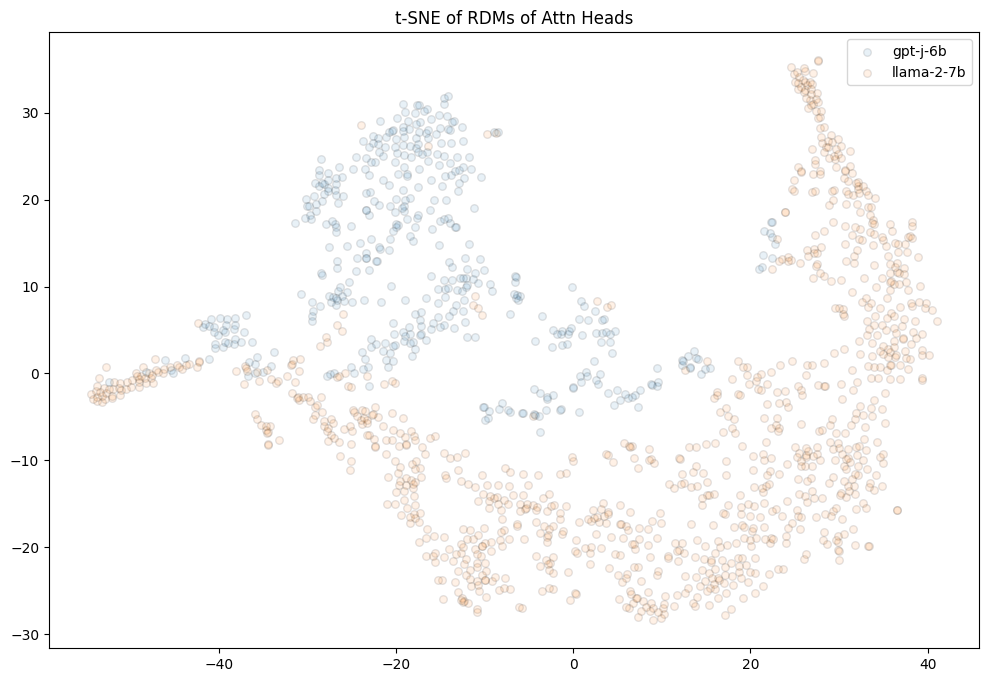

In [11]:
# Perform dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_concat)-1))
coords_2d = reducer.fit_transform(X_concat)
title_suffix = "t-SNE"

# Create the plot
plt.figure(figsize=(12, 8))

# Create scatter plot
for i in range(2):
    scatter = plt.scatter(coords_2d[all_model_id_labels==i, 0], coords_2d[all_model_id_labels==i, 1], 
                         s=30, alpha=0.1, edgecolors='black', label=model_name_list[i])
    
plt.title("t-SNE of RDMs of Attn Heads")
plt.legend()
plt.show()

In [12]:
# X_qwen_4b, y_qwen_4b, head_name_qwen_4b = prepare_data_for_plotting(rdms_qwen_4b, 0, induction_dataset)
# X_qwen_8b, y_qwen_8b, head_name_qwen_8b = prepare_data_for_plotting(rdms_qwen_8b, 1, induction_dataset)
# X_llama_8b, y_llama_8b, head_name_llama_8b = prepare_data_for_plotting(rdms_llama_8b, 2, induction_dataset)

In [13]:
# head_name_qwen_4b = ["qwen3-4b_" + str(item) for item in head_name_qwen_4b]
# head_name_qwen_8b = ["qwen3-8b_" + str(item) for item in head_name_qwen_8b]
# head_name_llama_8b = ["llama3.1-8b_" + str(item) for item in head_name_llama_8b]

In [14]:
# X_concat = np.concatenate([X_qwen_4b,X_qwen_8b,X_llama_8b], axis=0)
# y_concat = np.concatenate([y_qwen_4b,y_qwen_8b,y_llama_8b])
# head_name_concat = head_name_qwen_4b + head_name_qwen_8b + head_name_llama_8b

In [15]:
# 3) Dimensionality reduction and plotting
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
def plot_attention_heads_2d(rdm_vectors, induction_scores, head_labels, method='tsne'):
    """
    Plot attention heads in 2D based on their RDMs, colored by induction scores
    """
    # Perform dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(rdm_vectors)-1))
        coords_2d = reducer.fit_transform(rdm_vectors)
        title_suffix = "t-SNE"
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        coords_2d = reducer.fit_transform(rdm_vectors)
        title_suffix = f"PCA (explained variance: {reducer.explained_variance_ratio_.sum():.2%})"
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot
    scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1], 
                         c=induction_scores, cmap='viridis', 
                         s=60, alpha=0.2, edgecolors='black', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Induction Score', fontsize=12)
    
    # Customize plot
    plt.xlabel(f'{method.upper()} 1', fontsize=12)
    plt.ylabel(f'{method.upper()} 2', fontsize=12)
    plt.title(f'Attention Heads in RDM Space ({title_suffix})\nColored by Induction Score', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Optionally add text labels for heads with highest/lowest induction scores
    # Get indices of top and bottom heads
    # top_indices = np.argsort(induction_scores)[-15:]  # Top 5
    top_indices = np.where(induction_scores>0.01)[0]

    for idx in top_indices:
        idx = int(idx)
        if head_labels[idx].startswith("gpt-j"):
            color = 'red'
        elif head_labels[idx].startswith("gpt-neox"):
            color = 'blue'
        elif head_labels[idx].startswith("llama-2-7b"):
            color = 'green'
        else:
            color = 'yellow'
        plt.annotate(head_labels[idx], (coords_2d[idx, 0], coords_2d[idx, 1]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=12, alpha=0.8, color=color)
    
    # for idx in bottom_indices:
    #     plt.annotate(head_labels[idx], (coords_2d[idx, 0], coords_2d[idx, 1]), 
    #                 xytext=(5, 5), textcoords='offset points', 
    #                 fontsize=8, alpha=0.8, color='blue')
    
    plt.tight_layout()
    plt.show()
    
    return coords_2d

Creating t-SNE visualization...


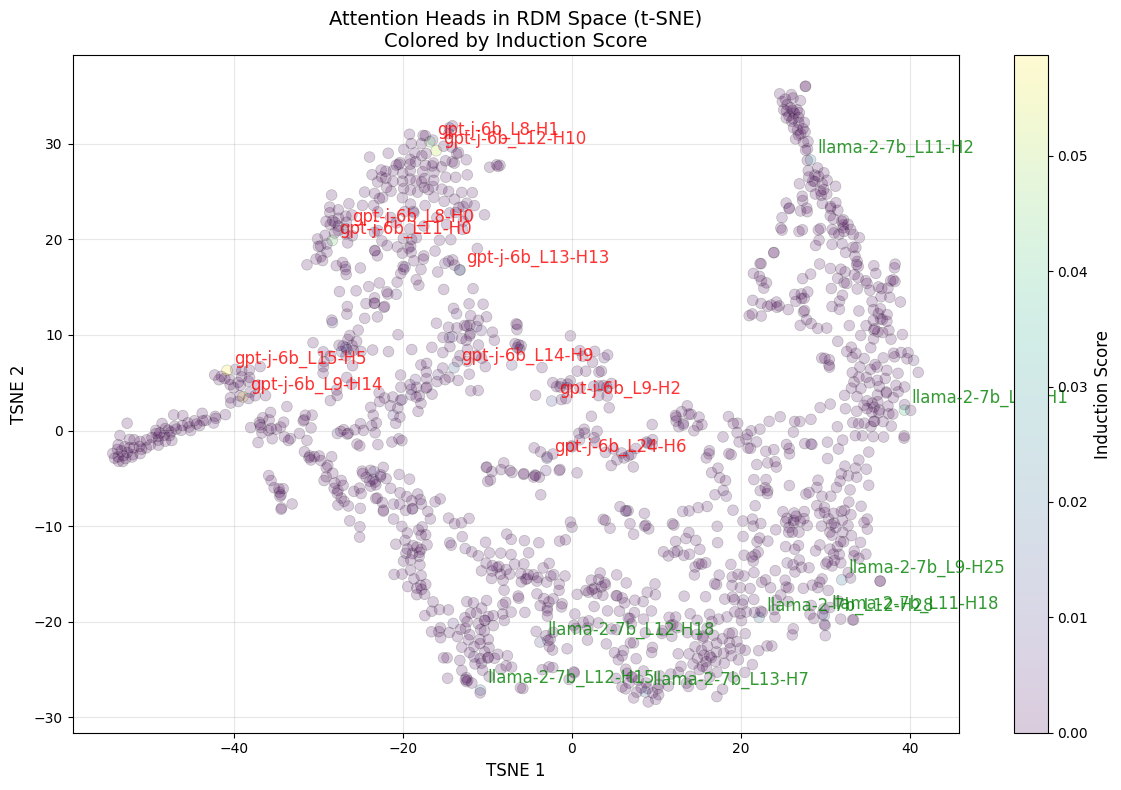

In [16]:
# Plot using t-SNE
print("Creating t-SNE visualization...")
tsne_coords = plot_attention_heads_2d(X_concat, y_concat, head_name_concat, method='tsne')

Creating PCA visualization...


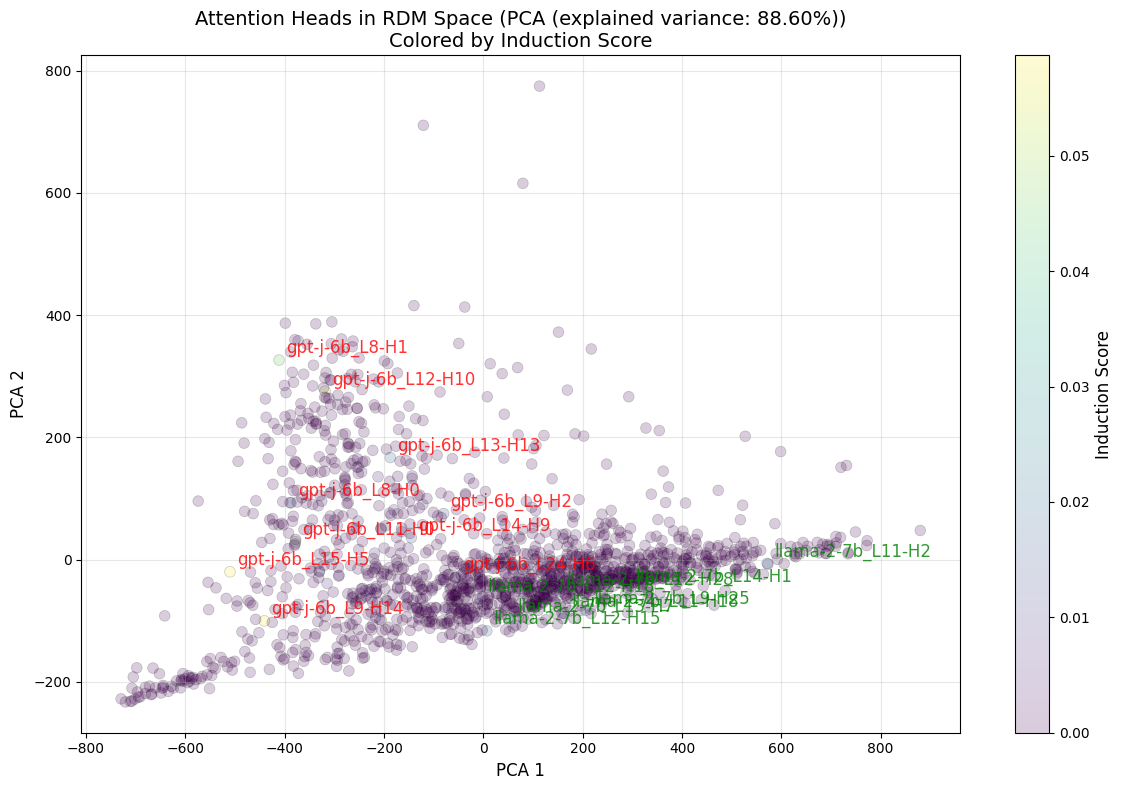

In [17]:
# Plot using PCA
print("Creating PCA visualization...")
pca_coords = plot_attention_heads_2d(X_concat, y_concat, head_name_concat, method='pca')

In [19]:
# # 4) Additional analysis: correlation between RDM similarity and induction scores
# def analyze_rdm_induction_correlation(rdm_vectors, induction_scores, head_labels):
#     """
#     Analyze the relationship between RDM patterns and induction scores
#     """
#     from scipy.stats import pearsonr
#     from scipy.spatial.distance import pdist, squareform
    
#     # Compute pairwise correlations between RDM vectors
#     rdm_similarity_matrix = np.corrcoef(rdm_vectors)
    
#     # Compute pairwise differences in induction scores
#     induction_diff_matrix = np.abs(np.subtract.outer(induction_scores, induction_scores))
    
#     # Extract upper triangle (to avoid duplicates and diagonal)
#     triu_indices = np.triu_indices_from(rdm_similarity_matrix, k=1)
#     rdm_similarities = rdm_similarity_matrix[triu_indices]
#     induction_diffs = induction_diff_matrix[triu_indices]
    
#     # Compute correlation
#     correlation, p_value = pearsonr(rdm_similarities, 1 - induction_diffs)  # 1 - diff to make it similarity
    
#     print(f"\nCorrelation Analysis:")
#     print(f"Correlation between RDM similarity and induction score similarity: {correlation:.3f}")
#     print(f"P-value: {p_value:.3e}")
    
#     # Plot the relationship
#     plt.figure(figsize=(10, 6))
#     plt.subplot(1, 2, 1)
#     plt.scatter(rdm_similarities, 1 - induction_diffs, alpha=0.5)
#     plt.xlabel('RDM Similarity (correlation)')
#     plt.ylabel('Induction Score Similarity (1 - |diff|)')
#     plt.title(f'RDM vs Induction Similarity\nr = {correlation:.3f}')
#     plt.grid(True, alpha=0.3)
    
#     # Plot induction score distribution
#     plt.subplot(1, 2, 2)
#     plt.hist(induction_scores, bins=20, alpha=0.7, edgecolor='black')
#     plt.xlabel('Induction Score')
#     plt.ylabel('Number of Heads')
#     plt.title('Distribution of Induction Scores')
#     plt.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()

# # Run correlation analysis
# analyze_rdm_induction_correlation(rdm_vectors, induction_scores, head_labels)

### classifier

In [4]:
# file_path = "./results/attention_maps/rdms_qwen3-8b_pile-100-150.pkl"
# with open(file_path, 'rb') as file:
#     rdms_qwen_8b = pickle.load(file)

# file_path = "./results/attention_maps/rdms_qwen3-4b_pile-100-150.pkl"
# with open(file_path, 'rb') as file:
#     rdms_qwen_4b = pickle.load(file)

# file_path = "./results/attention_maps/rdms_llama-3.2-3b_pile-100-150.pkl"
# with open(file_path, 'rb') as file:
#     rdms_llama_3b = pickle.load(file)

# file_path = "./results/attention_maps/rdms_llama-3.1-8b_pile-100-150.pkl"
# with open(file_path, 'rb') as file:
#     rdms_llama_8b = pickle.load(file)

# file_path = "./results/attention_maps/rdms_olmo2-7b_pile-100-150.pkl"
# with open(file_path, 'rb') as file:
#     rdms_olmo2_7b = pickle.load(file)

# file_path = "./results/attention_maps/rdms_pythia-6.9b_pile-100-150.pkl"
# with open(file_path, 'rb') as file:
#     rdms_pythia_69b = pickle.load(file)

In [5]:
# # for concept induction heads
# import json
# with open('./results/attention_scores/Llama-3.2-3B-Instruct/n2048_seqlen30.json', 'r') as file:
#     attention_score_llama_3b = json.load(file)
# with open('./results/attention_scores/Llama-3.1-8B-Instruct/n2048_seqlen30.json', 'r') as file:
#     attention_score_llama_8b = json.load(file)
# with open('./results/attention_scores/OLMo-2-1124-7B/n2048_seqlen30.json', 'r') as file:
#     attention_score_olmo2_7b = json.load(file)
# with open('./results/attention_scores/pythia-6.9b/n2048_seqlen30.json', 'r') as file:
#     attention_score_pythia_69b = json.load(file)

In [34]:
# def prepare_data_for_plotting(all_rdms, attention_score):
#     """
#     Extract RDM vectors and corresponding induction scores for all attention heads
#     """
#     rdm_vectors = []
#     induction_scores = []
#     head_labels = []
    
#     for layer_idx, layer in enumerate(all_rdms.keys()):
#         n_heads = len(all_rdms[layer])
#         for head_idx, head in enumerate(all_rdms[layer].keys()):
#             # Get RDM vector
#             rdm_vector = all_rdms[layer][head]
#             if np.isnan(rdm_vector.sum()):
#                 continue
#             rdm_vectors.append(rdm_vector)
            
#             # Get induction score next_tok_attn, end_tok_attn
#             induction_score = attention_score['end_tok_attn'][layer_idx * n_heads + head_idx]['score']
#             induction_scores.append(induction_score)
            
#             # Create label for this head
#             head_labels.append(f"L{layer_idx}_H{head_idx}")
    
#     return np.array(rdm_vectors), np.array(induction_scores), head_labels

# X_llama_3b, y_llama_3b, _ = prepare_data_for_plotting(rdms_llama_3b, attention_score_llama_3b)
# X_llama_8b, y_llama_8b, _ = prepare_data_for_plotting(rdms_llama_8b, attention_score_llama_8b)
# X_olmo2_7b, y_olmo2_7b, _ = prepare_data_for_plotting(rdms_olmo2_7b, attention_score_olmo2_7b)
# X_pythia_69b, y_pythia_69b, _ = prepare_data_for_plotting(rdms_pythia_69b, attention_score_pythia_69b)

In [ ]:
# for induction heads
with open('./results/induction_heads/induction_dataset.json', 'r') as file:
    induction_dataset = json.load(file)
    
def prepare_data_for_plotting(all_rdms, model_index, induction_dataset):
    """
    Extract RDM vectors and corresponding induction scores for all attention heads
    """
    rdm_vectors = []
    induction_scores = []
    head_labels = []
    
    for layer_idx, layer in enumerate(all_rdms.keys()):
        for head_idx, head in enumerate(all_rdms[layer].keys()):
            # Get RDM vector
            rdm_vector = all_rdms[layer][head]
            
            # Get induction score
            induction_score = induction_dataset['model_results'][model_index]['induction_scores'][layer_idx][head_idx]
            
            if np.isnan(rdm_vector.sum()):
                print(f"L{layer_idx}_H{head_idx}, {induction_score}")
                continue
            rdm_vectors.append(rdm_vector)
            induction_scores.append(induction_score)
            head_labels.append(f"L{layer_idx}_H{head_idx}")
    
    return np.array(rdm_vectors), np.array(induction_scores), head_labels

X_olmo2_7b, y_olmo2_7b, _ = prepare_data_for_plotting(rdms_olmo2_7b, 0, induction_dataset)
X_pythia_69b, y_pythia_69b, _ = prepare_data_for_plotting(rdms_pythia_69b, 1, induction_dataset)
X_qwen_4b, y_qwen_4b, _ = prepare_data_for_plotting(rdms_qwen_4b, 2, induction_dataset)
X_qwen_8b, y_qwen_8b, _ = prepare_data_for_plotting(rdms_qwen_8b, 3, induction_dataset)
X_llama_3b, y_llama_3b, _ = prepare_data_for_plotting(rdms_llama_3b, 4, induction_dataset)
X_llama_8b, y_llama_8b, _ = prepare_data_for_plotting(rdms_llama_8b, 5, induction_dataset)

In [35]:
X_pythia_69b.shape, y_pythia_69b.shape

((319, 4950), (319,))

In [36]:
all_data = {"llama-3.2-3b": (X_llama_3b, y_llama_3b),
            "llama-3.1-8b": (X_llama_8b, y_llama_8b),
            "olmo2-7b": (X_olmo2_7b, y_olmo2_7b),
            "pythia-6.9b": (X_pythia_69b, y_pythia_69b)}
# "qwen3-4b": (X_qwen_4b, y_qwen_4b),
#             "qwen3-8b": (X_qwen_8b, y_qwen_8b),

In [19]:
all_data.keys()

dict_keys(['gpt-j-6b', 'llama-2-7b'])

In [20]:
all_data['llama-2-7b'][0].shape

(1024, 500)

In [43]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

X_train = all_data['llama-2-7b'][0]
y_train = all_data['llama-2-7b'][1]

# Train linear regression on 4b data
print("Training linear regression on train data...")

model = LinearRegression()
# model = Ridge(alpha=1)
model.fit(X_train, y_train)

# model = LogisticRegression(class_weight='balanced',max_iter=1000)
# y_train_thresholded = y_train>0.005
# model.fit(X_train, y_train_thresholded)

# bins = np.linspace(y_train.min(), y_train.max(), 10)
# y_binned = np.digitize(y_train, bins)
# from sklearn.utils.class_weight import compute_sample_weight
# sample_weights = compute_sample_weight('balanced', y_binned)
# model = LinearRegression()
# model.fit(X_train, y_train, sample_weight=sample_weights)

Training linear regression on train data...


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


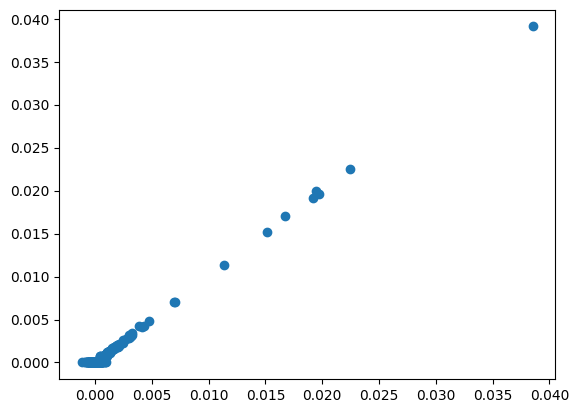

In [44]:
plt.scatter(model.predict(X_train), y_train)

In [45]:
threshold = 0.005

Making predictions on test data...

Model Performance:
R² Score: -361.8764
Mean Squared Error: 0.0122
Root Mean Squared Error: 0.1103
Mean Absolute Error: 0.0899

Model Details:
Number of features: 1000
Training samples: 448
Test samples: 448


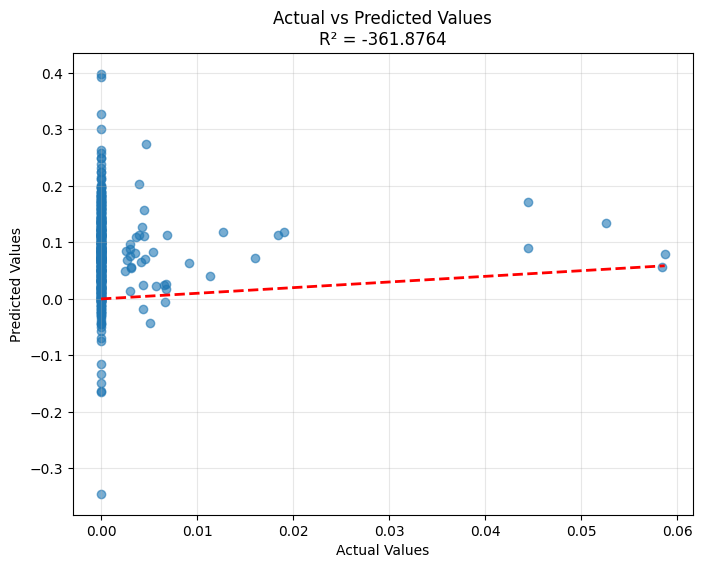

In [46]:
# Make predictions on test data
print("Making predictions on test data...")
X_test = all_data['gpt-j-6b'][0]
y_test = all_data['gpt-j-6b'][1]
# X_test = X_4b
# y_test = y_4b
y_pred = model.predict(X_test)
# y_pred = model.decision_function(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"\nModel Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Print model coefficients
print(f"\nModel Details:")
print(f"Number of features: {X_test.shape[1]}")
print(f"Training samples: {X_test.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Optional: Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values\nR² = {r2:.4f}')
plt.grid(True, alpha=0.3)
plt.show()


BINARY CLASSIFICATION EVALUATION
AUROC: 0.4399

Class Distribution in Test Data:
True (y > 0.35): 19 (4.2%)
False (y ≤ 0.35): 429 (95.8%)


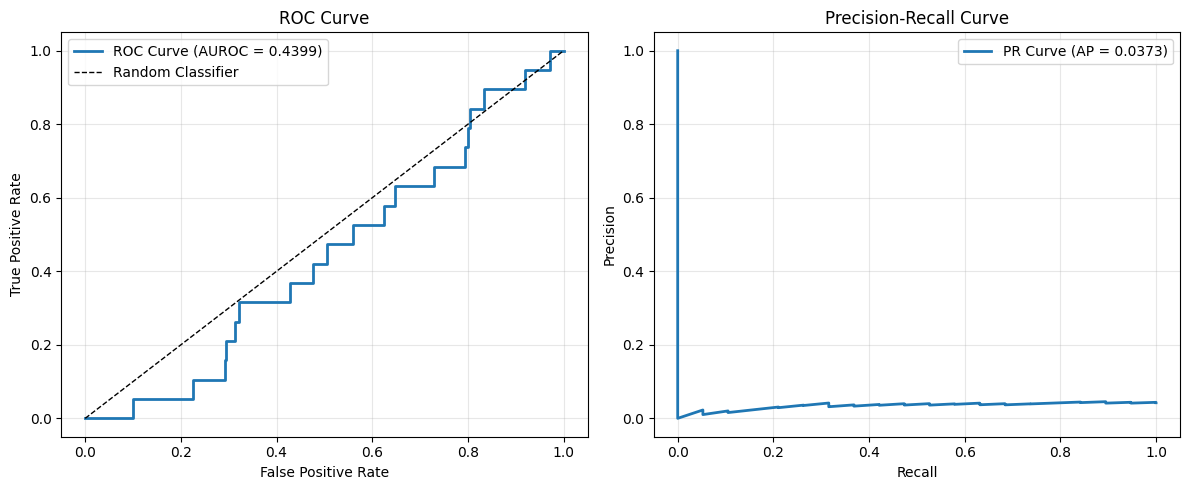

In [47]:
# Binary classification evaluation (y > 0.5 = True)
print(f"\n" + "="*50)
print("BINARY CLASSIFICATION EVALUATION")
print("="*50)

# Convert to binary labels
y_binary_true = (y_test > threshold).astype(int)

# Use regression predictions as scores for AUROC
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve

# Calculate AUROC
auroc = roc_auc_score(y_binary_true, y_pred)
print(f"AUROC: {auroc:.4f}")

# Additional binary classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Class distribution
print(f"\nClass Distribution in Test Data:")
print(f"True (y > 0.35): {np.sum(y_binary_true)} ({np.mean(y_binary_true)*100:.1f}%)")
print(f"False (y ≤ 0.35): {len(y_binary_true) - np.sum(y_binary_true)} ({(1-np.mean(y_binary_true))*100:.1f}%)")

# Plot ROC Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_binary_true, y_pred)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUROC = {auroc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
precision_vals, recall_vals, _ = precision_recall_curve(y_binary_true, y_pred)
from sklearn.metrics import average_precision_score
ap_score = average_precision_score(y_binary_true, y_pred)
plt.plot(recall_vals, precision_vals, linewidth=2, label=f'PR Curve (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
# Find optimal threshold using precision-recall or F1
from sklearn.metrics import precision_recall_curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_binary_true, y_pred)

# Find threshold that maximizes F1
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals)
optimal_idx = np.argmax(f1_scores[:-1])  # exclude last element
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"F1 at optimal threshold: {f1_scores[optimal_idx]:.3f}")

Optimal threshold: 0.004
F1 at optimal threshold: nan


/tmp/ipykernel_13984/1281589062.py:6: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals)


In [48]:
(all_data['llama-2-7b'][1]>0.005).sum()

np.int64(10)

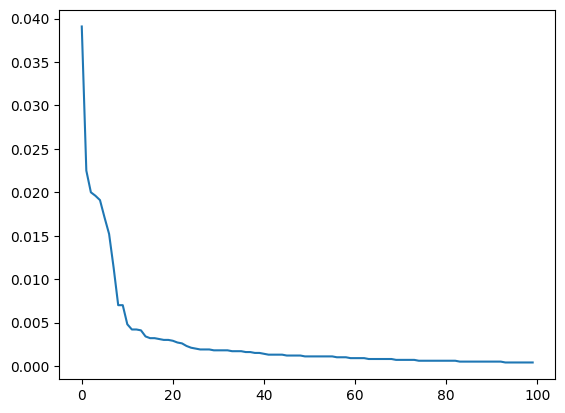

In [39]:
plt.plot(sorted(all_data['llama-2-7b'][1], reverse=True)[:100])

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
import pandas as pd

threshold = 0.01

# Get dataset names
dataset_names = list(all_data.keys())
n_datasets = len(dataset_names)

# Initialize results matrix
auroc_matrix = np.zeros((n_datasets, n_datasets))
r2_matrix = np.zeros((n_datasets, n_datasets))

# Perform cross-dataset evaluation
for i, train_name in enumerate(dataset_names):
    print(f"training on {train_name}...")
    # Get training data
    X_train, y_train = all_data[train_name]
    # Train linear regression model
    # model = LinearRegression()
    model = Ridge(alpha=1)
    model.fit(X_train, y_train)
    
    for j, test_name in enumerate(dataset_names):
        if train_name == test_name:
            auroc_matrix[i, j] = np.nan
            r2_matrix[i, j] = np.nan
            continue
        print(f"testing on {test_name}...")
        # Get test data
        X_test, y_test = all_data[test_name]
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Convert to binary labels using threshold
        y_binary_true = (y_test > threshold).astype(int)
        
        # Calculate AUROC
        try:
            r2_matrix[i, j] = r2_score(y_test, y_pred)
            auroc = roc_auc_score(y_binary_true, y_pred)
            auroc_matrix[i, j] = auroc
        except ValueError as e:
            # Handle case where all labels are the same class
            print(f"Warning: AUROC calculation failed for {train_name}->{test_name}: {e}")
            auroc_matrix[i, j] = np.nan

training on gpt-j-6b...
testing on llama-2-7b...
training on llama-2-7b...
testing on gpt-j-6b...


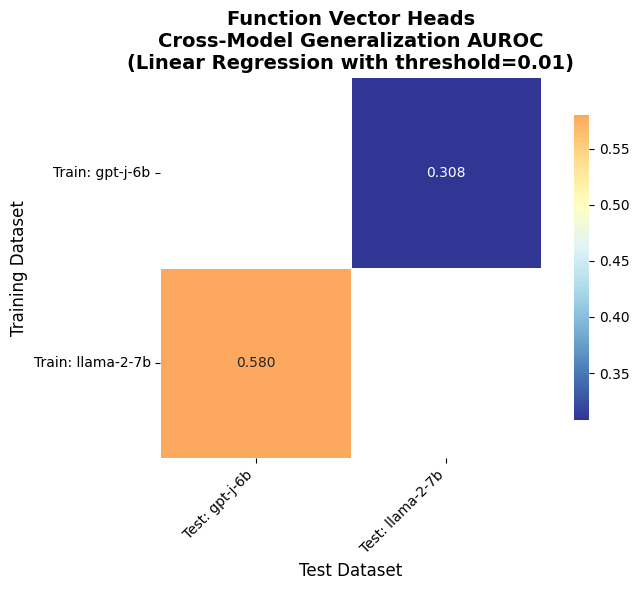

In [51]:
# Create DataFrame for better visualization
auroc_df = pd.DataFrame(auroc_matrix, 
                       index=[f"Train: {name}" for name in dataset_names],
                       columns=[f"Test: {name}" for name in dataset_names])

# Create the heatmap
plt.figure(figsize=(8, 6))
mask = np.isnan(auroc_matrix)
sns.heatmap(auroc_df, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlBu_r',
            center=0.5,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            mask=mask)

plt.title(f'Function Vector Heads\nCross-Model Generalization AUROC\n(Linear Regression with threshold={threshold})', 
          fontsize=14, fontweight='bold')
plt.xlabel('Test Dataset', fontsize=12)
plt.ylabel('Training Dataset', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

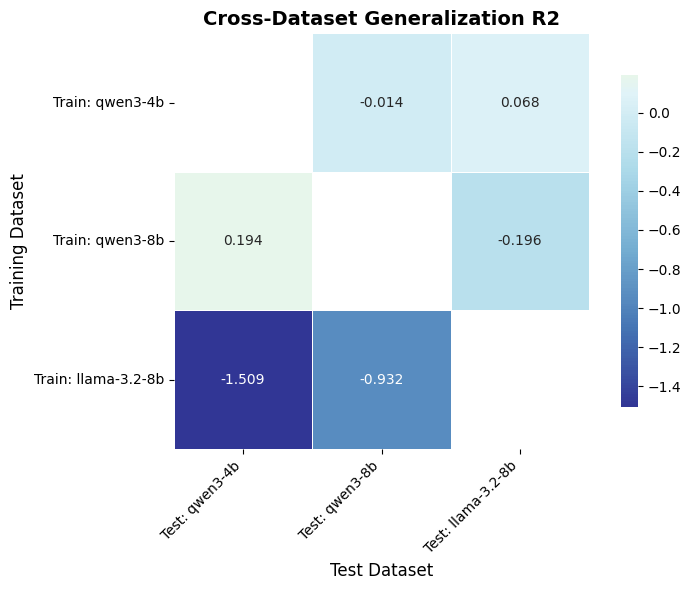

In [70]:
# Create DataFrame for better visualization
r2_df = pd.DataFrame(r2_matrix, 
                       index=[f"Train: {name}" for name in dataset_names],
                       columns=[f"Test: {name}" for name in dataset_names])

# Create the heatmap
plt.figure(figsize=(8, 6))
mask = np.isnan(auroc_matrix)
sns.heatmap(r2_df, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlBu_r',
            center=0.5,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            mask=mask)

plt.title('Cross-Dataset Generalization R2', 
          fontsize=14, fontweight='bold')
plt.xlabel('Test Dataset', fontsize=12)
plt.ylabel('Training Dataset', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Discriminative approach

In [4]:
from attendome.model import discriminative_models as dm

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
# load data
sent_emb = np.load("./results/embeddings/embeddings_Qwen3-Embedding-8B_pile100000-150.npy")[:10000]

file_path = "./results/attention_maps/attn_maps_qwen3-4b_50heads_pile-10000-150.pkl"
with open(file_path, 'rb') as f:
    attn_maps = pickle.load(f)

In [7]:
num_of_samples = sent_emb.shape[0]
num_of_samples

10000

In [8]:
label = 0
labels = []
sentence_ids = []
layer_ids = []
head_ids = []
for layer_id in attn_maps.keys():
    for head_id in attn_maps[layer_id].keys():
        assert attn_maps[layer_id][head_id].shape[0] == num_of_samples, attn_maps[layer_id][head_id].shape
        for sent_id in range(num_of_samples):
            labels.append(label)
            sentence_ids.append(sent_id)
            layer_ids.append(layer_id)
            head_ids.append(head_id)
        label += 1

# Split data based on sent_id for generalization to new sentences
from sklearn.model_selection import train_test_split
# Get unique sentence IDs
unique_sent_ids = list(range(num_of_samples))
# Split sentence IDs into train and test sets
train_sent_ids, test_sent_ids = train_test_split(
    unique_sent_ids, test_size=0.2, random_state=42
)
# Split training sentence IDs into train and validation sets
train_sent_ids, val_sent_ids = train_test_split(
    train_sent_ids, test_size=0.2, random_state=42
)

# Create indices based on sentence ID splits
train_idx = [i for i, sent_id in enumerate(sentence_ids) if sent_id in train_sent_ids]
val_idx = [i for i, sent_id in enumerate(sentence_ids) if sent_id in val_sent_ids]
test_idx = [i for i, sent_id in enumerate(sentence_ids) if sent_id in test_sent_ids]

len(train_idx), len(val_idx), len(test_idx)

(320000, 80000, 100000)

In [9]:
# Get dimensions
sent_emb_dim = len(sent_emb[0])
attn_map_dim = list(attn_maps[13][13])[0].flatten().shape[0]
num_classes = len(set(labels))

print(f"Dataset info:")
print(f"- Sentence embedding dim: {sent_emb_dim}")
print(f"- Attention map dim: {attn_map_dim}")
print(f"- Number of classes: {num_classes}")
print(f"- Train/Val/Test split: {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")

Dataset info:
- Sentence embedding dim: 4096
- Attention map dim: 22500
- Number of classes: 50
- Train/Val/Test split: 320000/80000/100000


### naive supervised learning

In [11]:
# Create datasets
train_dataset = dm.AttentionHeadDataset(
    sent_emb, attn_maps,
    [sentence_ids[i] for i in train_idx],
    [layer_ids[i] for i in train_idx],
    [head_ids[i] for i in train_idx],
    [labels[i] for i in train_idx]
)

val_dataset = dm.AttentionHeadDataset(
    sent_emb, attn_maps,
    [sentence_ids[i] for i in val_idx],
    [layer_ids[i] for i in val_idx],
    [head_ids[i] for i in val_idx],
    [labels[i] for i in val_idx]
)

test_dataset = dm.AttentionHeadDataset(
    sent_emb, attn_maps,
    [sentence_ids[i] for i in test_idx],
    [layer_ids[i] for i in test_idx],
    [head_ids[i] for i in test_idx],
    [labels[i] for i in test_idx]
)

# Create data loaders
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
# Create supervised model
encoder = dm.AttentionHeadEncoder(sent_emb_dim, attn_map_dim, hidden_dim=512, output_dim=256)
supervised_model = dm.SupervisedClassifier(encoder, num_classes).to(device)

# Train supervised model
sup_train_losses, sup_val_losses, sup_val_accs = dm.train_supervised_model(
    supervised_model, train_loader, val_loader, device, epochs=50
)

Training supervised model...


Epoch 1/50: 100%|██████████| 10000/10000 [00:58<00:00, 171.00it/s]


Epoch 1: Train Loss: 1.3789, Val Loss: 0.7193, Val Acc: 0.7737


Epoch 2/50: 100%|██████████| 10000/10000 [00:57<00:00, 172.69it/s]


Epoch 2: Train Loss: 0.8210, Val Loss: 0.6419, Val Acc: 0.7914


Epoch 3/50: 100%|██████████| 10000/10000 [00:58<00:00, 171.58it/s]


Epoch 3: Train Loss: 0.7608, Val Loss: 0.6316, Val Acc: 0.7888


Epoch 4/50: 100%|██████████| 10000/10000 [01:01<00:00, 162.01it/s]


Epoch 4: Train Loss: 0.7342, Val Loss: 0.5999, Val Acc: 0.8014


Epoch 5/50: 100%|██████████| 10000/10000 [01:02<00:00, 159.25it/s]


Epoch 5: Train Loss: 0.7187, Val Loss: 0.6012, Val Acc: 0.8019


Epoch 6/50: 100%|██████████| 10000/10000 [01:19<00:00, 125.05it/s]


Epoch 6: Train Loss: 0.7088, Val Loss: 0.5591, Val Acc: 0.8133


Epoch 7/50: 100%|██████████| 10000/10000 [01:07<00:00, 149.24it/s]


Epoch 7: Train Loss: 0.7019, Val Loss: 0.5846, Val Acc: 0.8097


Epoch 8/50: 100%|██████████| 10000/10000 [01:17<00:00, 128.33it/s]


Epoch 8: Train Loss: 0.6976, Val Loss: 0.5893, Val Acc: 0.8023


Epoch 9/50: 100%|██████████| 10000/10000 [01:16<00:00, 130.92it/s]


Epoch 9: Train Loss: 0.6913, Val Loss: 0.5526, Val Acc: 0.8190


Epoch 10/50: 100%|██████████| 10000/10000 [01:08<00:00, 146.17it/s]


Epoch 10: Train Loss: 0.6896, Val Loss: 0.5851, Val Acc: 0.8041


Epoch 11/50: 100%|██████████| 10000/10000 [01:04<00:00, 155.71it/s]


Epoch 11: Train Loss: 0.6850, Val Loss: 0.5726, Val Acc: 0.8101


Epoch 12/50: 100%|██████████| 10000/10000 [01:11<00:00, 140.67it/s]


Epoch 12: Train Loss: 0.6829, Val Loss: 0.5630, Val Acc: 0.8153


Epoch 13/50: 100%|██████████| 10000/10000 [01:03<00:00, 157.70it/s]


Epoch 13: Train Loss: 0.6798, Val Loss: 0.5982, Val Acc: 0.8004


Epoch 14/50: 100%|██████████| 10000/10000 [01:11<00:00, 140.81it/s]


Epoch 14: Train Loss: 0.6765, Val Loss: 0.5305, Val Acc: 0.8262


Epoch 15/50: 100%|██████████| 10000/10000 [01:09<00:00, 143.59it/s]


Epoch 15: Train Loss: 0.6760, Val Loss: 0.5539, Val Acc: 0.8155


Epoch 16/50: 100%|██████████| 10000/10000 [01:21<00:00, 122.39it/s]


Epoch 16: Train Loss: 0.6730, Val Loss: 0.5837, Val Acc: 0.7994


Epoch 17/50: 100%|██████████| 10000/10000 [01:24<00:00, 119.00it/s]


Epoch 17: Train Loss: 0.6727, Val Loss: 0.5470, Val Acc: 0.8230


Epoch 18/50: 100%|██████████| 10000/10000 [01:03<00:00, 157.37it/s]


Epoch 18: Train Loss: 0.6699, Val Loss: 0.5340, Val Acc: 0.8199


Epoch 19/50: 100%|██████████| 10000/10000 [01:07<00:00, 148.47it/s]


Epoch 19: Train Loss: 0.6696, Val Loss: 0.5294, Val Acc: 0.8259


Epoch 20/50: 100%|██████████| 10000/10000 [01:03<00:00, 158.20it/s]


Epoch 20: Train Loss: 0.6684, Val Loss: 0.5318, Val Acc: 0.8236


Epoch 21/50: 100%|██████████| 10000/10000 [01:08<00:00, 146.38it/s]


Epoch 21: Train Loss: 0.6667, Val Loss: 0.5396, Val Acc: 0.8185


Epoch 22/50: 100%|██████████| 10000/10000 [01:13<00:00, 135.25it/s]


Epoch 22: Train Loss: 0.6682, Val Loss: 0.5494, Val Acc: 0.8163


Epoch 23/50: 100%|██████████| 10000/10000 [01:11<00:00, 139.22it/s]


Epoch 23: Train Loss: 0.6635, Val Loss: 0.5261, Val Acc: 0.8256


Epoch 24/50: 100%|██████████| 10000/10000 [01:18<00:00, 127.50it/s]


Epoch 24: Train Loss: 0.6652, Val Loss: 0.5340, Val Acc: 0.8268


Epoch 25/50: 100%|██████████| 10000/10000 [01:16<00:00, 130.42it/s]


Epoch 25: Train Loss: 0.6617, Val Loss: 0.5566, Val Acc: 0.8139


Epoch 26/50: 100%|██████████| 10000/10000 [01:21<00:00, 122.25it/s]


Epoch 26: Train Loss: 0.6605, Val Loss: 0.5296, Val Acc: 0.8297


Epoch 27/50: 100%|██████████| 10000/10000 [01:19<00:00, 126.49it/s]


Epoch 27: Train Loss: 0.6592, Val Loss: 0.5430, Val Acc: 0.8179


Epoch 28/50: 100%|██████████| 10000/10000 [01:16<00:00, 131.53it/s]


Epoch 28: Train Loss: 0.6560, Val Loss: 0.5266, Val Acc: 0.8276


Epoch 29/50: 100%|██████████| 10000/10000 [01:19<00:00, 125.93it/s]


Epoch 29: Train Loss: 0.6564, Val Loss: 0.5361, Val Acc: 0.8252


Epoch 30/50: 100%|██████████| 10000/10000 [01:21<00:00, 123.24it/s]


Epoch 30: Train Loss: 0.4660, Val Loss: 0.3593, Val Acc: 0.8864


Epoch 31/50: 100%|██████████| 10000/10000 [01:22<00:00, 121.58it/s]


Epoch 31: Train Loss: 0.4060, Val Loss: 0.3378, Val Acc: 0.8925


Epoch 32/50: 100%|██████████| 10000/10000 [01:20<00:00, 124.92it/s]


Epoch 32: Train Loss: 0.3788, Val Loss: 0.3282, Val Acc: 0.8950


Epoch 33/50: 100%|██████████| 10000/10000 [01:16<00:00, 130.22it/s]


Epoch 33: Train Loss: 0.3601, Val Loss: 0.3186, Val Acc: 0.8981


Epoch 34/50: 100%|██████████| 10000/10000 [01:19<00:00, 125.52it/s]


Epoch 34: Train Loss: 0.3458, Val Loss: 0.3115, Val Acc: 0.9012


Epoch 35/50: 100%|██████████| 10000/10000 [01:20<00:00, 124.23it/s]


Epoch 35: Train Loss: 0.3341, Val Loss: 0.3119, Val Acc: 0.8994


Epoch 36/50: 100%|██████████| 10000/10000 [01:12<00:00, 137.67it/s]


Epoch 36: Train Loss: 0.3260, Val Loss: 0.3180, Val Acc: 0.8974


Epoch 37/50: 100%|██████████| 10000/10000 [01:07<00:00, 148.65it/s]


Epoch 37: Train Loss: 0.3186, Val Loss: 0.3067, Val Acc: 0.9009


Epoch 38/50: 100%|██████████| 10000/10000 [01:05<00:00, 152.07it/s]


Epoch 38: Train Loss: 0.3133, Val Loss: 0.3000, Val Acc: 0.9031


Epoch 39/50: 100%|██████████| 10000/10000 [01:20<00:00, 124.22it/s]


Epoch 39: Train Loss: 0.3061, Val Loss: 0.3114, Val Acc: 0.8999


Epoch 40/50: 100%|██████████| 10000/10000 [01:15<00:00, 132.76it/s]


Epoch 40: Train Loss: 0.3017, Val Loss: 0.3062, Val Acc: 0.9013


Epoch 41/50: 100%|██████████| 10000/10000 [01:17<00:00, 128.70it/s]


Epoch 41: Train Loss: 0.2976, Val Loss: 0.3123, Val Acc: 0.9006


Epoch 42/50: 100%|██████████| 10000/10000 [01:22<00:00, 121.14it/s]


Epoch 42: Train Loss: 0.2927, Val Loss: 0.3049, Val Acc: 0.9026


Epoch 43/50: 100%|██████████| 10000/10000 [01:17<00:00, 128.25it/s]


Epoch 43: Train Loss: 0.2898, Val Loss: 0.3077, Val Acc: 0.9004


Epoch 44/50: 100%|██████████| 10000/10000 [01:14<00:00, 134.12it/s]


Epoch 44: Train Loss: 0.2863, Val Loss: 0.3094, Val Acc: 0.8999


Epoch 45/50: 100%|██████████| 10000/10000 [01:20<00:00, 124.02it/s]


Epoch 45: Train Loss: 0.2339, Val Loss: 0.2726, Val Acc: 0.9161


Epoch 46/50: 100%|██████████| 10000/10000 [01:18<00:00, 126.80it/s]


Epoch 46: Train Loss: 0.2169, Val Loss: 0.2689, Val Acc: 0.9175


Epoch 47/50: 100%|██████████| 10000/10000 [01:18<00:00, 127.41it/s]


Epoch 47: Train Loss: 0.2101, Val Loss: 0.2685, Val Acc: 0.9170


Epoch 48/50: 100%|██████████| 10000/10000 [01:12<00:00, 137.08it/s]


Epoch 48: Train Loss: 0.2040, Val Loss: 0.2690, Val Acc: 0.9176


Epoch 49/50: 100%|██████████| 10000/10000 [01:12<00:00, 138.75it/s]


Epoch 49: Train Loss: 0.2003, Val Loss: 0.2691, Val Acc: 0.9174


Epoch 50/50: 100%|██████████| 10000/10000 [01:06<00:00, 151.37it/s]


Epoch 50: Train Loss: 0.1969, Val Loss: 0.2681, Val Acc: 0.9182


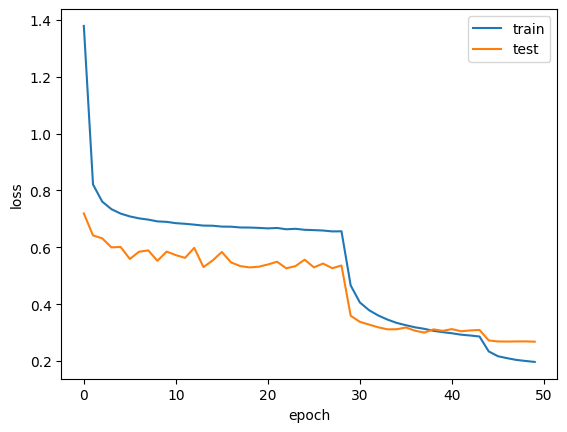

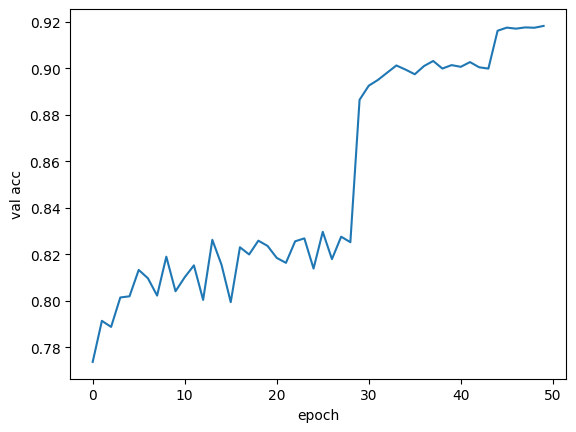

In [28]:
plt.plot(sup_train_losses, label='train')
plt.plot(sup_val_losses, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()
plt.plot(sup_val_accs)
plt.ylabel("val acc")
plt.xlabel("epoch")
plt.show()

In [25]:
# Evaluate supervised model
sup_embeddings, sup_clusters, sup_metrics = dm.evaluate_embeddings(
    supervised_model, test_loader, device, [labels[i] for i in test_idx]
)

print(f"\nSupervised Learning Results:")
print(f"- Final validation accuracy: {sup_val_accs[-1]:.4f}")
print(f"- Silhouette score: {sup_metrics['silhouette_score']:.4f}")
print(f"- Adjusted Rand Index: {sup_metrics['adjusted_rand_index']:.4f}")


Supervised Learning Results:
- Final validation accuracy: 0.9182
- Silhouette score: 0.3177
- Adjusted Rand Index: 0.4407


In [26]:
torch.save(supervised_model.state_dict(), './results/models/supervised_model.pth')

### contrastive learning

In [15]:
# Create contrastive datasets
contrastive_train_dataset = dm.ContrastiveDataset(
    sent_emb, attn_maps,
    [sentence_ids[i] for i in train_idx],
    [layer_ids[i] for i in train_idx],
    [head_ids[i] for i in train_idx],
    num_negatives=5
)

contrastive_val_dataset = dm.ContrastiveDataset(
    sent_emb, attn_maps,
    [sentence_ids[i] for i in val_idx],
    [layer_ids[i] for i in val_idx],
    [head_ids[i] for i in val_idx],
    num_negatives=5
)

# Create contrastive data loaders
contrastive_train_loader = DataLoader(contrastive_train_dataset, batch_size=16, shuffle=True)
contrastive_val_loader = DataLoader(contrastive_val_dataset, batch_size=16, shuffle=False)

In [ ]:
# Create contrastive model
contrastive_model = dm.AttentionHeadEncoder(sent_emb_dim, attn_map_dim, hidden_dim=512, output_dim=256).to(device)

# Train contrastive model
cont_train_losses, cont_val_losses = dm.train_contrastive_model(
    contrastive_model, contrastive_train_loader, contrastive_val_loader, device, epochs=80
)

Training contrastive model...


Epoch 1/80:   6%|▋         | 1298/20000 [00:28<06:46, 46.05it/s]

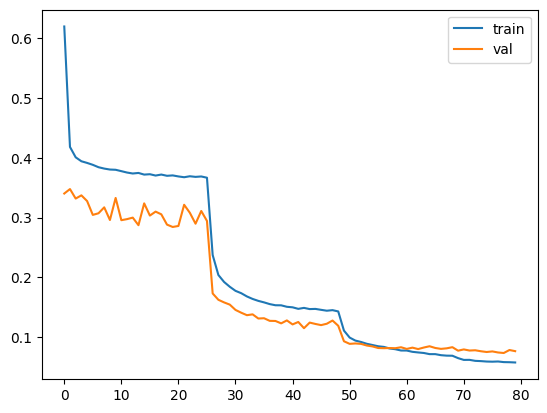

In [20]:
plt.plot(cont_train_losses, label='train')
plt.plot(cont_val_losses, label='val')
plt.legend()
plt.show()

In [21]:
# Evaluate contrastive model
cont_embeddings, cont_clusters, cont_metrics = dm.evaluate_embeddings(
    contrastive_model, test_loader, device, [labels[i] for i in test_idx]
)

print(f"\nContrastive Learning Results:")
print(f"- Silhouette score: {cont_metrics['silhouette_score']:.4f}")
print(f"- Adjusted Rand Index: {cont_metrics['adjusted_rand_index']:.4f}")


Contrastive Learning Results:
- Silhouette score: 0.3567
- Adjusted Rand Index: 0.4618


In [24]:
torch.save(contrastive_model.state_dict(), './results/models/contrastive_model.pth')


Comparison of approaches:
Supervised Learning:
  - Silhouette Score: 0.3177
  - Adjusted Rand Index: 0.4407

Contrastive Learning:
  - Silhouette Score: 0.3567
  - Adjusted Rand Index: 0.4618


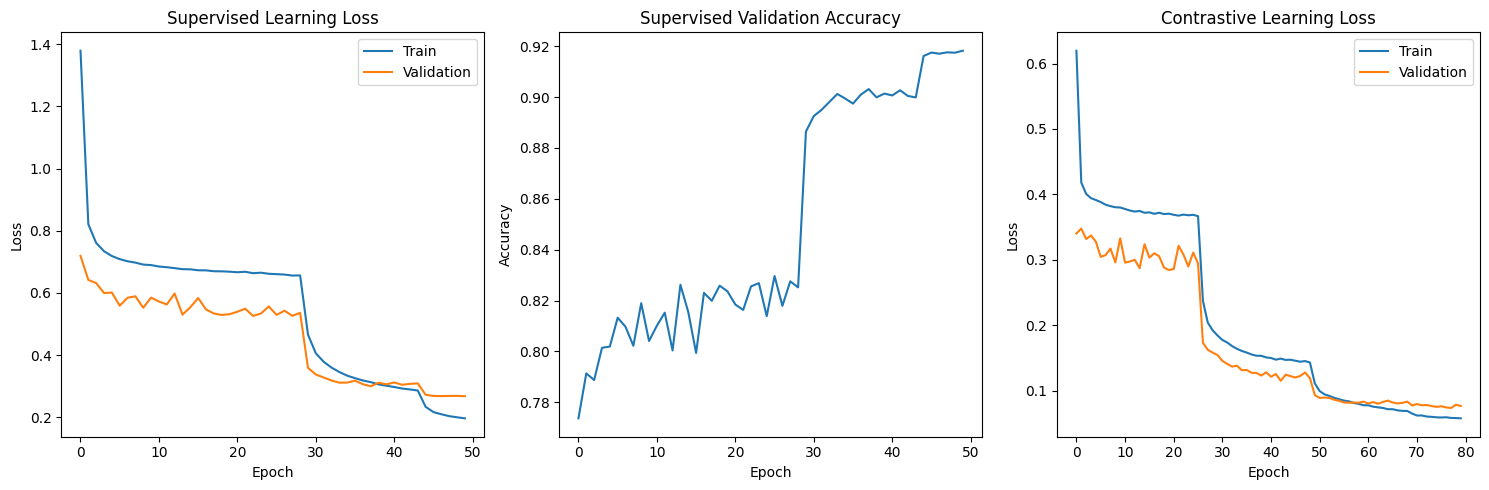

In [27]:
print(f"\nComparison of approaches:")
print(f"Supervised Learning:")
print(f"  - Silhouette Score: {sup_metrics['silhouette_score']:.4f}")
print(f"  - Adjusted Rand Index: {sup_metrics['adjusted_rand_index']:.4f}")
print(f"\nContrastive Learning:")
print(f"  - Silhouette Score: {cont_metrics['silhouette_score']:.4f}")
print(f"  - Adjusted Rand Index: {cont_metrics['adjusted_rand_index']:.4f}")

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(sup_train_losses, label='Train')
plt.plot(sup_val_losses, label='Validation')
plt.title('Supervised Learning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(sup_val_accs)
plt.title('Supervised Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(cont_train_losses, label='Train')
plt.plot(cont_val_losses, label='Validation')
plt.title('Contrastive Learning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### evaluate

In [29]:
# load the induction dataset, which contains the induction scores
import json
with open('./results/induction_heads/induction_dataset.json', 'r') as f:
    induction_dataset = json.load(f)

In [45]:
# load sentence embedding
sent_emb = np.load("./results/embeddings/embeddings_Qwen3-Embedding-8B_pile100000-150.npy")[:10000]

In [46]:
# load attention map
file_path = "./results/attention_maps/attn_maps_qwen3-4b_pile-100-150.pkl"
with open(file_path, 'rb') as file:
    attn_maps_qwen4b = pickle.load(file)

file_path = "./results/attention_maps/attn_maps_qwen3-8b_pile-100-150.pkl"
with open(file_path, 'rb') as file:
    attn_maps_qwen8b = pickle.load(file)

file_path = "./results/attention_maps/attn_maps_llama-3.1-8b_pile-100-150.pkl"
with open(file_path, 'rb') as file:
    attn_maps_llama8b = pickle.load(file)

In [47]:
sent_emb = sent_emb[:100]
num_of_samples = sent_emb.shape[0]
sent_emb.shape

(100, 4096)

In [88]:
for layer_id in attn_maps_qwen4b.keys():
    for head_id in attn_maps_qwen4b[layer_id].keys():
        attn_maps_qwen4b[layer_id][head_id] = attn_maps_qwen4b[layer_id][head_id].numpy()

In [92]:
model_index = 0 # 0: qwen4b, 1: qwen8b, 2: llama8b
attn_maps = attn_maps_qwen4b

from collections import defaultdict

def group_and_average_embeddings(head_ids, embeddings):
    """
    Group embeddings by head IDs and compute average for each group.
    
    Args:
        head_ids: List of tuples representing attention head IDs
        embeddings: List of numpy arrays or lists representing embeddings
    
    Returns:
        Dictionary mapping head_id -> averaged embedding
    """
    # Group embeddings by head ID
    grouped_embeddings = defaultdict(list)
    
    for head_id, embedding in zip(head_ids, embeddings):
        grouped_embeddings[head_id].append(embedding)
    
    # Calculate average for each group
    averaged_embeddings = {}
    for head_id, embedding_list in grouped_embeddings.items():
        # Convert to numpy array and compute mean along axis 0
        embedding_array = np.array(embedding_list)
        averaged_embeddings[head_id] = np.mean(embedding_array, axis=0)
    
    return averaged_embeddings

def compute_average_emb(sent_emb, attn_maps, model_name, model):
    # get model index
    name2index = {"qwen3-4b": 0, 
                 "qwen3-8b": 1,
                 "llama3.2-8b": 2}
    model_index = name2index[model_name]
    
    labels = []
    sentence_ids = []
    layer_ids = []
    head_ids = []
    head_id_to_label = {}
    head_id_to_score = {}
    for layer_id in attn_maps.keys():
        for head_id in attn_maps[layer_id].keys():
            assert attn_maps[layer_id][head_id].shape[0] == num_of_samples, attn_maps[layer_id][head_id].shape
            # check if induction head
            induction_score = induction_dataset['model_results'][model_index]['induction_scores'][layer_id][head_id]
            if induction_score > 0.35:
                label = 1
            else:
                label = 0
            head_id_to_label[(layer_id, head_id)] = label
            head_id_to_score[(layer_id, head_id)] = induction_score
            
            for sent_id in range(num_of_samples):
                labels.append(label)
                sentence_ids.append(sent_id)
                layer_ids.append(layer_id)
                head_ids.append(head_id)

    # Create datasets
    cross_model_dataset = dm.AttentionHeadDataset(
        sent_emb, attn_maps,
        sentence_ids,
        layer_ids,
        head_ids,
        labels
    )
    
    # Create data loaders
    from torch.utils.data import Dataset, DataLoader
    cross_model_loader = DataLoader(cross_model_dataset, batch_size=32, shuffle=True)

    # extract embeddings    
    all_embeddings = []
    all_head_ids = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(cross_model_loader):
            sent_emb_batch = batch['sent_embedding'].to(device)
            attn_map_batch = batch['attn_map'].to(device)
            
            if hasattr(model, 'encoder'):
                embeddings = model.encoder(sent_emb_batch, attn_map_batch)
            else:
                embeddings = model(sent_emb_batch, attn_map_batch)
            
            all_embeddings.append(embeddings.cpu().numpy())
            
            if 'label' in batch:
                all_labels.extend(batch['label'].cpu().numpy())
            
            # Store head IDs for analysis
            head_ids = [(l.item(), h.item()) for l, h in zip(batch['layer_id'], batch['head_id'])]
            all_head_ids.extend(head_ids)
    
    all_embeddings = np.vstack(all_embeddings)

    averaged_embeddings = group_and_average_embeddings(all_head_ids, all_embeddings)

    return averaged_embeddings, head_id_to_score, head_id_to_label

In [109]:
avg_embedding_qwen4b, head_id_to_score_qwen4b, head_id_to_label_qwen4b = compute_average_emb(sent_emb, attn_maps_qwen4b, 
                                                                                             "qwen3-4b", contrastive_model)
avg_embedding_qwen8b, head_id_to_score_qwen8b, head_id_to_label_qwen8b = compute_average_emb(sent_emb, attn_maps_qwen8b, 
                                                                                             "qwen3-8b", contrastive_model)
avg_embedding_llama8b, head_id_to_score_llama8b, head_id_to_label_llama8b = compute_average_emb(sent_emb, attn_maps_llama8b, 
                                                                                             "llama3.2-8b", contrastive_model)

100%|██████████| 3200/3200 [00:08<00:00, 385.08it/s]


In [110]:
def prepare_data(avg_emb, head_id_to_score):
    X = []
    y = []
    for head_id, embedding in avg_emb.items():
        X.append(embedding)
        y.append(head_id_to_score[head_id])
    X = np.array(X)
    y = np.array(y)
    return X, y
X_qwen4b, y_qwen4b = prepare_data(avg_embedding_qwen4b, head_id_to_score_qwen4b)
X_qwen8b, y_qwen8b = prepare_data(avg_embedding_qwen8b, head_id_to_score_qwen8b)
X_llama8b, y_llama8b = prepare_data(avg_embedding_llama8b, head_id_to_score_llama8b)
all_data = {"qwen3-4b": (X_qwen4b, y_qwen4b),
           "qwen3-8b": (X_qwen8b, y_qwen8b),
           "llama-3.2-8b": (X_llama8b, y_llama8b)}

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.metrics import r2_score

# Get dataset names
dataset_names = list(all_data.keys())
n_datasets = len(dataset_names)

# Initialize results matrix
auroc_matrix = np.zeros((n_datasets, n_datasets))
r2_matrix = np.zeros((n_datasets, n_datasets))

# Perform cross-dataset evaluation
for i, train_name in enumerate(dataset_names):
    print(f"training on {train_name}...")
    # Get training data
    X_train, y_train = all_data[train_name]
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    for j, test_name in enumerate(dataset_names):
        if train_name == test_name:
            auroc_matrix[i, j] = np.nan
            r2_matrix[i, j] = np.nan
            continue
        print(f"testing on {test_name}...")
        # Get test data
        X_test, y_test = all_data[test_name]
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Convert to binary labels using threshold
        y_binary_true = (y_test > 0.35).astype(int)
        
        # Calculate AUROC
        try:
            r2_matrix[i, j] = r2_score(y_test, y_pred)
            auroc = roc_auc_score(y_binary_true, y_pred)
            auroc_matrix[i, j] = auroc
        except ValueError as e:
            # Handle case where all labels are the same class
            print(f"Warning: AUROC calculation failed for {train_name}->{test_name}: {e}")
            auroc_matrix[i, j] = np.nan

training on qwen3-4b...
testing on qwen3-8b...
testing on llama-3.2-8b...
training on qwen3-8b...
testing on qwen3-4b...
testing on llama-3.2-8b...
training on llama-3.2-8b...
testing on qwen3-4b...
testing on qwen3-8b...


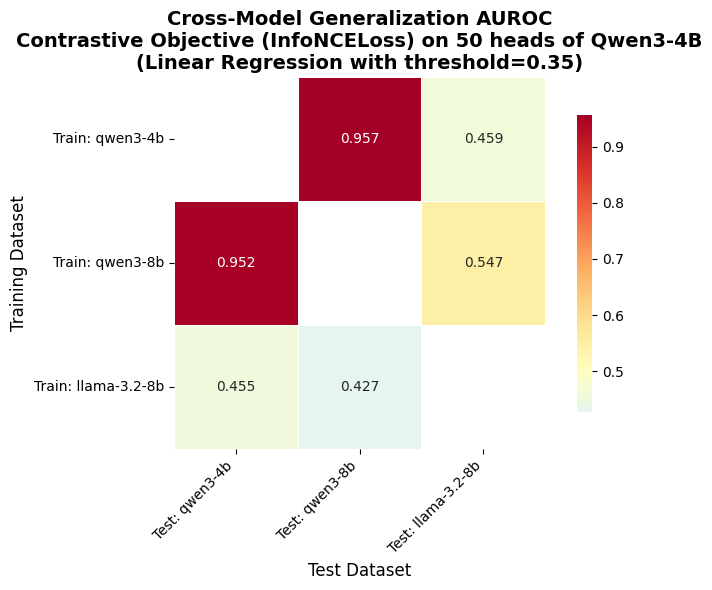

In [113]:
# Create DataFrame for better visualization
auroc_df = pd.DataFrame(auroc_matrix, 
                       index=[f"Train: {name}" for name in dataset_names],
                       columns=[f"Test: {name}" for name in dataset_names])

# Create the heatmap
plt.figure(figsize=(8, 6))
mask = np.isnan(auroc_matrix)
sns.heatmap(auroc_df, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlBu_r',
            center=0.5,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            mask=mask)

plt.title('Cross-Model Generalization AUROC\nContrastive Objective (InfoNCELoss) on 50 heads of Qwen3-4B\n(Linear Regression with threshold=0.35)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Test Dataset', fontsize=12)
plt.ylabel('Training Dataset', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Naive prediction

In [4]:
import numpy as np
import torch
import torch.nn as nn
import time

# Assuming you have your attention maps loaded as:
# attn_maps_a[layer_id][head_id] shape: [100, 22500]
# attn_maps_b[layer_id][head_id] shape: [100, 22500]

def prepare_data(name_1, name_2, train_size=80):
    """
    Prepare data for regression
    """
    file_path = f"./results/attention_maps/attn_maps_{name_1}_pile-100-150.pkl"
    with open(file_path, 'rb') as f:
        attn_maps_a = pickle.load(f)
    
    file_path = f"./results/attention_maps/attn_maps_{name_2}_pile-100-150.pkl"
    with open(file_path, 'rb') as f:
        attn_maps_b = pickle.load(f)
    
    num_layers_a = len(attn_maps_a)
    num_heads_a = len(attn_maps_a[0])
    num_layers_b = len(attn_maps_b)
    num_heads_b = len(attn_maps_b[0])
    num_samples = 100
    
    # Flatten all A heads into one array: [100, 1152, 22500]
    A_data = np.zeros((num_samples, num_layers_a * num_heads_a, 22500))
    B_data = np.zeros((num_samples, num_layers_b * num_heads_b, 22500))
    
    for layer in tqdm(range(num_layers_a)):
        for head in range(num_heads_a):
            head_idx = layer * num_heads_a + head
            A_data[:, head_idx, :] = attn_maps_a[layer][head]
            
    for layer in tqdm(range(num_layers_b)):
        for head in range(num_heads_b):
            head_idx = layer * num_heads_b + head
            B_data[:, head_idx, :] = attn_maps_b[layer][head]
    
    # Split into train/test
    train_indices = np.arange(train_size)
    test_indices = np.arange(train_size, num_samples)
    
    A_train = A_data[train_indices]  # [80, 1152, 22500]
    A_test = A_data[test_indices]    # [20, 1152, 22500]
    B_train = B_data[train_indices]  # [80, 1152, 22500]
    B_test = B_data[test_indices]    # [20, 1152, 22500]
    
    return A_train, A_test, B_train, B_test

def pytorch_approach(A_train, A_test, B_train, B_test, lr=0.001, epochs=1000):
    """
    Using PyTorch, training each B head separately to save GPU memory
    """
    print("Training with PyTorch approach (one head at a time)...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Convert A data to tensors (these stay the same for all heads)
    A_train_tensor = torch.FloatTensor(A_train).to(device)  # [80, 1152, 22500]
    A_test_tensor = torch.FloatTensor(A_test).to(device)    # [20, 1152, 22500]
    
    num_heads_a = A_train_tensor.shape[1]
    num_heads_b = B_train.shape[1]
    
    # Store results for all heads
    weights_all = np.zeros((num_heads_b, num_heads_a))
    bias_all = np.zeros(num_heads_b)
    train_errors = []
    test_errors = []
    
    # Model for predicting a single B head
    class SingleHeadRegression(nn.Module):
        def __init__(self, num_heads_a, num_positions=22500):
            super().__init__()
            self.weights = nn.Parameter(torch.randn(num_heads_a))
            self.bias = nn.Parameter(torch.zeros(22500))
            
        def forward(self, A):
            # A: [batch_size, num_heads_a, num_positions]
            # weights: [num_heads_a]
            # Output: [batch_size, num_positions]
            
            # Expand weights for broadcasting: [1, num_heads_a, 1]
            weights_expanded = self.weights.unsqueeze(0).unsqueeze(-1)
            
            # Weighted sum across heads: [batch_size, num_positions]
            output = (A * weights_expanded).sum(dim=1) + self.bias
            
            return output
    
    criterion = nn.MSELoss()
    
    # Train each B head separately
    for b_head in range(num_heads_b):
        print(f"Training head {b_head + 1}/{num_heads_b}")
        
        # Get target for this specific B head
        B_train_head = torch.FloatTensor(B_train[:, b_head, :]).to(device)  # [80, 22500]
        B_test_head = torch.FloatTensor(B_test[:, b_head, :]).to(device)    # [20, 22500]
        
        # Create new model for this head
        model = SingleHeadRegression(num_heads_a).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # Training loop for this head
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(A_train_tensor)
            loss = criterion(predictions, B_train_head)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Print progress every 200 epochs
            if (epoch + 1) % 50 == 0:
                model.eval()
                with torch.no_grad():
                    test_predictions = model(A_test_tensor)
                    test_loss = criterion(test_predictions, B_test_head)
                    print(f"  Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}")
        
        # Store final weights and bias for this head
        model.eval()
        with torch.no_grad():
            weights_all[b_head] = model.weights.cpu().numpy()
            bias_all[b_head] = model.bias.cpu().numpy()[0]
            
            # Calculate final errors for this head
            train_pred = model(A_train_tensor)
            test_pred = model(A_test_tensor)
            
            train_mse = criterion(train_pred, B_train_head).item()
            test_mse = criterion(test_pred, B_test_head).item()
            
            train_errors.append(train_mse)
            test_errors.append(test_mse)
            
            print(f"  Head {b_head + 1} final - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    
    return weights_all, bias_all, train_errors, test_errors

In [22]:
# Prepare data
print("Preparing data...")
# qwen3-4b, qwen3-8b, llama-3.1-8b
A_train, A_test, B_train, B_test = prepare_data("qwen3-4b", "llama-3.1-8b")

print(f"A_train shape: {A_train.shape}")
print(f"B_train shape: {B_train.shape}")

Preparing data...


/tmp/ipykernel_47344/600396251.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  A_data[:, head_idx, :] = attn_maps_a[layer][head]
100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


A_train shape: (80, 1152, 22500)
B_train shape: (80, 1024, 22500)


In [7]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
import random
def sklearn_approach(A_train, A_test, B_train, B_test, k=10):
    """
    Using scikit-learn LinearRegression
    This reshapes the problem to treat each (sample, position) as a separate example
    """
    print("Training with scikit-learn approach...")
    
    num_train_samples, num_heads_a, num_positions = A_train.shape
    num_heads_b = B_train.shape[1]
    
    # Store results
    weights_all = np.zeros((num_heads_b, num_heads_a))
    intercepts_all = np.zeros(num_heads_b)
    train_errors = []
    test_errors = []
    
    # for b_head in range(num_heads_b):
    for b_head in random.sample(range(num_heads_b), k):
        print(f"Training head {b_head + 1}/{num_heads_b}")
        
        # Reshape for sklearn: treat each (sample, position) as separate training example
        X_train = A_train.transpose(0, 2, 1).reshape(-1, num_heads_a)  # [80*22500, 1152]
        y_train = B_train[:, b_head, :].flatten()  # [80*22500]
        
        X_test = A_test.transpose(0, 2, 1).reshape(-1, num_heads_a)  # [20*22500, 1152]
        y_test = B_test[:, b_head, :].flatten()  # [20*22500]
        
        # Fit linear regression
        # model = LinearRegression()
        model = SGDRegressor(max_iter=5000, tol=1e-6, penalty=None, verbose=1)
        model.fit(X_train, y_train)
        
        # Store weights and intercept
        weights_all[b_head] = model.coef_
        intercepts_all[b_head] = model.intercept_
        
        # Calculate errors
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        
        train_errors.append(train_mse)
        test_errors.append(test_mse)
        print(f"Train mse: {train_mse:.6f}, test mse: {test_mse:.6f}")
    
    return weights_all, intercepts_all, train_errors, test_errors

In [8]:
weights, intercepts, train_errors, test_errors = sklearn_approach(
    A_train, A_test, B_train, B_test, k=100
)

Training with scikit-learn approach...
Training head 871/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001959, T: 1800000, Avg. loss: 0.001142
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.001683, T: 3600000, Avg. loss: 0.001104
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.003471, T: 5400000, Avg. loss: 0.001090
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.002506, T: 7200000, Avg. loss: 0.001080
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 1152, Bias: 0.002114, T: 9000000, Avg. loss: 0.001075
Total training time: 23.06 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 1152, Bias: 0.001615, T: 10800000, Avg. loss: 0.001067
Total training time: 27.67 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 1152, Bias: 0.002173, T: 12600000, Avg. loss: 0.001065
Total training time: 32.28 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 1152, Bias: 0.002273, T: 14400000, Avg. loss: 0.001060
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002041, test mse: 0.001828
Training head 646/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001912, T: 1800000, Avg. loss: 0.001156
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.001828, T: 3600000, Avg. loss: 0.001114
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.002327, T: 5400000, Avg. loss: 0.001099
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.002519, T: 7200000, Avg. loss: 0.001090
Total training time: 18.50 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 1152, Bias: 0.001584, T: 9000000, Avg. loss: 0.001083
Total training time: 23.12 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 1152, Bias: 0.001423, T: 10800000, Avg. loss: 0.001079
Total training time: 27.75 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 1152, Bias: 0.001302, T: 12600000, Avg. loss: 0.001074
Total training time: 32.37 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 1152, Bias: 0.002331, T: 14400000, Avg. loss: 0.001071
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002061, test mse: 0.001890
Training head 368/1024
-- Epoch 1
Norm: 0.12, NNZs: 1152, Bias: 0.002349, T: 1800000, Avg. loss: 0.000480
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 1152, Bias: 0.001711, T: 3600000, Avg. loss: 0.000463
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.20, NNZs: 1152, Bias: 0.001769, T: 5400000, Avg. loss: 0.000457
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.22, NNZs: 1152, Bias: 0.001959, T: 7200000, Avg. loss: 0.000452
Total training time: 18.49 seconds.
-- Epoch 5
Norm: 0.24, NNZs: 1152, Bias: 0.002123, T: 9000000, Avg. loss: 0.000451
Total training time: 23.11 seconds.
-- Epoch 6
Norm: 0.26, NNZs: 1152, Bias: 0.001876, T: 10800000, Avg. loss: 0.000448
Total training time: 27.74 seconds.
-- Epoch 7
Norm: 0.28, NNZs: 1152, Bias: 0.001583, T: 12600000, Avg. loss: 0.000447
Total training time: 32.36 seconds.
-- Epoch 8
Norm: 0.29, NNZs: 1152, Bias: 0.001468, T: 14400000, Avg. loss: 0.000445
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000867, test mse: 0.000805
Training head 103/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001811, T: 1800000, Avg. loss: 0.001170
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.002174, T: 3600000, Avg. loss: 0.001130
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.002462, T: 5400000, Avg. loss: 0.001113
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.001857, T: 7200000, Avg. loss: 0.001104
Total training time: 18.50 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.001848, T: 9000000, Avg. loss: 0.001096
Total training time: 23.13 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 1152, Bias: 0.002506, T: 10800000, Avg. loss: 0.001091
Total training time: 27.75 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 1152, Bias: 0.002857, T: 12600000, Avg. loss: 0.001086
Total training time: 32.38 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1152, Bias: 0.001492, T: 14400000, Avg. loss: 0.001082
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002076, test mse: 0.001962
Training head 164/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.001916, T: 1800000, Avg. loss: 0.000914
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 1152, Bias: 0.001658, T: 3600000, Avg. loss: 0.000883
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.26, NNZs: 1152, Bias: 0.001269, T: 5400000, Avg. loss: 0.000872
Total training time: 13.88 seconds.
-- Epoch 4
Norm: 0.29, NNZs: 1152, Bias: 0.002013, T: 7200000, Avg. loss: 0.000865
Total training time: 18.50 seconds.
-- Epoch 5
Norm: 0.32, NNZs: 1152, Bias: 0.002276, T: 9000000, Avg. loss: 0.000861
Total training time: 23.13 seconds.
-- Epoch 6
Norm: 0.35, NNZs: 1152, Bias: 0.002024, T: 10800000, Avg. loss: 0.000855
Total training time: 27.76 seconds.
-- Epoch 7
Norm: 0.37, NNZs: 1152, Bias: 0.001936, T: 12600000, Avg. loss: 0.000853
Total training time: 32.39 seconds.
-- Epoch 8
Norm: 0.40, NNZs: 1152, Bias: 0.002354, T: 14400000, Avg. loss: 0.000850
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001652, test mse: 0.001573
Training head 294/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.002434, T: 1800000, Avg. loss: 0.000673
Total training time: 4.67 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 1152, Bias: 0.002442, T: 3600000, Avg. loss: 0.000649
Total training time: 9.30 seconds.
-- Epoch 3
Norm: 0.22, NNZs: 1152, Bias: 0.002672, T: 5400000, Avg. loss: 0.000640
Total training time: 13.93 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 1152, Bias: 0.002135, T: 7200000, Avg. loss: 0.000635
Total training time: 18.56 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 1152, Bias: 0.002519, T: 9000000, Avg. loss: 0.000631
Total training time: 23.19 seconds.
-- Epoch 6
Norm: 0.31, NNZs: 1152, Bias: 0.001881, T: 10800000, Avg. loss: 0.000627
Total training time: 27.82 seconds.
-- Epoch 7
Norm: 0.33, NNZs: 1152, Bias: 0.001539, T: 12600000, Avg. loss: 0.000625
Total training time: 32.45 seconds.
-- Epoch 8
Norm: 0.35, NNZs: 1152, Bias: 0.001837, T: 14400000, Avg. loss: 0.000623
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001205, test mse: 0.001135
Training head 493/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.001259, T: 1800000, Avg. loss: 0.000759
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 1152, Bias: 0.001562, T: 3600000, Avg. loss: 0.000735
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.25, NNZs: 1152, Bias: 0.001140, T: 5400000, Avg. loss: 0.000726
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.28, NNZs: 1152, Bias: 0.001423, T: 7200000, Avg. loss: 0.000720
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 1152, Bias: 0.002000, T: 9000000, Avg. loss: 0.000716
Total training time: 23.08 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 1152, Bias: 0.001349, T: 10800000, Avg. loss: 0.000713
Total training time: 27.70 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 1152, Bias: 0.001194, T: 12600000, Avg. loss: 0.000711
Total training time: 32.31 seconds.
-- Epoch 8
Norm: 0.36, NNZs: 1152, Bias: 0.001234, T: 14400000, Avg. loss: 0.000708
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001381, test mse: 0.001318
Training head 451/1024
-- Epoch 1
Norm: 0.12, NNZs: 1152, Bias: 0.001579, T: 1800000, Avg. loss: 0.000496
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.16, NNZs: 1152, Bias: 0.001502, T: 3600000, Avg. loss: 0.000481
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 1152, Bias: 0.002200, T: 5400000, Avg. loss: 0.000474
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 1152, Bias: 0.002320, T: 7200000, Avg. loss: 0.000471
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.24, NNZs: 1152, Bias: 0.001035, T: 9000000, Avg. loss: 0.000468
Total training time: 23.08 seconds.
-- Epoch 6
Norm: 0.25, NNZs: 1152, Bias: 0.001152, T: 10800000, Avg. loss: 0.000466
Total training time: 27.69 seconds.
-- Epoch 7
Norm: 0.27, NNZs: 1152, Bias: 0.001348, T: 12600000, Avg. loss: 0.000465
Total training time: 32.32 seconds.
-- Epoch 8
Norm: 0.28, NNZs: 1152, Bias: 0.001366, T: 14400000, Avg. loss: 0.000463
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000914, test mse: 0.000813
Training head 438/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.001326, T: 1800000, Avg. loss: 0.000778
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 1152, Bias: 0.001938, T: 3600000, Avg. loss: 0.000755
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 1152, Bias: 0.001254, T: 5400000, Avg. loss: 0.000745
Total training time: 13.88 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 1152, Bias: 0.001242, T: 7200000, Avg. loss: 0.000739
Total training time: 18.51 seconds.
-- Epoch 5
Norm: 0.29, NNZs: 1152, Bias: 0.001549, T: 9000000, Avg. loss: 0.000735
Total training time: 23.14 seconds.
-- Epoch 6
Norm: 0.31, NNZs: 1152, Bias: 0.001725, T: 10800000, Avg. loss: 0.000731
Total training time: 27.77 seconds.
-- Epoch 7
Norm: 0.34, NNZs: 1152, Bias: 0.001059, T: 12600000, Avg. loss: 0.000729
Total training time: 32.40 seconds.
-- Epoch 8
Norm: 0.35, NNZs: 1152, Bias: 0.001260, T: 14400000, Avg. loss: 0.000726
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001405, test mse: 0.001293
Training head 852/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.001350, T: 1800000, Avg. loss: 0.000729
Total training time: 4.71 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 1152, Bias: 0.001820, T: 3600000, Avg. loss: 0.000702
Total training time: 9.32 seconds.
-- Epoch 3
Norm: 0.25, NNZs: 1152, Bias: 0.001986, T: 5400000, Avg. loss: 0.000692
Total training time: 13.93 seconds.
-- Epoch 4
Norm: 0.28, NNZs: 1152, Bias: 0.001489, T: 7200000, Avg. loss: 0.000687
Total training time: 18.54 seconds.
-- Epoch 5
Norm: 0.31, NNZs: 1152, Bias: 0.000929, T: 9000000, Avg. loss: 0.000682
Total training time: 23.15 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 1152, Bias: 0.001936, T: 10800000, Avg. loss: 0.000681
Total training time: 27.75 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 1152, Bias: 0.001923, T: 12600000, Avg. loss: 0.000678
Total training time: 32.37 seconds.
-- Epoch 8
Norm: 0.37, NNZs: 1152, Bias: 0.002214, T: 14400000, Avg. loss: 0.000675
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001349, test mse: 0.001249
Training head 89/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002262, T: 1800000, Avg. loss: 0.001107
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.001803, T: 3600000, Avg. loss: 0.001068
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.002826, T: 5400000, Avg. loss: 0.001054
Total training time: 13.93 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.001812, T: 7200000, Avg. loss: 0.001044
Total training time: 18.57 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 1152, Bias: 0.001809, T: 9000000, Avg. loss: 0.001040
Total training time: 23.20 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 1152, Bias: 0.001803, T: 10800000, Avg. loss: 0.001033
Total training time: 27.83 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 1152, Bias: 0.002933, T: 12600000, Avg. loss: 0.001028
Total training time: 32.46 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 1152, Bias: 0.001955, T: 14400000, Avg. loss: 0.001024
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002016, test mse: 0.001975
Training head 55/1024
-- Epoch 1
Norm: 0.14, NNZs: 1152, Bias: 0.002398, T: 1800000, Avg. loss: 0.000912
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 1152, Bias: 0.002591, T: 3600000, Avg. loss: 0.000882
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.25, NNZs: 1152, Bias: 0.001533, T: 5400000, Avg. loss: 0.000870
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.29, NNZs: 1152, Bias: 0.002087, T: 7200000, Avg. loss: 0.000864
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.32, NNZs: 1152, Bias: 0.002890, T: 9000000, Avg. loss: 0.000858
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.35, NNZs: 1152, Bias: 0.002065, T: 10800000, Avg. loss: 0.000853
Total training time: 27.66 seconds.
-- Epoch 7
Norm: 0.37, NNZs: 1152, Bias: 0.001821, T: 12600000, Avg. loss: 0.000850
Total training time: 32.27 seconds.
-- Epoch 8
Norm: 0.39, NNZs: 1152, Bias: 0.002515, T: 14400000, Avg. loss: 0.000847
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001639, test mse: 0.001445
Training head 913/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002449, T: 1800000, Avg. loss: 0.001199
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.002028, T: 3600000, Avg. loss: 0.001161
Total training time: 9.26 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.002209, T: 5400000, Avg. loss: 0.001143
Total training time: 13.89 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.002152, T: 7200000, Avg. loss: 0.001135
Total training time: 18.52 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.001885, T: 9000000, Avg. loss: 0.001126
Total training time: 23.14 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 1152, Bias: 0.001872, T: 10800000, Avg. loss: 0.001122
Total training time: 27.77 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 1152, Bias: 0.001724, T: 12600000, Avg. loss: 0.001116
Total training time: 32.40 seconds.
-- Epoch 8
Norm: 0.46, NNZs: 1152, Bias: 0.001177, T: 14400000, Avg. loss: 0.001114
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002144, test mse: 0.002029
Training head 735/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.002235, T: 1800000, Avg. loss: 0.000941
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 1152, Bias: 0.001822, T: 3600000, Avg. loss: 0.000909
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 1152, Bias: 0.001412, T: 5400000, Avg. loss: 0.000899
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 1152, Bias: 0.001966, T: 7200000, Avg. loss: 0.000889
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.002140, T: 9000000, Avg. loss: 0.000885
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 1152, Bias: 0.002140, T: 10800000, Avg. loss: 0.000879
Total training time: 27.67 seconds.
-- Epoch 7
Norm: 0.39, NNZs: 1152, Bias: 0.002119, T: 12600000, Avg. loss: 0.000875
Total training time: 32.28 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 1152, Bias: 0.001897, T: 14400000, Avg. loss: 0.000874
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001677, test mse: 0.001609
Training head 594/1024
-- Epoch 1
Norm: 0.19, NNZs: 1152, Bias: 0.002562, T: 1800000, Avg. loss: 0.001192
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.26, NNZs: 1152, Bias: 0.002124, T: 3600000, Avg. loss: 0.001148
Total training time: 9.26 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 1152, Bias: 0.002280, T: 5400000, Avg. loss: 0.001133
Total training time: 13.88 seconds.
-- Epoch 4
Norm: 0.36, NNZs: 1152, Bias: 0.001782, T: 7200000, Avg. loss: 0.001124
Total training time: 18.51 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.001712, T: 9000000, Avg. loss: 0.001117
Total training time: 23.14 seconds.
-- Epoch 6
Norm: 0.43, NNZs: 1152, Bias: 0.002281, T: 10800000, Avg. loss: 0.001111
Total training time: 27.77 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 1152, Bias: 0.002733, T: 12600000, Avg. loss: 0.001106
Total training time: 32.40 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 1152, Bias: 0.002084, T: 14400000, Avg. loss: 0.001104
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002128, test mse: 0.002076
Training head 660/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.002766, T: 1800000, Avg. loss: 0.001235
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.002063, T: 3600000, Avg. loss: 0.001192
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 1152, Bias: 0.002808, T: 5400000, Avg. loss: 0.001173
Total training time: 13.88 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.002311, T: 7200000, Avg. loss: 0.001164
Total training time: 18.51 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.003319, T: 9000000, Avg. loss: 0.001157
Total training time: 23.14 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.002591, T: 10800000, Avg. loss: 0.001149
Total training time: 27.76 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 1152, Bias: 0.002478, T: 12600000, Avg. loss: 0.001146
Total training time: 32.39 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 1152, Bias: 0.002209, T: 14400000, Avg. loss: 0.001141
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002194, test mse: 0.002067
Training head 183/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.002213, T: 1800000, Avg. loss: 0.000993
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.002722, T: 3600000, Avg. loss: 0.000959
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 1152, Bias: 0.001703, T: 5400000, Avg. loss: 0.000946
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 1152, Bias: 0.002492, T: 7200000, Avg. loss: 0.000939
Total training time: 18.50 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.002416, T: 9000000, Avg. loss: 0.000933
Total training time: 23.12 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 1152, Bias: 0.002402, T: 10800000, Avg. loss: 0.000928
Total training time: 27.75 seconds.
-- Epoch 7
Norm: 0.40, NNZs: 1152, Bias: 0.002646, T: 12600000, Avg. loss: 0.000926
Total training time: 32.39 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 1152, Bias: 0.001989, T: 14400000, Avg. loss: 0.000922
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001819, test mse: 0.001631
Training head 435/1024
-- Epoch 1
Norm: 0.11, NNZs: 1152, Bias: 0.001424, T: 1800000, Avg. loss: 0.000539
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.15, NNZs: 1152, Bias: 0.001665, T: 3600000, Avg. loss: 0.000525
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 1152, Bias: 0.002187, T: 5400000, Avg. loss: 0.000519
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 1152, Bias: 0.001553, T: 7200000, Avg. loss: 0.000514
Total training time: 18.45 seconds.
-- Epoch 5
Norm: 0.23, NNZs: 1152, Bias: 0.001648, T: 9000000, Avg. loss: 0.000512
Total training time: 23.07 seconds.
-- Epoch 6
Norm: 0.25, NNZs: 1152, Bias: 0.002110, T: 10800000, Avg. loss: 0.000511
Total training time: 27.68 seconds.
-- Epoch 7
Norm: 0.26, NNZs: 1152, Bias: 0.001770, T: 12600000, Avg. loss: 0.000509
Total training time: 32.30 seconds.
-- Epoch 8
Norm: 0.28, NNZs: 1152, Bias: 0.001492, T: 14400000, Avg. loss: 0.000507
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000986, test mse: 0.000925
Training head 375/1024
-- Epoch 1
Norm: 0.10, NNZs: 1152, Bias: 0.001929, T: 1800000, Avg. loss: 0.000375
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.14, NNZs: 1152, Bias: 0.001832, T: 3600000, Avg. loss: 0.000361
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 1152, Bias: 0.001308, T: 5400000, Avg. loss: 0.000356
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 1152, Bias: 0.001739, T: 7200000, Avg. loss: 0.000353
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.21, NNZs: 1152, Bias: 0.002055, T: 9000000, Avg. loss: 0.000351
Total training time: 23.08 seconds.
-- Epoch 6
Norm: 0.23, NNZs: 1152, Bias: 0.001614, T: 10800000, Avg. loss: 0.000350
Total training time: 27.69 seconds.
-- Epoch 7
Norm: 0.24, NNZs: 1152, Bias: 0.001260, T: 12600000, Avg. loss: 0.000348
Total training time: 32.30 seconds.
-- Epoch 8
Norm: 0.25, NNZs: 1152, Bias: 0.001613, T: 14400000, Avg. loss: 0.000347
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000683, test mse: 0.000570
Training head 445/1024
-- Epoch 1
Norm: 0.11, NNZs: 1152, Bias: 0.001298, T: 1800000, Avg. loss: 0.000196
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.13, NNZs: 1152, Bias: 0.001371, T: 3600000, Avg. loss: 0.000188
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.15, NNZs: 1152, Bias: 0.001001, T: 5400000, Avg. loss: 0.000185
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.16, NNZs: 1152, Bias: 0.001008, T: 7200000, Avg. loss: 0.000184
Total training time: 18.50 seconds.
-- Epoch 5
Norm: 0.17, NNZs: 1152, Bias: 0.001199, T: 9000000, Avg. loss: 0.000183
Total training time: 23.13 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 1152, Bias: 0.001039, T: 10800000, Avg. loss: 0.000182
Total training time: 27.75 seconds.
-- Epoch 7
Norm: 0.19, NNZs: 1152, Bias: 0.001529, T: 12600000, Avg. loss: 0.000181
Total training time: 32.38 seconds.
-- Epoch 8
Norm: 0.20, NNZs: 1152, Bias: 0.001365, T: 14400000, Avg. loss: 0.000181
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000353, test mse: 0.000314
Training head 84/1024
-- Epoch 1
Norm: 0.12, NNZs: 1152, Bias: 0.002624, T: 1800000, Avg. loss: 0.000671
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 1152, Bias: 0.002036, T: 3600000, Avg. loss: 0.000649
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 1152, Bias: 0.002011, T: 5400000, Avg. loss: 0.000640
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 1152, Bias: 0.002521, T: 7200000, Avg. loss: 0.000635
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.27, NNZs: 1152, Bias: 0.001416, T: 9000000, Avg. loss: 0.000631
Total training time: 23.08 seconds.
-- Epoch 6
Norm: 0.29, NNZs: 1152, Bias: 0.001890, T: 10800000, Avg. loss: 0.000628
Total training time: 27.69 seconds.
-- Epoch 7
Norm: 0.31, NNZs: 1152, Bias: 0.002787, T: 12600000, Avg. loss: 0.000626
Total training time: 32.30 seconds.
-- Epoch 8
Norm: 0.33, NNZs: 1152, Bias: 0.002070, T: 14400000, Avg. loss: 0.000622
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001219, test mse: 0.001111
Training head 32/1024
-- Epoch 1
Norm: 0.19, NNZs: 1152, Bias: 0.002368, T: 1800000, Avg. loss: 0.001393
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.27, NNZs: 1152, Bias: 0.002403, T: 3600000, Avg. loss: 0.001345
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.33, NNZs: 1152, Bias: 0.001972, T: 5400000, Avg. loss: 0.001329
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.38, NNZs: 1152, Bias: 0.002801, T: 7200000, Avg. loss: 0.001317
Total training time: 18.49 seconds.
-- Epoch 5
Norm: 0.41, NNZs: 1152, Bias: 0.002305, T: 9000000, Avg. loss: 0.001309
Total training time: 23.12 seconds.
-- Epoch 6
Norm: 0.45, NNZs: 1152, Bias: 0.002240, T: 10800000, Avg. loss: 0.001299
Total training time: 27.74 seconds.
-- Epoch 7
Norm: 0.48, NNZs: 1152, Bias: 0.002992, T: 12600000, Avg. loss: 0.001298
Total training time: 32.37 seconds.
-- Epoch 8
Norm: 0.51, NNZs: 1152, Bias: 0.002248, T: 14400000, Avg. loss: 0.001291
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002496, test mse: 0.002410
Training head 223/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.001589, T: 1800000, Avg. loss: 0.000954
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 1152, Bias: 0.001010, T: 3600000, Avg. loss: 0.000920
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 1152, Bias: 0.002040, T: 5400000, Avg. loss: 0.000909
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 1152, Bias: 0.002067, T: 7200000, Avg. loss: 0.000901
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.002198, T: 9000000, Avg. loss: 0.000895
Total training time: 23.08 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 1152, Bias: 0.002083, T: 10800000, Avg. loss: 0.000891
Total training time: 27.69 seconds.
-- Epoch 7
Norm: 0.39, NNZs: 1152, Bias: 0.001806, T: 12600000, Avg. loss: 0.000886
Total training time: 32.30 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 1152, Bias: 0.001671, T: 14400000, Avg. loss: 0.000884
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001724, test mse: 0.001612
Training head 366/1024
-- Epoch 1
Norm: 0.12, NNZs: 1152, Bias: 0.001329, T: 1800000, Avg. loss: 0.000422
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.16, NNZs: 1152, Bias: 0.001376, T: 3600000, Avg. loss: 0.000404
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 1152, Bias: 0.001688, T: 5400000, Avg. loss: 0.000399
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 1152, Bias: 0.001682, T: 7200000, Avg. loss: 0.000396
Total training time: 18.45 seconds.
-- Epoch 5
Norm: 0.23, NNZs: 1152, Bias: 0.002092, T: 9000000, Avg. loss: 0.000393
Total training time: 23.06 seconds.
-- Epoch 6
Norm: 0.24, NNZs: 1152, Bias: 0.001417, T: 10800000, Avg. loss: 0.000392
Total training time: 27.67 seconds.
-- Epoch 7
Norm: 0.26, NNZs: 1152, Bias: 0.001843, T: 12600000, Avg. loss: 0.000390
Total training time: 32.28 seconds.
-- Epoch 8
Norm: 0.27, NNZs: 1152, Bias: 0.001490, T: 14400000, Avg. loss: 0.000390
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000755, test mse: 0.000681
Training head 166/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.001102, T: 1800000, Avg. loss: 0.000779
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 1152, Bias: 0.002648, T: 3600000, Avg. loss: 0.000749
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.24, NNZs: 1152, Bias: 0.002400, T: 5400000, Avg. loss: 0.000741
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.27, NNZs: 1152, Bias: 0.002397, T: 7200000, Avg. loss: 0.000734
Total training time: 18.47 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 1152, Bias: 0.001972, T: 9000000, Avg. loss: 0.000730
Total training time: 23.08 seconds.
-- Epoch 6
Norm: 0.32, NNZs: 1152, Bias: 0.002383, T: 10800000, Avg. loss: 0.000726
Total training time: 27.69 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 1152, Bias: 0.002122, T: 12600000, Avg. loss: 0.000723
Total training time: 32.31 seconds.
-- Epoch 8
Norm: 0.37, NNZs: 1152, Bias: 0.001672, T: 14400000, Avg. loss: 0.000722
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001412, test mse: 0.001295
Training head 357/1024
-- Epoch 1
Norm: 0.14, NNZs: 1152, Bias: 0.001975, T: 1800000, Avg. loss: 0.000878
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 1152, Bias: 0.001811, T: 3600000, Avg. loss: 0.000849
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.24, NNZs: 1152, Bias: 0.002600, T: 5400000, Avg. loss: 0.000840
Total training time: 13.88 seconds.
-- Epoch 4
Norm: 0.27, NNZs: 1152, Bias: 0.002247, T: 7200000, Avg. loss: 0.000835
Total training time: 18.50 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 1152, Bias: 0.002119, T: 9000000, Avg. loss: 0.000828
Total training time: 23.13 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 1152, Bias: 0.002309, T: 10800000, Avg. loss: 0.000825
Total training time: 27.75 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 1152, Bias: 0.002031, T: 12600000, Avg. loss: 0.000822
Total training time: 32.37 seconds.
-- Epoch 8
Norm: 0.37, NNZs: 1152, Bias: 0.001529, T: 14400000, Avg. loss: 0.000819
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001650, test mse: 0.001485
Training head 506/1024
-- Epoch 1
Norm: 0.12, NNZs: 1152, Bias: 0.001114, T: 1800000, Avg. loss: 0.000428
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.16, NNZs: 1152, Bias: 0.001227, T: 3600000, Avg. loss: 0.000412
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 1152, Bias: 0.001419, T: 5400000, Avg. loss: 0.000407
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 1152, Bias: 0.001847, T: 7200000, Avg. loss: 0.000404
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.23, NNZs: 1152, Bias: 0.001671, T: 9000000, Avg. loss: 0.000402
Total training time: 23.07 seconds.
-- Epoch 6
Norm: 0.25, NNZs: 1152, Bias: 0.001923, T: 10800000, Avg. loss: 0.000400
Total training time: 27.68 seconds.
-- Epoch 7
Norm: 0.27, NNZs: 1152, Bias: 0.001542, T: 12600000, Avg. loss: 0.000398
Total training time: 32.30 seconds.
-- Epoch 8
Norm: 0.28, NNZs: 1152, Bias: 0.001454, T: 14400000, Avg. loss: 0.000397
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000776, test mse: 0.000724
Training head 919/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.001579, T: 1800000, Avg. loss: 0.001237
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.002000, T: 3600000, Avg. loss: 0.001194
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 1152, Bias: 0.002765, T: 5400000, Avg. loss: 0.001178
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.002682, T: 7200000, Avg. loss: 0.001168
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.002017, T: 9000000, Avg. loss: 0.001160
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.001597, T: 10800000, Avg. loss: 0.001154
Total training time: 27.66 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 1152, Bias: 0.001732, T: 12600000, Avg. loss: 0.001149
Total training time: 32.26 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1152, Bias: 0.002423, T: 14400000, Avg. loss: 0.001145
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002250, test mse: 0.002088
Training head 15/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.001524, T: 1800000, Avg. loss: 0.000595
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 1152, Bias: 0.001730, T: 3600000, Avg. loss: 0.000574
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 1152, Bias: 0.002046, T: 5400000, Avg. loss: 0.000568
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 1152, Bias: 0.001763, T: 7200000, Avg. loss: 0.000563
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.26, NNZs: 1152, Bias: 0.001671, T: 9000000, Avg. loss: 0.000561
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.28, NNZs: 1152, Bias: 0.002187, T: 10800000, Avg. loss: 0.000558
Total training time: 27.66 seconds.
-- Epoch 7
Norm: 0.30, NNZs: 1152, Bias: 0.001744, T: 12600000, Avg. loss: 0.000556
Total training time: 32.27 seconds.
-- Epoch 8
Norm: 0.31, NNZs: 1152, Bias: 0.002152, T: 14400000, Avg. loss: 0.000554
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001074, test mse: 0.000935
Training head 723/1024
-- Epoch 1
Norm: 0.14, NNZs: 1152, Bias: 0.001377, T: 1800000, Avg. loss: 0.000809
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 1152, Bias: 0.001758, T: 3600000, Avg. loss: 0.000779
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.24, NNZs: 1152, Bias: 0.002098, T: 5400000, Avg. loss: 0.000770
Total training time: 13.86 seconds.
-- Epoch 4
Norm: 0.27, NNZs: 1152, Bias: 0.002149, T: 7200000, Avg. loss: 0.000762
Total training time: 18.48 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 1152, Bias: 0.001874, T: 9000000, Avg. loss: 0.000759
Total training time: 23.11 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 1152, Bias: 0.001804, T: 10800000, Avg. loss: 0.000755
Total training time: 27.73 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 1152, Bias: 0.001846, T: 12600000, Avg. loss: 0.000751
Total training time: 32.35 seconds.
-- Epoch 8
Norm: 0.37, NNZs: 1152, Bias: 0.002111, T: 14400000, Avg. loss: 0.000749
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001448, test mse: 0.001344
Training head 731/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.001218, T: 1800000, Avg. loss: 0.001277
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.002174, T: 3600000, Avg. loss: 0.001238
Total training time: 9.27 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 1152, Bias: 0.003126, T: 5400000, Avg. loss: 0.001220
Total training time: 13.90 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.001948, T: 7200000, Avg. loss: 0.001210
Total training time: 18.53 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.001855, T: 9000000, Avg. loss: 0.001202
Total training time: 23.15 seconds.
-- Epoch 6
Norm: 0.43, NNZs: 1152, Bias: 0.002667, T: 10800000, Avg. loss: 0.001195
Total training time: 27.77 seconds.
-- Epoch 7
Norm: 0.46, NNZs: 1152, Bias: 0.001887, T: 12600000, Avg. loss: 0.001190
Total training time: 32.39 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 1152, Bias: 0.001318, T: 14400000, Avg. loss: 0.001187
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002292, test mse: 0.002118
Training head 483/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.002418, T: 1800000, Avg. loss: 0.001263
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.002668, T: 3600000, Avg. loss: 0.001219
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 1152, Bias: 0.001833, T: 5400000, Avg. loss: 0.001201
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.002347, T: 7200000, Avg. loss: 0.001191
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.001577, T: 9000000, Avg. loss: 0.001184
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.002869, T: 10800000, Avg. loss: 0.001178
Total training time: 27.65 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 1152, Bias: 0.001193, T: 12600000, Avg. loss: 0.001174
Total training time: 32.26 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 1152, Bias: 0.001921, T: 14400000, Avg. loss: 0.001170
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002250, test mse: 0.002131
Training head 113/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.003054, T: 1800000, Avg. loss: 0.001096
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.001442, T: 3600000, Avg. loss: 0.001057
Total training time: 9.21 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.003010, T: 5400000, Avg. loss: 0.001043
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.002301, T: 7200000, Avg. loss: 0.001033
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 1152, Bias: 0.001992, T: 9000000, Avg. loss: 0.001027
Total training time: 23.04 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 1152, Bias: 0.002429, T: 10800000, Avg. loss: 0.001021
Total training time: 27.65 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 1152, Bias: 0.001823, T: 12600000, Avg. loss: 0.001018
Total training time: 32.26 seconds.
-- Epoch 8
Norm: 0.44, NNZs: 1152, Bias: 0.002560, T: 14400000, Avg. loss: 0.001014
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001974, test mse: 0.001959
Training head 261/1024
-- Epoch 1
Norm: 0.14, NNZs: 1152, Bias: 0.001495, T: 1800000, Avg. loss: 0.000653
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 1152, Bias: 0.002122, T: 3600000, Avg. loss: 0.000631
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 1152, Bias: 0.001392, T: 5400000, Avg. loss: 0.000622
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 1152, Bias: 0.001835, T: 7200000, Avg. loss: 0.000616
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 1152, Bias: 0.001278, T: 9000000, Avg. loss: 0.000613
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.30, NNZs: 1152, Bias: 0.001626, T: 10800000, Avg. loss: 0.000610
Total training time: 27.65 seconds.
-- Epoch 7
Norm: 0.32, NNZs: 1152, Bias: 0.001838, T: 12600000, Avg. loss: 0.000607
Total training time: 32.26 seconds.
-- Epoch 8
Norm: 0.34, NNZs: 1152, Bias: 0.002047, T: 14400000, Avg. loss: 0.000606
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001169, test mse: 0.001084
Training head 895/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.002205, T: 1800000, Avg. loss: 0.000878
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 1152, Bias: 0.001139, T: 3600000, Avg. loss: 0.000853
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.25, NNZs: 1152, Bias: 0.001847, T: 5400000, Avg. loss: 0.000840
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.28, NNZs: 1152, Bias: 0.001289, T: 7200000, Avg. loss: 0.000833
Total training time: 18.45 seconds.
-- Epoch 5
Norm: 0.31, NNZs: 1152, Bias: 0.001778, T: 9000000, Avg. loss: 0.000829
Total training time: 23.06 seconds.
-- Epoch 6
Norm: 0.34, NNZs: 1152, Bias: 0.002049, T: 10800000, Avg. loss: 0.000825
Total training time: 27.67 seconds.
-- Epoch 7
Norm: 0.36, NNZs: 1152, Bias: 0.002442, T: 12600000, Avg. loss: 0.000822
Total training time: 32.29 seconds.
-- Epoch 8
Norm: 0.39, NNZs: 1152, Bias: 0.001790, T: 14400000, Avg. loss: 0.000819
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001580, test mse: 0.001403
Training head 721/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.002020, T: 1800000, Avg. loss: 0.000897
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 1152, Bias: 0.002442, T: 3600000, Avg. loss: 0.000865
Total training time: 9.21 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 1152, Bias: 0.001583, T: 5400000, Avg. loss: 0.000852
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.30, NNZs: 1152, Bias: 0.001549, T: 7200000, Avg. loss: 0.000844
Total training time: 18.42 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.001702, T: 9000000, Avg. loss: 0.000840
Total training time: 23.04 seconds.
-- Epoch 6
Norm: 0.36, NNZs: 1152, Bias: 0.001783, T: 10800000, Avg. loss: 0.000835
Total training time: 27.64 seconds.
-- Epoch 7
Norm: 0.39, NNZs: 1152, Bias: 0.001706, T: 12600000, Avg. loss: 0.000831
Total training time: 32.25 seconds.
-- Epoch 8
Norm: 0.41, NNZs: 1152, Bias: 0.002038, T: 14400000, Avg. loss: 0.000829
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001613, test mse: 0.001450
Training head 94/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.002062, T: 1800000, Avg. loss: 0.001213
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.001698, T: 3600000, Avg. loss: 0.001169
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 1152, Bias: 0.002493, T: 5400000, Avg. loss: 0.001153
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.001947, T: 7200000, Avg. loss: 0.001144
Total training time: 18.49 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.002252, T: 9000000, Avg. loss: 0.001138
Total training time: 23.12 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.002314, T: 10800000, Avg. loss: 0.001132
Total training time: 27.74 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 1152, Bias: 0.001913, T: 12600000, Avg. loss: 0.001126
Total training time: 32.37 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 1152, Bias: 0.002970, T: 14400000, Avg. loss: 0.001123
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002162, test mse: 0.002022
Training head 220/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002751, T: 1800000, Avg. loss: 0.001071
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.001498, T: 3600000, Avg. loss: 0.001030
Total training time: 9.21 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.002302, T: 5400000, Avg. loss: 0.001016
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.001716, T: 7200000, Avg. loss: 0.001008
Total training time: 18.42 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 1152, Bias: 0.001831, T: 9000000, Avg. loss: 0.001002
Total training time: 23.03 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 1152, Bias: 0.001898, T: 10800000, Avg. loss: 0.000995
Total training time: 27.63 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 1152, Bias: 0.001796, T: 12600000, Avg. loss: 0.000991
Total training time: 32.24 seconds.
-- Epoch 8
Norm: 0.44, NNZs: 1152, Bias: 0.002917, T: 14400000, Avg. loss: 0.000989
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001912, test mse: 0.001809
Training head 286/1024
-- Epoch 1
Norm: 0.12, NNZs: 1152, Bias: 0.002159, T: 1800000, Avg. loss: 0.000547
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.16, NNZs: 1152, Bias: 0.002110, T: 3600000, Avg. loss: 0.000528
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 1152, Bias: 0.001568, T: 5400000, Avg. loss: 0.000522
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.22, NNZs: 1152, Bias: 0.001941, T: 7200000, Avg. loss: 0.000520
Total training time: 18.49 seconds.
-- Epoch 5
Norm: 0.24, NNZs: 1152, Bias: 0.001267, T: 9000000, Avg. loss: 0.000516
Total training time: 23.11 seconds.
-- Epoch 6
Norm: 0.26, NNZs: 1152, Bias: 0.001456, T: 10800000, Avg. loss: 0.000514
Total training time: 27.73 seconds.
-- Epoch 7
Norm: 0.27, NNZs: 1152, Bias: 0.002114, T: 12600000, Avg. loss: 0.000511
Total training time: 32.36 seconds.
-- Epoch 8
Norm: 0.29, NNZs: 1152, Bias: 0.001677, T: 14400000, Avg. loss: 0.000510
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000992, test mse: 0.000863
Training head 581/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.002407, T: 1800000, Avg. loss: 0.001276
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.001792, T: 3600000, Avg. loss: 0.001233
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 1152, Bias: 0.001744, T: 5400000, Avg. loss: 0.001215
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.001660, T: 7200000, Avg. loss: 0.001204
Total training time: 18.47 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.001977, T: 9000000, Avg. loss: 0.001196
Total training time: 23.09 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.001275, T: 10800000, Avg. loss: 0.001190
Total training time: 27.71 seconds.
-- Epoch 7
Norm: 0.46, NNZs: 1152, Bias: 0.001181, T: 12600000, Avg. loss: 0.001187
Total training time: 32.33 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 1152, Bias: 0.002492, T: 14400000, Avg. loss: 0.001180
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002278, test mse: 0.002099
Training head 460/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.001019, T: 1800000, Avg. loss: 0.000449
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 1152, Bias: 0.000814, T: 3600000, Avg. loss: 0.000430
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 1152, Bias: 0.001302, T: 5400000, Avg. loss: 0.000424
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.25, NNZs: 1152, Bias: 0.001428, T: 7200000, Avg. loss: 0.000420
Total training time: 18.50 seconds.
-- Epoch 5
Norm: 0.27, NNZs: 1152, Bias: 0.001563, T: 9000000, Avg. loss: 0.000418
Total training time: 23.12 seconds.
-- Epoch 6
Norm: 0.29, NNZs: 1152, Bias: 0.001236, T: 10800000, Avg. loss: 0.000416
Total training time: 27.74 seconds.
-- Epoch 7
Norm: 0.30, NNZs: 1152, Bias: 0.000977, T: 12600000, Avg. loss: 0.000415
Total training time: 32.36 seconds.
-- Epoch 8
Norm: 0.31, NNZs: 1152, Bias: 0.000957, T: 14400000, Avg. loss: 0.000414
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000808, test mse: 0.000804
Training head 95/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.002318, T: 1800000, Avg. loss: 0.001195
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.002247, T: 3600000, Avg. loss: 0.001154
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.003175, T: 5400000, Avg. loss: 0.001136
Total training time: 13.86 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.001926, T: 7200000, Avg. loss: 0.001128
Total training time: 18.49 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.002204, T: 9000000, Avg. loss: 0.001120
Total training time: 23.11 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.001604, T: 10800000, Avg. loss: 0.001114
Total training time: 27.73 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 1152, Bias: 0.002175, T: 12600000, Avg. loss: 0.001111
Total training time: 32.35 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1152, Bias: 0.001888, T: 14400000, Avg. loss: 0.001108
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002134, test mse: 0.002021
Training head 634/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.002306, T: 1800000, Avg. loss: 0.001054
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.001199, T: 3600000, Avg. loss: 0.001016
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 1152, Bias: 0.001766, T: 5400000, Avg. loss: 0.001005
Total training time: 13.86 seconds.
-- Epoch 4
Norm: 0.32, NNZs: 1152, Bias: 0.001680, T: 7200000, Avg. loss: 0.000995
Total training time: 18.48 seconds.
-- Epoch 5
Norm: 0.35, NNZs: 1152, Bias: 0.002095, T: 9000000, Avg. loss: 0.000987
Total training time: 23.11 seconds.
-- Epoch 6
Norm: 0.38, NNZs: 1152, Bias: 0.002404, T: 10800000, Avg. loss: 0.000983
Total training time: 27.73 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 1152, Bias: 0.002295, T: 12600000, Avg. loss: 0.000978
Total training time: 32.36 seconds.
-- Epoch 8
Norm: 0.44, NNZs: 1152, Bias: 0.002163, T: 14400000, Avg. loss: 0.000976
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001893, test mse: 0.001895
Training head 151/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.002487, T: 1800000, Avg. loss: 0.000776
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 1152, Bias: 0.002009, T: 3600000, Avg. loss: 0.000751
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 1152, Bias: 0.001808, T: 5400000, Avg. loss: 0.000741
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.27, NNZs: 1152, Bias: 0.001400, T: 7200000, Avg. loss: 0.000735
Total training time: 18.43 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 1152, Bias: 0.002062, T: 9000000, Avg. loss: 0.000731
Total training time: 23.04 seconds.
-- Epoch 6
Norm: 0.32, NNZs: 1152, Bias: 0.001918, T: 10800000, Avg. loss: 0.000727
Total training time: 27.65 seconds.
-- Epoch 7
Norm: 0.34, NNZs: 1152, Bias: 0.001956, T: 12600000, Avg. loss: 0.000724
Total training time: 32.26 seconds.
-- Epoch 8
Norm: 0.36, NNZs: 1152, Bias: 0.001739, T: 14400000, Avg. loss: 0.000723
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001439, test mse: 0.001221
Training head 760/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001957, T: 1800000, Avg. loss: 0.001234
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.001577, T: 3600000, Avg. loss: 0.001193
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.002224, T: 5400000, Avg. loss: 0.001176
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.002893, T: 7200000, Avg. loss: 0.001166
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.002065, T: 9000000, Avg. loss: 0.001160
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.001936, T: 10800000, Avg. loss: 0.001152
Total training time: 27.66 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 1152, Bias: 0.002525, T: 12600000, Avg. loss: 0.001148
Total training time: 32.27 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1152, Bias: 0.002225, T: 14400000, Avg. loss: 0.001144
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002295, test mse: 0.002063
Training head 498/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001977, T: 1800000, Avg. loss: 0.001170
Total training time: 4.60 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.002702, T: 3600000, Avg. loss: 0.001130
Total training time: 9.21 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.000968, T: 5400000, Avg. loss: 0.001115
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.001885, T: 7200000, Avg. loss: 0.001106
Total training time: 18.43 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 1152, Bias: 0.002806, T: 9000000, Avg. loss: 0.001099
Total training time: 23.04 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 1152, Bias: 0.002723, T: 10800000, Avg. loss: 0.001094
Total training time: 27.64 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 1152, Bias: 0.001928, T: 12600000, Avg. loss: 0.001089
Total training time: 32.25 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 1152, Bias: 0.001912, T: 14400000, Avg. loss: 0.001085
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002091, test mse: 0.001922
Training head 245/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.001258, T: 1800000, Avg. loss: 0.000519
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 1152, Bias: 0.001175, T: 3600000, Avg. loss: 0.000499
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 1152, Bias: 0.001360, T: 5400000, Avg. loss: 0.000491
Total training time: 13.86 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 1152, Bias: 0.002237, T: 7200000, Avg. loss: 0.000488
Total training time: 18.48 seconds.
-- Epoch 5
Norm: 0.26, NNZs: 1152, Bias: 0.001812, T: 9000000, Avg. loss: 0.000485
Total training time: 23.10 seconds.
-- Epoch 6
Norm: 0.28, NNZs: 1152, Bias: 0.001458, T: 10800000, Avg. loss: 0.000482
Total training time: 27.72 seconds.
-- Epoch 7
Norm: 0.30, NNZs: 1152, Bias: 0.001465, T: 12600000, Avg. loss: 0.000479
Total training time: 32.35 seconds.
-- Epoch 8
Norm: 0.32, NNZs: 1152, Bias: 0.002155, T: 14400000, Avg. loss: 0.000478
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000941, test mse: 0.000931
Training head 338/1024
-- Epoch 1
Norm: 0.10, NNZs: 1152, Bias: 0.002669, T: 1800000, Avg. loss: 0.000427
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.14, NNZs: 1152, Bias: 0.001694, T: 3600000, Avg. loss: 0.000411
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 1152, Bias: 0.001763, T: 5400000, Avg. loss: 0.000406
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.20, NNZs: 1152, Bias: 0.001680, T: 7200000, Avg. loss: 0.000402
Total training time: 18.49 seconds.
-- Epoch 5
Norm: 0.22, NNZs: 1152, Bias: 0.001756, T: 9000000, Avg. loss: 0.000400
Total training time: 23.11 seconds.
-- Epoch 6
Norm: 0.24, NNZs: 1152, Bias: 0.001387, T: 10800000, Avg. loss: 0.000398
Total training time: 27.73 seconds.
-- Epoch 7
Norm: 0.25, NNZs: 1152, Bias: 0.001580, T: 12600000, Avg. loss: 0.000397
Total training time: 32.36 seconds.
-- Epoch 8
Norm: 0.27, NNZs: 1152, Bias: 0.001263, T: 14400000, Avg. loss: 0.000396
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000776, test mse: 0.000712
Training head 677/1024
-- Epoch 1
Norm: 0.20, NNZs: 1152, Bias: 0.000654, T: 1800000, Avg. loss: 0.000893
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.26, NNZs: 1152, Bias: 0.001649, T: 3600000, Avg. loss: 0.000858
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.002100, T: 5400000, Avg. loss: 0.000845
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.002133, T: 7200000, Avg. loss: 0.000836
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 1152, Bias: 0.002652, T: 9000000, Avg. loss: 0.000831
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 1152, Bias: 0.001647, T: 10800000, Avg. loss: 0.000828
Total training time: 27.66 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 1152, Bias: 0.001359, T: 12600000, Avg. loss: 0.000824
Total training time: 32.27 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 1152, Bias: 0.001186, T: 14400000, Avg. loss: 0.000822
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001605, test mse: 0.001588
Training head 727/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.001547, T: 1800000, Avg. loss: 0.001199
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.26, NNZs: 1152, Bias: 0.002461, T: 3600000, Avg. loss: 0.001156
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 1152, Bias: 0.002135, T: 5400000, Avg. loss: 0.001140
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.36, NNZs: 1152, Bias: 0.001813, T: 7200000, Avg. loss: 0.001131
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.002155, T: 9000000, Avg. loss: 0.001121
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.43, NNZs: 1152, Bias: 0.002186, T: 10800000, Avg. loss: 0.001116
Total training time: 27.66 seconds.
-- Epoch 7
Norm: 0.46, NNZs: 1152, Bias: 0.002688, T: 12600000, Avg. loss: 0.001112
Total training time: 32.27 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 1152, Bias: 0.002040, T: 14400000, Avg. loss: 0.001109
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002188, test mse: 0.002003
Training head 940/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.000564, T: 1800000, Avg. loss: 0.000630
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 1152, Bias: 0.001525, T: 3600000, Avg. loss: 0.000609
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.22, NNZs: 1152, Bias: 0.001375, T: 5400000, Avg. loss: 0.000602
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.25, NNZs: 1152, Bias: 0.002079, T: 7200000, Avg. loss: 0.000596
Total training time: 18.49 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 1152, Bias: 0.001382, T: 9000000, Avg. loss: 0.000592
Total training time: 23.11 seconds.
-- Epoch 6
Norm: 0.30, NNZs: 1152, Bias: 0.001816, T: 10800000, Avg. loss: 0.000590
Total training time: 27.74 seconds.
-- Epoch 7
Norm: 0.32, NNZs: 1152, Bias: 0.000947, T: 12600000, Avg. loss: 0.000588
Total training time: 32.36 seconds.
-- Epoch 8
Norm: 0.33, NNZs: 1152, Bias: 0.001566, T: 14400000, Avg. loss: 0.000585
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001140, test mse: 0.001029
Training head 182/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.003271, T: 1800000, Avg. loss: 0.001020
Total training time: 4.60 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 1152, Bias: 0.001889, T: 3600000, Avg. loss: 0.000988
Total training time: 9.21 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 1152, Bias: 0.002028, T: 5400000, Avg. loss: 0.000974
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.30, NNZs: 1152, Bias: 0.001650, T: 7200000, Avg. loss: 0.000968
Total training time: 18.43 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.002605, T: 9000000, Avg. loss: 0.000962
Total training time: 23.04 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 1152, Bias: 0.002077, T: 10800000, Avg. loss: 0.000956
Total training time: 27.65 seconds.
-- Epoch 7
Norm: 0.39, NNZs: 1152, Bias: 0.001728, T: 12600000, Avg. loss: 0.000952
Total training time: 32.26 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 1152, Bias: 0.002226, T: 14400000, Avg. loss: 0.000949
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001824, test mse: 0.001708
Training head 824/1024
-- Epoch 1
Norm: 0.21, NNZs: 1152, Bias: 0.002512, T: 1800000, Avg. loss: 0.001079
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.28, NNZs: 1152, Bias: 0.002461, T: 3600000, Avg. loss: 0.001035
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.32, NNZs: 1152, Bias: 0.002305, T: 5400000, Avg. loss: 0.001022
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.36, NNZs: 1152, Bias: 0.002111, T: 7200000, Avg. loss: 0.001012
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 1152, Bias: 0.002228, T: 9000000, Avg. loss: 0.001006
Total training time: 23.04 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.001604, T: 10800000, Avg. loss: 0.001001
Total training time: 27.65 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 1152, Bias: 0.001691, T: 12600000, Avg. loss: 0.000997
Total training time: 32.26 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1152, Bias: 0.001324, T: 14400000, Avg. loss: 0.000992
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001950, test mse: 0.001939
Training head 465/1024
-- Epoch 1
Norm: 0.14, NNZs: 1152, Bias: 0.001136, T: 1800000, Avg. loss: 0.000594
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 1152, Bias: 0.001801, T: 3600000, Avg. loss: 0.000573
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.22, NNZs: 1152, Bias: 0.001277, T: 5400000, Avg. loss: 0.000566
Total training time: 13.86 seconds.
-- Epoch 4
Norm: 0.25, NNZs: 1152, Bias: 0.001870, T: 7200000, Avg. loss: 0.000560
Total training time: 18.48 seconds.
-- Epoch 5
Norm: 0.27, NNZs: 1152, Bias: 0.001827, T: 9000000, Avg. loss: 0.000558
Total training time: 23.10 seconds.
-- Epoch 6
Norm: 0.30, NNZs: 1152, Bias: 0.001857, T: 10800000, Avg. loss: 0.000555
Total training time: 27.72 seconds.
-- Epoch 7
Norm: 0.31, NNZs: 1152, Bias: 0.001787, T: 12600000, Avg. loss: 0.000553
Total training time: 32.33 seconds.
-- Epoch 8
Norm: 0.33, NNZs: 1152, Bias: 0.001467, T: 14400000, Avg. loss: 0.000551
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001095, test mse: 0.001005
Training head 820/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002845, T: 1800000, Avg. loss: 0.001047
Total training time: 4.66 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.002727, T: 3600000, Avg. loss: 0.001011
Total training time: 9.31 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 1152, Bias: 0.001886, T: 5400000, Avg. loss: 0.000997
Total training time: 13.96 seconds.
-- Epoch 4
Norm: 0.32, NNZs: 1152, Bias: 0.001502, T: 7200000, Avg. loss: 0.000988
Total training time: 18.61 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 1152, Bias: 0.002132, T: 9000000, Avg. loss: 0.000981
Total training time: 23.29 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 1152, Bias: 0.002904, T: 10800000, Avg. loss: 0.000978
Total training time: 27.94 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 1152, Bias: 0.001543, T: 12600000, Avg. loss: 0.000973
Total training time: 32.58 seconds.
-- Epoch 8
Norm: 0.44, NNZs: 1152, Bias: 0.001370, T: 14400000, Avg. loss: 0.000971
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001871, test mse: 0.001747
Training head 60/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001703, T: 1800000, Avg. loss: 0.001109
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.002292, T: 3600000, Avg. loss: 0.001072
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.001950, T: 5400000, Avg. loss: 0.001057
Total training time: 13.87 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.001459, T: 7200000, Avg. loss: 0.001047
Total training time: 18.50 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 1152, Bias: 0.003366, T: 9000000, Avg. loss: 0.001041
Total training time: 23.12 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 1152, Bias: 0.002463, T: 10800000, Avg. loss: 0.001037
Total training time: 27.74 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 1152, Bias: 0.002249, T: 12600000, Avg. loss: 0.001033
Total training time: 32.36 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 1152, Bias: 0.002070, T: 14400000, Avg. loss: 0.001029
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002040, test mse: 0.001868
Training head 545/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.000992, T: 1800000, Avg. loss: 0.000485
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 1152, Bias: 0.001590, T: 3600000, Avg. loss: 0.000462
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 1152, Bias: 0.001083, T: 5400000, Avg. loss: 0.000455
Total training time: 13.88 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 1152, Bias: 0.001115, T: 7200000, Avg. loss: 0.000451
Total training time: 18.51 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 1152, Bias: 0.000711, T: 9000000, Avg. loss: 0.000448
Total training time: 23.14 seconds.
-- Epoch 6
Norm: 0.30, NNZs: 1152, Bias: 0.001021, T: 10800000, Avg. loss: 0.000446
Total training time: 27.77 seconds.
-- Epoch 7
Norm: 0.31, NNZs: 1152, Bias: 0.001196, T: 12600000, Avg. loss: 0.000444
Total training time: 32.39 seconds.
-- Epoch 8
Norm: 0.33, NNZs: 1152, Bias: 0.001339, T: 14400000, Avg. loss: 0.000443
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000861, test mse: 0.000899
Training head 696/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.001810, T: 1800000, Avg. loss: 0.001076
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.002534, T: 3600000, Avg. loss: 0.001041
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 1152, Bias: 0.001724, T: 5400000, Avg. loss: 0.001028
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.32, NNZs: 1152, Bias: 0.002146, T: 7200000, Avg. loss: 0.001017
Total training time: 18.44 seconds.
-- Epoch 5
Norm: 0.35, NNZs: 1152, Bias: 0.002728, T: 9000000, Avg. loss: 0.001013
Total training time: 23.05 seconds.
-- Epoch 6
Norm: 0.38, NNZs: 1152, Bias: 0.001591, T: 10800000, Avg. loss: 0.001007
Total training time: 27.65 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 1152, Bias: 0.001766, T: 12600000, Avg. loss: 0.001002
Total training time: 32.26 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 1152, Bias: 0.001868, T: 14400000, Avg. loss: 0.000999
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001931, test mse: 0.001720
Training head 676/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.002010, T: 1800000, Avg. loss: 0.000617
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 1152, Bias: 0.001992, T: 3600000, Avg. loss: 0.000597
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 1152, Bias: 0.002334, T: 5400000, Avg. loss: 0.000589
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 1152, Bias: 0.002153, T: 7200000, Avg. loss: 0.000584
Total training time: 18.43 seconds.
-- Epoch 5
Norm: 0.27, NNZs: 1152, Bias: 0.001886, T: 9000000, Avg. loss: 0.000581
Total training time: 23.04 seconds.
-- Epoch 6
Norm: 0.29, NNZs: 1152, Bias: 0.001285, T: 10800000, Avg. loss: 0.000578
Total training time: 27.88 seconds.
-- Epoch 7
Norm: 0.31, NNZs: 1152, Bias: 0.002087, T: 12600000, Avg. loss: 0.000575
Total training time: 32.55 seconds.
-- Epoch 8
Norm: 0.33, NNZs: 1152, Bias: 0.001651, T: 14400000, Avg. loss: 0.000573
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001114, test mse: 0.001002
Training head 144/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.002034, T: 1800000, Avg. loss: 0.000724
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 1152, Bias: 0.001720, T: 3600000, Avg. loss: 0.000701
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 1152, Bias: 0.001572, T: 5400000, Avg. loss: 0.000692
Total training time: 13.83 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 1152, Bias: 0.001527, T: 7200000, Avg. loss: 0.000685
Total training time: 18.45 seconds.
-- Epoch 5
Norm: 0.29, NNZs: 1152, Bias: 0.001882, T: 9000000, Avg. loss: 0.000683
Total training time: 23.06 seconds.
-- Epoch 6
Norm: 0.31, NNZs: 1152, Bias: 0.001405, T: 10800000, Avg. loss: 0.000679
Total training time: 28.33 seconds.
-- Epoch 7
Norm: 0.33, NNZs: 1152, Bias: 0.001899, T: 12600000, Avg. loss: 0.000676
Total training time: 33.93 seconds.
-- Epoch 8
Norm: 0.35, NNZs: 1152, Bias: 0.001454, T: 14400000, Avg. loss: 0.000673
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001307, test mse: 0.001187
Training head 52/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002488, T: 1800000, Avg. loss: 0.001068
Total training time: 4.66 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.001436, T: 3600000, Avg. loss: 0.001031
Total training time: 9.30 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.001696, T: 5400000, Avg. loss: 0.001016
Total training time: 13.94 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.002423, T: 7200000, Avg. loss: 0.001008
Total training time: 18.56 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 1152, Bias: 0.002040, T: 9000000, Avg. loss: 0.001001
Total training time: 23.19 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 1152, Bias: 0.001851, T: 10800000, Avg. loss: 0.000996
Total training time: 27.81 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 1152, Bias: 0.000910, T: 12600000, Avg. loss: 0.000991
Total training time: 32.44 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 1152, Bias: 0.001986, T: 14400000, Avg. loss: 0.000988
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001899, test mse: 0.001787
Training head 360/1024
-- Epoch 1
Norm: 0.14, NNZs: 1152, Bias: 0.002832, T: 1800000, Avg. loss: 0.000723
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 1152, Bias: 0.001670, T: 3600000, Avg. loss: 0.000697
Total training time: 9.27 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 1152, Bias: 0.001830, T: 5400000, Avg. loss: 0.000688
Total training time: 13.90 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 1152, Bias: 0.002383, T: 7200000, Avg. loss: 0.000681
Total training time: 18.53 seconds.
-- Epoch 5
Norm: 0.29, NNZs: 1152, Bias: 0.002466, T: 9000000, Avg. loss: 0.000678
Total training time: 23.15 seconds.
-- Epoch 6
Norm: 0.31, NNZs: 1152, Bias: 0.001728, T: 10800000, Avg. loss: 0.000674
Total training time: 27.78 seconds.
-- Epoch 7
Norm: 0.33, NNZs: 1152, Bias: 0.001508, T: 12600000, Avg. loss: 0.000671
Total training time: 32.41 seconds.
-- Epoch 8
Norm: 0.35, NNZs: 1152, Bias: 0.001627, T: 14400000, Avg. loss: 0.000670
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001307, test mse: 0.001144
Training head 996/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001146, T: 1800000, Avg. loss: 0.000908
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.001860, T: 3600000, Avg. loss: 0.000878
Total training time: 9.26 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 1152, Bias: 0.001222, T: 5400000, Avg. loss: 0.000865
Total training time: 13.89 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 1152, Bias: 0.001373, T: 7200000, Avg. loss: 0.000858
Total training time: 18.52 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.001132, T: 9000000, Avg. loss: 0.000852
Total training time: 23.15 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 1152, Bias: 0.001754, T: 10800000, Avg. loss: 0.000848
Total training time: 27.78 seconds.
-- Epoch 7
Norm: 0.39, NNZs: 1152, Bias: 0.001620, T: 12600000, Avg. loss: 0.000844
Total training time: 32.41 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 1152, Bias: 0.002073, T: 14400000, Avg. loss: 0.000842
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001628, test mse: 0.001610
Training head 61/1024
-- Epoch 1
Norm: 0.10, NNZs: 1152, Bias: 0.001804, T: 1800000, Avg. loss: 0.000325
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.13, NNZs: 1152, Bias: 0.001952, T: 3600000, Avg. loss: 0.000314
Total training time: 9.21 seconds.
-- Epoch 3
Norm: 0.15, NNZs: 1152, Bias: 0.001183, T: 5400000, Avg. loss: 0.000310
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.17, NNZs: 1152, Bias: 0.001926, T: 7200000, Avg. loss: 0.000309
Total training time: 18.43 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 1152, Bias: 0.001922, T: 9000000, Avg. loss: 0.000306
Total training time: 23.04 seconds.
-- Epoch 6
Norm: 0.20, NNZs: 1152, Bias: 0.001951, T: 10800000, Avg. loss: 0.000305
Total training time: 27.64 seconds.
-- Epoch 7
Norm: 0.21, NNZs: 1152, Bias: 0.001740, T: 12600000, Avg. loss: 0.000304
Total training time: 32.26 seconds.
-- Epoch 8
Norm: 0.23, NNZs: 1152, Bias: 0.001959, T: 14400000, Avg. loss: 0.000303
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000597, test mse: 0.000566
Training head 184/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.001236, T: 1800000, Avg. loss: 0.001076
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.002627, T: 3600000, Avg. loss: 0.001041
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 1152, Bias: 0.004031, T: 5400000, Avg. loss: 0.001026
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.32, NNZs: 1152, Bias: 0.002258, T: 7200000, Avg. loss: 0.001019
Total training time: 18.45 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 1152, Bias: 0.002441, T: 9000000, Avg. loss: 0.001011
Total training time: 23.06 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 1152, Bias: 0.002581, T: 10800000, Avg. loss: 0.001007
Total training time: 27.66 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 1152, Bias: 0.002262, T: 12600000, Avg. loss: 0.001003
Total training time: 32.27 seconds.
-- Epoch 8
Norm: 0.44, NNZs: 1152, Bias: 0.001671, T: 14400000, Avg. loss: 0.000999
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001951, test mse: 0.001761
Training head 995/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.001468, T: 1800000, Avg. loss: 0.000497
Total training time: 4.64 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 1152, Bias: 0.001904, T: 3600000, Avg. loss: 0.000475
Total training time: 9.29 seconds.
-- Epoch 3
Norm: 0.24, NNZs: 1152, Bias: 0.001588, T: 5400000, Avg. loss: 0.000468
Total training time: 13.92 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 1152, Bias: 0.001171, T: 7200000, Avg. loss: 0.000464
Total training time: 18.55 seconds.
-- Epoch 5
Norm: 0.29, NNZs: 1152, Bias: 0.001630, T: 9000000, Avg. loss: 0.000462
Total training time: 23.18 seconds.
-- Epoch 6
Norm: 0.31, NNZs: 1152, Bias: 0.001658, T: 10800000, Avg. loss: 0.000460
Total training time: 27.80 seconds.
-- Epoch 7
Norm: 0.32, NNZs: 1152, Bias: 0.001212, T: 12600000, Avg. loss: 0.000458
Total training time: 32.43 seconds.
-- Epoch 8
Norm: 0.34, NNZs: 1152, Bias: 0.001648, T: 14400000, Avg. loss: 0.000455
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000942, test mse: 0.000998
Training head 345/1024
-- Epoch 1
Norm: 0.11, NNZs: 1152, Bias: 0.002116, T: 1800000, Avg. loss: 0.000347
Total training time: 5.63 seconds.
-- Epoch 2
Norm: 0.14, NNZs: 1152, Bias: 0.001578, T: 3600000, Avg. loss: 0.000335
Total training time: 10.93 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 1152, Bias: 0.001822, T: 5400000, Avg. loss: 0.000331
Total training time: 15.54 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 1152, Bias: 0.001297, T: 7200000, Avg. loss: 0.000327
Total training time: 20.15 seconds.
-- Epoch 5
Norm: 0.20, NNZs: 1152, Bias: 0.001390, T: 9000000, Avg. loss: 0.000326
Total training time: 24.76 seconds.
-- Epoch 6
Norm: 0.22, NNZs: 1152, Bias: 0.001322, T: 10800000, Avg. loss: 0.000324
Total training time: 29.37 seconds.
-- Epoch 7
Norm: 0.23, NNZs: 1152, Bias: 0.001359, T: 12600000, Avg. loss: 0.000324
Total training time: 33.98 seconds.
-- Epoch 8
Norm: 0.24, NNZs: 1152, Bias: 0.000888, T: 14400000, Avg. loss: 0.000322
Total training time

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000641, test mse: 0.000608
Training head 658/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001851, T: 1800000, Avg. loss: 0.001168
Total training time: 4.60 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.001323, T: 3600000, Avg. loss: 0.001128
Total training time: 9.21 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.002059, T: 5400000, Avg. loss: 0.001113
Total training time: 13.82 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.002365, T: 7200000, Avg. loss: 0.001101
Total training time: 18.43 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.001693, T: 9000000, Avg. loss: 0.001095
Total training time: 23.07 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 1152, Bias: 0.002309, T: 10800000, Avg. loss: 0.001089
Total training time: 27.73 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 1152, Bias: 0.001721, T: 12600000, Avg. loss: 0.001086
Total training time: 32.35 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1152, Bias: 0.002097, T: 14400000, Avg. loss: 0.001081
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002077, test mse: 0.001957
Training head 180/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.002098, T: 1800000, Avg. loss: 0.000572
Total training time: 4.64 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 1152, Bias: 0.001883, T: 3600000, Avg. loss: 0.000551
Total training time: 9.30 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 1152, Bias: 0.002323, T: 5400000, Avg. loss: 0.000546
Total training time: 13.96 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 1152, Bias: 0.001531, T: 7200000, Avg. loss: 0.000540
Total training time: 18.70 seconds.
-- Epoch 5
Norm: 0.26, NNZs: 1152, Bias: 0.001642, T: 9000000, Avg. loss: 0.000536
Total training time: 24.11 seconds.
-- Epoch 6
Norm: 0.28, NNZs: 1152, Bias: 0.001529, T: 10800000, Avg. loss: 0.000534
Total training time: 29.42 seconds.
-- Epoch 7
Norm: 0.30, NNZs: 1152, Bias: 0.001809, T: 12600000, Avg. loss: 0.000532
Total training time: 34.71 seconds.
-- Epoch 8
Norm: 0.32, NNZs: 1152, Bias: 0.001836, T: 14400000, Avg. loss: 0.000530
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001031, test mse: 0.000981
Training head 755/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002486, T: 1800000, Avg. loss: 0.001186
Total training time: 5.39 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.001459, T: 3600000, Avg. loss: 0.001146
Total training time: 10.67 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.001724, T: 5400000, Avg. loss: 0.001129
Total training time: 15.95 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.002481, T: 7200000, Avg. loss: 0.001120
Total training time: 21.19 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.002561, T: 9000000, Avg. loss: 0.001112
Total training time: 26.55 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 1152, Bias: 0.002404, T: 10800000, Avg. loss: 0.001106
Total training time: 31.75 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 1152, Bias: 0.002626, T: 12600000, Avg. loss: 0.001102
Total training time: 36.65 seconds.
-- Epoch 8
Norm: 0.46, NNZs: 1152, Bias: 0.002151, T: 14400000, Avg. loss: 0.001098
Total training time

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002109, test mse: 0.001989
Training head 991/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.002129, T: 1800000, Avg. loss: 0.001061
Total training time: 4.66 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.002647, T: 3600000, Avg. loss: 0.001028
Total training time: 9.30 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 1152, Bias: 0.002704, T: 5400000, Avg. loss: 0.001014
Total training time: 13.95 seconds.
-- Epoch 4
Norm: 0.32, NNZs: 1152, Bias: 0.002307, T: 7200000, Avg. loss: 0.001005
Total training time: 18.59 seconds.
-- Epoch 5
Norm: 0.35, NNZs: 1152, Bias: 0.001986, T: 9000000, Avg. loss: 0.000999
Total training time: 23.24 seconds.
-- Epoch 6
Norm: 0.38, NNZs: 1152, Bias: 0.002787, T: 10800000, Avg. loss: 0.000995
Total training time: 27.89 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 1152, Bias: 0.001892, T: 12600000, Avg. loss: 0.000990
Total training time: 32.55 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 1152, Bias: 0.002083, T: 14400000, Avg. loss: 0.000987
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001909, test mse: 0.001669
Training head 12/1024
-- Epoch 1
Norm: 0.10, NNZs: 1152, Bias: 0.001485, T: 1800000, Avg. loss: 0.000161
Total training time: 4.71 seconds.
-- Epoch 2
Norm: 0.13, NNZs: 1152, Bias: 0.001672, T: 3600000, Avg. loss: 0.000154
Total training time: 9.36 seconds.
-- Epoch 3
Norm: 0.14, NNZs: 1152, Bias: 0.001064, T: 5400000, Avg. loss: 0.000153
Total training time: 14.00 seconds.
-- Epoch 4
Norm: 0.15, NNZs: 1152, Bias: 0.000796, T: 7200000, Avg. loss: 0.000152
Total training time: 18.64 seconds.
-- Epoch 5
Norm: 0.16, NNZs: 1152, Bias: 0.001107, T: 9000000, Avg. loss: 0.000151
Total training time: 23.32 seconds.
-- Epoch 6
Norm: 0.17, NNZs: 1152, Bias: 0.001228, T: 10800000, Avg. loss: 0.000151
Total training time: 27.98 seconds.
-- Epoch 7
Norm: 0.17, NNZs: 1152, Bias: 0.001330, T: 12600000, Avg. loss: 0.000150
Total training time: 32.64 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 1152, Bias: 0.001006, T: 14400000, Avg. loss: 0.000150
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000301, test mse: 0.000316
Training head 98/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002364, T: 1800000, Avg. loss: 0.001078
Total training time: 4.67 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.002562, T: 3600000, Avg. loss: 0.001041
Total training time: 9.32 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.001798, T: 5400000, Avg. loss: 0.001029
Total training time: 14.07 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.001813, T: 7200000, Avg. loss: 0.001018
Total training time: 18.71 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 1152, Bias: 0.001864, T: 9000000, Avg. loss: 0.001012
Total training time: 23.36 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 1152, Bias: 0.002334, T: 10800000, Avg. loss: 0.001008
Total training time: 28.03 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 1152, Bias: 0.002065, T: 12600000, Avg. loss: 0.001003
Total training time: 32.70 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 1152, Bias: 0.002642, T: 14400000, Avg. loss: 0.001000
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001921, test mse: 0.001807
Training head 472/1024
-- Epoch 1
Norm: 0.12, NNZs: 1152, Bias: 0.001510, T: 1800000, Avg. loss: 0.000511
Total training time: 4.78 seconds.
-- Epoch 2
Norm: 0.16, NNZs: 1152, Bias: 0.002289, T: 3600000, Avg. loss: 0.000493
Total training time: 10.06 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 1152, Bias: 0.002266, T: 5400000, Avg. loss: 0.000486
Total training time: 15.11 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 1152, Bias: 0.001729, T: 7200000, Avg. loss: 0.000483
Total training time: 20.44 seconds.
-- Epoch 5
Norm: 0.23, NNZs: 1152, Bias: 0.001636, T: 9000000, Avg. loss: 0.000480
Total training time: 25.80 seconds.
-- Epoch 6
Norm: 0.25, NNZs: 1152, Bias: 0.001520, T: 10800000, Avg. loss: 0.000479
Total training time: 30.85 seconds.
-- Epoch 7
Norm: 0.27, NNZs: 1152, Bias: 0.001728, T: 12600000, Avg. loss: 0.000478
Total training time: 35.57 seconds.
-- Epoch 8
Norm: 0.28, NNZs: 1152, Bias: 0.001650, T: 14400000, Avg. loss: 0.000476
Total training time

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000926, test mse: 0.000861
Training head 1009/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001912, T: 1800000, Avg. loss: 0.001169
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.001240, T: 3600000, Avg. loss: 0.001129
Total training time: 9.28 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.001695, T: 5400000, Avg. loss: 0.001113
Total training time: 13.92 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.001291, T: 7200000, Avg. loss: 0.001104
Total training time: 18.56 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.001697, T: 9000000, Avg. loss: 0.001096
Total training time: 23.21 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 1152, Bias: 0.001747, T: 10800000, Avg. loss: 0.001091
Total training time: 27.86 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 1152, Bias: 0.002467, T: 12600000, Avg. loss: 0.001089
Total training time: 32.50 seconds.
-- Epoch 8
Norm: 0.46, NNZs: 1152, Bias: 0.002506, T: 14400000, Avg. loss: 0.001083
Total training time

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002100, test mse: 0.001986
Training head 514/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001421, T: 1800000, Avg. loss: 0.001073
Total training time: 5.50 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.001109, T: 3600000, Avg. loss: 0.001035
Total training time: 10.43 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 1152, Bias: 0.002186, T: 5400000, Avg. loss: 0.001021
Total training time: 15.30 seconds.
-- Epoch 4
Norm: 0.32, NNZs: 1152, Bias: 0.001315, T: 7200000, Avg. loss: 0.001013
Total training time: 20.15 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 1152, Bias: 0.001911, T: 9000000, Avg. loss: 0.001006
Total training time: 25.04 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 1152, Bias: 0.002665, T: 10800000, Avg. loss: 0.001001
Total training time: 29.71 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 1152, Bias: 0.002279, T: 12600000, Avg. loss: 0.000998
Total training time: 34.36 seconds.
-- Epoch 8
Norm: 0.44, NNZs: 1152, Bias: 0.001226, T: 14400000, Avg. loss: 0.000994
Total training time

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001907, test mse: 0.001729
Training head 1022/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.001248, T: 1800000, Avg. loss: 0.000616
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 1152, Bias: 0.002177, T: 3600000, Avg. loss: 0.000593
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.22, NNZs: 1152, Bias: 0.001762, T: 5400000, Avg. loss: 0.000585
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.25, NNZs: 1152, Bias: 0.002318, T: 7200000, Avg. loss: 0.000580
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 1152, Bias: 0.002088, T: 9000000, Avg. loss: 0.000577
Total training time: 23.07 seconds.
-- Epoch 6
Norm: 0.30, NNZs: 1152, Bias: 0.001432, T: 10800000, Avg. loss: 0.000573
Total training time: 27.68 seconds.
-- Epoch 7
Norm: 0.32, NNZs: 1152, Bias: 0.001395, T: 12600000, Avg. loss: 0.000571
Total training time: 32.30 seconds.
-- Epoch 8
Norm: 0.34, NNZs: 1152, Bias: 0.001696, T: 14400000, Avg. loss: 0.000570
Total training time

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001104, test mse: 0.001008
Training head 914/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.002731, T: 1800000, Avg. loss: 0.000723
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 1152, Bias: 0.002331, T: 3600000, Avg. loss: 0.000697
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.24, NNZs: 1152, Bias: 0.001346, T: 5400000, Avg. loss: 0.000688
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.27, NNZs: 1152, Bias: 0.002173, T: 7200000, Avg. loss: 0.000681
Total training time: 18.45 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 1152, Bias: 0.001276, T: 9000000, Avg. loss: 0.000677
Total training time: 23.07 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 1152, Bias: 0.001170, T: 10800000, Avg. loss: 0.000674
Total training time: 27.68 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 1152, Bias: 0.001191, T: 12600000, Avg. loss: 0.000672
Total training time: 32.31 seconds.
-- Epoch 8
Norm: 0.37, NNZs: 1152, Bias: 0.001597, T: 14400000, Avg. loss: 0.000669
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001300, test mse: 0.001273
Training head 315/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002225, T: 1800000, Avg. loss: 0.000980
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.001758, T: 3600000, Avg. loss: 0.000945
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 1152, Bias: 0.002210, T: 5400000, Avg. loss: 0.000931
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.32, NNZs: 1152, Bias: 0.001851, T: 7200000, Avg. loss: 0.000922
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 1152, Bias: 0.001570, T: 9000000, Avg. loss: 0.000916
Total training time: 23.07 seconds.
-- Epoch 6
Norm: 0.38, NNZs: 1152, Bias: 0.002397, T: 10800000, Avg. loss: 0.000913
Total training time: 27.68 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 1152, Bias: 0.001750, T: 12600000, Avg. loss: 0.000908
Total training time: 32.29 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 1152, Bias: 0.002052, T: 14400000, Avg. loss: 0.000905
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001867, test mse: 0.001873
Training head 553/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.002180, T: 1800000, Avg. loss: 0.000820
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 1152, Bias: 0.001794, T: 3600000, Avg. loss: 0.000789
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.25, NNZs: 1152, Bias: 0.001570, T: 5400000, Avg. loss: 0.000781
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.28, NNZs: 1152, Bias: 0.002073, T: 7200000, Avg. loss: 0.000773
Total training time: 18.47 seconds.
-- Epoch 5
Norm: 0.31, NNZs: 1152, Bias: 0.001443, T: 9000000, Avg. loss: 0.000770
Total training time: 23.09 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 1152, Bias: 0.002044, T: 10800000, Avg. loss: 0.000765
Total training time: 27.70 seconds.
-- Epoch 7
Norm: 0.36, NNZs: 1152, Bias: 0.001343, T: 12600000, Avg. loss: 0.000762
Total training time: 32.32 seconds.
-- Epoch 8
Norm: 0.38, NNZs: 1152, Bias: 0.002595, T: 14400000, Avg. loss: 0.000759
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001464, test mse: 0.001253
Training head 934/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002380, T: 1800000, Avg. loss: 0.001107
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.001864, T: 3600000, Avg. loss: 0.001065
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.002424, T: 5400000, Avg. loss: 0.001051
Total training time: 13.86 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.003042, T: 7200000, Avg. loss: 0.001041
Total training time: 18.47 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.001903, T: 9000000, Avg. loss: 0.001035
Total training time: 23.09 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 1152, Bias: 0.001848, T: 10800000, Avg. loss: 0.001028
Total training time: 27.71 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 1152, Bias: 0.001840, T: 12600000, Avg. loss: 0.001024
Total training time: 32.33 seconds.
-- Epoch 8
Norm: 0.46, NNZs: 1152, Bias: 0.001343, T: 14400000, Avg. loss: 0.001019
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001970, test mse: 0.001915
Training head 566/1024
-- Epoch 1
Norm: 0.14, NNZs: 1152, Bias: 0.001709, T: 1800000, Avg. loss: 0.000782
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 1152, Bias: 0.001943, T: 3600000, Avg. loss: 0.000752
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.24, NNZs: 1152, Bias: 0.002548, T: 5400000, Avg. loss: 0.000742
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.27, NNZs: 1152, Bias: 0.001929, T: 7200000, Avg. loss: 0.000735
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 1152, Bias: 0.001280, T: 9000000, Avg. loss: 0.000732
Total training time: 23.08 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 1152, Bias: 0.001778, T: 10800000, Avg. loss: 0.000727
Total training time: 27.70 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 1152, Bias: 0.001705, T: 12600000, Avg. loss: 0.000725
Total training time: 32.31 seconds.
-- Epoch 8
Norm: 0.37, NNZs: 1152, Bias: 0.001597, T: 14400000, Avg. loss: 0.000723
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001395, test mse: 0.001339
Training head 91/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.001721, T: 1800000, Avg. loss: 0.001227
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.001753, T: 3600000, Avg. loss: 0.001179
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.001728, T: 5400000, Avg. loss: 0.001166
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.002029, T: 7200000, Avg. loss: 0.001154
Total training time: 18.47 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.003075, T: 9000000, Avg. loss: 0.001146
Total training time: 23.09 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.001788, T: 10800000, Avg. loss: 0.001141
Total training time: 27.71 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 1152, Bias: 0.002237, T: 12600000, Avg. loss: 0.001137
Total training time: 32.33 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1152, Bias: 0.002865, T: 14400000, Avg. loss: 0.001133
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002182, test mse: 0.002034
Training head 797/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.001326, T: 1800000, Avg. loss: 0.001079
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.002198, T: 3600000, Avg. loss: 0.001044
Total training time: 9.26 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.002398, T: 5400000, Avg. loss: 0.001031
Total training time: 13.90 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.003616, T: 7200000, Avg. loss: 0.001020
Total training time: 18.51 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 1152, Bias: 0.000845, T: 9000000, Avg. loss: 0.001017
Total training time: 23.13 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 1152, Bias: 0.001207, T: 10800000, Avg. loss: 0.001011
Total training time: 27.74 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 1152, Bias: 0.001481, T: 12600000, Avg. loss: 0.001007
Total training time: 32.36 seconds.
-- Epoch 8
Norm: 0.44, NNZs: 1152, Bias: 0.001771, T: 14400000, Avg. loss: 0.001002
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001939, test mse: 0.001812
Training head 478/1024
-- Epoch 1
Norm: 0.13, NNZs: 1152, Bias: 0.001748, T: 1800000, Avg. loss: 0.000623
Total training time: 4.64 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 1152, Bias: 0.001912, T: 3600000, Avg. loss: 0.000603
Total training time: 9.58 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 1152, Bias: 0.001436, T: 5400000, Avg. loss: 0.000595
Total training time: 14.63 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 1152, Bias: 0.001328, T: 7200000, Avg. loss: 0.000591
Total training time: 19.32 seconds.
-- Epoch 5
Norm: 0.26, NNZs: 1152, Bias: 0.002009, T: 9000000, Avg. loss: 0.000588
Total training time: 24.25 seconds.
-- Epoch 6
Norm: 0.28, NNZs: 1152, Bias: 0.001256, T: 10800000, Avg. loss: 0.000585
Total training time: 29.31 seconds.
-- Epoch 7
Norm: 0.30, NNZs: 1152, Bias: 0.001702, T: 12600000, Avg. loss: 0.000584
Total training time: 33.93 seconds.
-- Epoch 8
Norm: 0.31, NNZs: 1152, Bias: 0.001608, T: 14400000, Avg. loss: 0.000581
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001128, test mse: 0.001095
Training head 371/1024
-- Epoch 1
Norm: 0.11, NNZs: 1152, Bias: 0.001962, T: 1800000, Avg. loss: 0.000333
Total training time: 4.94 seconds.
-- Epoch 2
Norm: 0.15, NNZs: 1152, Bias: 0.001557, T: 3600000, Avg. loss: 0.000320
Total training time: 10.10 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 1152, Bias: 0.001417, T: 5400000, Avg. loss: 0.000316
Total training time: 14.85 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 1152, Bias: 0.001811, T: 7200000, Avg. loss: 0.000314
Total training time: 19.47 seconds.
-- Epoch 5
Norm: 0.21, NNZs: 1152, Bias: 0.001600, T: 9000000, Avg. loss: 0.000312
Total training time: 24.11 seconds.
-- Epoch 6
Norm: 0.22, NNZs: 1152, Bias: 0.002224, T: 10800000, Avg. loss: 0.000311
Total training time: 28.73 seconds.
-- Epoch 7
Norm: 0.23, NNZs: 1152, Bias: 0.001471, T: 12600000, Avg. loss: 0.000310
Total training time: 33.37 seconds.
-- Epoch 8
Norm: 0.24, NNZs: 1152, Bias: 0.001438, T: 14400000, Avg. loss: 0.000309
Total training time

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000607, test mse: 0.000546
Training head 728/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.002974, T: 1800000, Avg. loss: 0.001200
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.002075, T: 3600000, Avg. loss: 0.001156
Total training time: 9.26 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 1152, Bias: 0.002541, T: 5400000, Avg. loss: 0.001140
Total training time: 13.89 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 1152, Bias: 0.001696, T: 7200000, Avg. loss: 0.001129
Total training time: 18.56 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 1152, Bias: 0.002176, T: 9000000, Avg. loss: 0.001121
Total training time: 23.59 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.001083, T: 10800000, Avg. loss: 0.001116
Total training time: 28.44 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 1152, Bias: 0.001812, T: 12600000, Avg. loss: 0.001111
Total training time: 33.41 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 1152, Bias: 0.002356, T: 14400000, Avg. loss: 0.001108
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002142, test mse: 0.002139
Training head 54/1024
-- Epoch 1
Norm: 0.19, NNZs: 1152, Bias: 0.001022, T: 1800000, Avg. loss: 0.000705
Total training time: 5.12 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.001366, T: 3600000, Avg. loss: 0.000674
Total training time: 9.87 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.002482, T: 5400000, Avg. loss: 0.000664
Total training time: 14.66 seconds.
-- Epoch 4
Norm: 0.32, NNZs: 1152, Bias: 0.001779, T: 7200000, Avg. loss: 0.000655
Total training time: 19.96 seconds.
-- Epoch 5
Norm: 0.35, NNZs: 1152, Bias: 0.001940, T: 9000000, Avg. loss: 0.000652
Total training time: 24.59 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 1152, Bias: 0.001970, T: 10800000, Avg. loss: 0.000649
Total training time: 29.21 seconds.
-- Epoch 7
Norm: 0.40, NNZs: 1152, Bias: 0.002349, T: 12600000, Avg. loss: 0.000646
Total training time: 33.85 seconds.
-- Epoch 8
Norm: 0.41, NNZs: 1152, Bias: 0.001778, T: 14400000, Avg. loss: 0.000644
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001285, test mse: 0.001245
Training head 82/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.002722, T: 1800000, Avg. loss: 0.001226
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1152, Bias: 0.001851, T: 3600000, Avg. loss: 0.001181
Total training time: 9.26 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.001643, T: 5400000, Avg. loss: 0.001167
Total training time: 13.89 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.001897, T: 7200000, Avg. loss: 0.001157
Total training time: 18.52 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.002195, T: 9000000, Avg. loss: 0.001148
Total training time: 23.15 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 1152, Bias: 0.002401, T: 10800000, Avg. loss: 0.001145
Total training time: 27.78 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 1152, Bias: 0.002477, T: 12600000, Avg. loss: 0.001138
Total training time: 32.41 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1152, Bias: 0.002247, T: 14400000, Avg. loss: 0.001135
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002186, test mse: 0.002045
Training head 795/1024
-- Epoch 1
Norm: 0.16, NNZs: 1152, Bias: 0.002348, T: 1800000, Avg. loss: 0.001026
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 1152, Bias: 0.002243, T: 3600000, Avg. loss: 0.000993
Total training time: 9.26 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 1152, Bias: 0.002827, T: 5400000, Avg. loss: 0.000979
Total training time: 13.90 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 1152, Bias: 0.001790, T: 7200000, Avg. loss: 0.000971
Total training time: 18.53 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.001644, T: 9000000, Avg. loss: 0.000966
Total training time: 23.16 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 1152, Bias: 0.001733, T: 10800000, Avg. loss: 0.000962
Total training time: 27.78 seconds.
-- Epoch 7
Norm: 0.39, NNZs: 1152, Bias: 0.002024, T: 12600000, Avg. loss: 0.000957
Total training time: 32.41 seconds.
-- Epoch 8
Norm: 0.41, NNZs: 1152, Bias: 0.002079, T: 14400000, Avg. loss: 0.000954
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001883, test mse: 0.001589
Training head 394/1024
-- Epoch 1
Norm: 0.11, NNZs: 1152, Bias: 0.001552, T: 1800000, Avg. loss: 0.000433
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.15, NNZs: 1152, Bias: 0.001230, T: 3600000, Avg. loss: 0.000419
Total training time: 9.25 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 1152, Bias: 0.001680, T: 5400000, Avg. loss: 0.000414
Total training time: 13.89 seconds.
-- Epoch 4
Norm: 0.20, NNZs: 1152, Bias: 0.001424, T: 7200000, Avg. loss: 0.000410
Total training time: 18.52 seconds.
-- Epoch 5
Norm: 0.22, NNZs: 1152, Bias: 0.000947, T: 9000000, Avg. loss: 0.000409
Total training time: 23.15 seconds.
-- Epoch 6
Norm: 0.24, NNZs: 1152, Bias: 0.001265, T: 10800000, Avg. loss: 0.000406
Total training time: 27.78 seconds.
-- Epoch 7
Norm: 0.25, NNZs: 1152, Bias: 0.001620, T: 12600000, Avg. loss: 0.000405
Total training time: 32.41 seconds.
-- Epoch 8
Norm: 0.26, NNZs: 1152, Bias: 0.001694, T: 14400000, Avg. loss: 0.000404
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000794, test mse: 0.000689
Training head 19/1024
-- Epoch 1
Norm: 0.14, NNZs: 1152, Bias: 0.001892, T: 1800000, Avg. loss: 0.000897
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 1152, Bias: 0.002449, T: 3600000, Avg. loss: 0.000867
Total training time: 9.27 seconds.
-- Epoch 3
Norm: 0.25, NNZs: 1152, Bias: 0.001928, T: 5400000, Avg. loss: 0.000856
Total training time: 13.90 seconds.
-- Epoch 4
Norm: 0.28, NNZs: 1152, Bias: 0.001997, T: 7200000, Avg. loss: 0.000848
Total training time: 18.53 seconds.
-- Epoch 5
Norm: 0.31, NNZs: 1152, Bias: 0.002078, T: 9000000, Avg. loss: 0.000842
Total training time: 23.16 seconds.
-- Epoch 6
Norm: 0.34, NNZs: 1152, Bias: 0.001722, T: 10800000, Avg. loss: 0.000841
Total training time: 27.79 seconds.
-- Epoch 7
Norm: 0.36, NNZs: 1152, Bias: 0.002009, T: 12600000, Avg. loss: 0.000836
Total training time: 32.42 seconds.
-- Epoch 8
Norm: 0.38, NNZs: 1152, Bias: 0.001250, T: 14400000, Avg. loss: 0.000834
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001641, test mse: 0.001445
Training head 758/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.002125, T: 1800000, Avg. loss: 0.001043
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 1152, Bias: 0.002460, T: 3600000, Avg. loss: 0.001009
Total training time: 9.30 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 1152, Bias: 0.002422, T: 5400000, Avg. loss: 0.000996
Total training time: 13.98 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 1152, Bias: 0.001779, T: 7200000, Avg. loss: 0.000989
Total training time: 18.61 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.002104, T: 9000000, Avg. loss: 0.000983
Total training time: 23.24 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 1152, Bias: 0.002395, T: 10800000, Avg. loss: 0.000978
Total training time: 27.97 seconds.
-- Epoch 7
Norm: 0.40, NNZs: 1152, Bias: 0.001981, T: 12600000, Avg. loss: 0.000973
Total training time: 32.72 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 1152, Bias: 0.002346, T: 14400000, Avg. loss: 0.000971
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001900, test mse: 0.001698
Training head 76/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.003285, T: 1800000, Avg. loss: 0.001226
Total training time: 4.70 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.001799, T: 3600000, Avg. loss: 0.001186
Total training time: 9.43 seconds.
-- Epoch 3
Norm: 0.30, NNZs: 1152, Bias: 0.002344, T: 5400000, Avg. loss: 0.001172
Total training time: 14.08 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 1152, Bias: 0.001852, T: 7200000, Avg. loss: 0.001163
Total training time: 18.71 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 1152, Bias: 0.002315, T: 9000000, Avg. loss: 0.001152
Total training time: 23.33 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 1152, Bias: 0.002525, T: 10800000, Avg. loss: 0.001147
Total training time: 27.94 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 1152, Bias: 0.001917, T: 12600000, Avg. loss: 0.001145
Total training time: 32.56 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1152, Bias: 0.001927, T: 14400000, Avg. loss: 0.001139
Total training time: 

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.002194, test mse: 0.002031
Training head 189/1024
-- Epoch 1
Norm: 0.14, NNZs: 1152, Bias: 0.002002, T: 1800000, Avg. loss: 0.000691
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 1152, Bias: 0.001490, T: 3600000, Avg. loss: 0.000669
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.24, NNZs: 1152, Bias: 0.002022, T: 5400000, Avg. loss: 0.000658
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.27, NNZs: 1152, Bias: 0.001896, T: 7200000, Avg. loss: 0.000653
Total training time: 18.46 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 1152, Bias: 0.001893, T: 9000000, Avg. loss: 0.000649
Total training time: 23.07 seconds.
-- Epoch 6
Norm: 0.32, NNZs: 1152, Bias: 0.001989, T: 10800000, Avg. loss: 0.000645
Total training time: 27.69 seconds.
-- Epoch 7
Norm: 0.34, NNZs: 1152, Bias: 0.001716, T: 12600000, Avg. loss: 0.000642
Total training time: 32.30 seconds.
-- Epoch 8
Norm: 0.36, NNZs: 1152, Bias: 0.001934, T: 14400000, Avg. loss: 0.000641
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001235, test mse: 0.001171
Training head 971/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002266, T: 1800000, Avg. loss: 0.000907
Total training time: 4.62 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.002228, T: 3600000, Avg. loss: 0.000874
Total training time: 9.24 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 1152, Bias: 0.001473, T: 5400000, Avg. loss: 0.000863
Total training time: 13.85 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 1152, Bias: 0.001686, T: 7200000, Avg. loss: 0.000855
Total training time: 18.47 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.002133, T: 9000000, Avg. loss: 0.000850
Total training time: 23.09 seconds.
-- Epoch 6
Norm: 0.36, NNZs: 1152, Bias: 0.001890, T: 10800000, Avg. loss: 0.000845
Total training time: 27.71 seconds.
-- Epoch 7
Norm: 0.39, NNZs: 1152, Bias: 0.001782, T: 12600000, Avg. loss: 0.000842
Total training time: 32.33 seconds.
-- Epoch 8
Norm: 0.41, NNZs: 1152, Bias: 0.001289, T: 14400000, Avg. loss: 0.000840
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001629, test mse: 0.001581
Training head 1002/1024
-- Epoch 1
Norm: 0.18, NNZs: 1152, Bias: 0.002587, T: 1800000, Avg. loss: 0.001063
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 1152, Bias: 0.002360, T: 3600000, Avg. loss: 0.001023
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 1152, Bias: 0.001975, T: 5400000, Avg. loss: 0.001010
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 1152, Bias: 0.001791, T: 7200000, Avg. loss: 0.001002
Total training time: 18.45 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 1152, Bias: 0.002234, T: 9000000, Avg. loss: 0.000995
Total training time: 23.07 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 1152, Bias: 0.001999, T: 10800000, Avg. loss: 0.000990
Total training time: 27.68 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 1152, Bias: 0.001664, T: 12600000, Avg. loss: 0.000986
Total training time: 32.30 seconds.
-- Epoch 8
Norm: 0.44, NNZs: 1152, Bias: 0.001876, T: 14400000, Avg. loss: 0.000982
Total training time

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001892, test mse: 0.001790
Training head 141/1024
-- Epoch 1
Norm: 0.17, NNZs: 1152, Bias: 0.002248, T: 1800000, Avg. loss: 0.000907
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1152, Bias: 0.001196, T: 3600000, Avg. loss: 0.000876
Total training time: 9.23 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 1152, Bias: 0.001884, T: 5400000, Avg. loss: 0.000864
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 1152, Bias: 0.001516, T: 7200000, Avg. loss: 0.000857
Total training time: 18.47 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 1152, Bias: 0.002670, T: 9000000, Avg. loss: 0.000850
Total training time: 23.08 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 1152, Bias: 0.002265, T: 10800000, Avg. loss: 0.000846
Total training time: 27.69 seconds.
-- Epoch 7
Norm: 0.40, NNZs: 1152, Bias: 0.001613, T: 12600000, Avg. loss: 0.000841
Total training time: 32.31 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 1152, Bias: 0.001478, T: 14400000, Avg. loss: 0.000838
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001624, test mse: 0.001524
Training head 979/1024
-- Epoch 1
Norm: 0.12, NNZs: 1152, Bias: 0.001555, T: 1800000, Avg. loss: 0.000397
Total training time: 4.63 seconds.
-- Epoch 2
Norm: 0.15, NNZs: 1152, Bias: 0.001277, T: 3600000, Avg. loss: 0.000384
Total training time: 9.26 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 1152, Bias: 0.001384, T: 5400000, Avg. loss: 0.000380
Total training time: 13.88 seconds.
-- Epoch 4
Norm: 0.20, NNZs: 1152, Bias: 0.001706, T: 7200000, Avg. loss: 0.000376
Total training time: 18.51 seconds.
-- Epoch 5
Norm: 0.22, NNZs: 1152, Bias: 0.001150, T: 9000000, Avg. loss: 0.000376
Total training time: 23.13 seconds.
-- Epoch 6
Norm: 0.23, NNZs: 1152, Bias: 0.001404, T: 10800000, Avg. loss: 0.000373
Total training time: 27.76 seconds.
-- Epoch 7
Norm: 0.24, NNZs: 1152, Bias: 0.002047, T: 12600000, Avg. loss: 0.000372
Total training time: 32.39 seconds.
-- Epoch 8
Norm: 0.26, NNZs: 1152, Bias: 0.001387, T: 14400000, Avg. loss: 0.000372
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.000727, test mse: 0.000716
Training head 219/1024
-- Epoch 1
Norm: 0.15, NNZs: 1152, Bias: 0.001977, T: 1800000, Avg. loss: 0.000942
Total training time: 4.61 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 1152, Bias: 0.002227, T: 3600000, Avg. loss: 0.000910
Total training time: 9.22 seconds.
-- Epoch 3
Norm: 0.26, NNZs: 1152, Bias: 0.002580, T: 5400000, Avg. loss: 0.000896
Total training time: 13.84 seconds.
-- Epoch 4
Norm: 0.29, NNZs: 1152, Bias: 0.002091, T: 7200000, Avg. loss: 0.000892
Total training time: 18.45 seconds.
-- Epoch 5
Norm: 0.33, NNZs: 1152, Bias: 0.003109, T: 9000000, Avg. loss: 0.000885
Total training time: 23.06 seconds.
-- Epoch 6
Norm: 0.35, NNZs: 1152, Bias: 0.002416, T: 10800000, Avg. loss: 0.000882
Total training time: 27.67 seconds.
-- Epoch 7
Norm: 0.38, NNZs: 1152, Bias: 0.001659, T: 12600000, Avg. loss: 0.000878
Total training time: 32.28 seconds.
-- Epoch 8
Norm: 0.40, NNZs: 1152, Bias: 0.001861, T: 14400000, Avg. loss: 0.000873
Total training time:

/tmp/ipykernel_64440/2013516060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercepts_all[b_head] = model.intercept_


Train mse: 0.001737, test mse: 0.001632


In [10]:
# save npy
np.save("./results/naive-pred_weights_qwen4btollama8b.npy", weights)

In [23]:
# load npy
weights = np.load("./results/naive-pred_weights_qwen4btollama8b.npy")
intercepts = np.load("./results/naive-pred_intercepts_qwen4btollama8b.npy")

In [24]:
# compute test loss
selected_head_ids = np.where(weights.sum(axis=1) != 0)[0]

mse_loss_pred_list = []
mse_loss_same_head_list = []
for sent_id in tqdm(range(20)):
    for B_head_id in selected_head_ids:
        gt_map = B_test[sent_id][B_head_id].reshape((150, 150))
        same_head_map = A_test[sent_id][B_head_id].reshape((150, 150))
        predicted_map = (weights[B_head_id] @ A_test[sent_id]).reshape((150, 150)) + intercepts[B_head_id]
        
        mse_loss_pred = ((predicted_map - gt_map)**2).mean()
        mse_loss_same_head = ((same_head_map - gt_map)**2).mean()

        mse_loss_pred_list.append(mse_loss_pred)
        mse_loss_same_head_list.append(mse_loss_same_head)

100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


In [25]:
mse_loss_pred_list_qwen4b2llama8b = mse_loss_pred_list
mse_loss_same_head_list_qwen4b2llama8b = mse_loss_same_head_list

In [26]:
np.mean(mse_loss_pred_list_qwen4b2llama8b), np.mean(mse_loss_same_head_list_qwen4b2llama8b)

(np.float64(0.0014559953140433337), np.float64(0.003028708765693999))

In [20]:
np.mean(mse_loss_pred_list_qwen4b2qwen8b), np.mean(mse_loss_same_head_list_qwen4b2qwen8b)

(np.float64(0.0002198866362800775), np.float64(0.00029908727672537814))

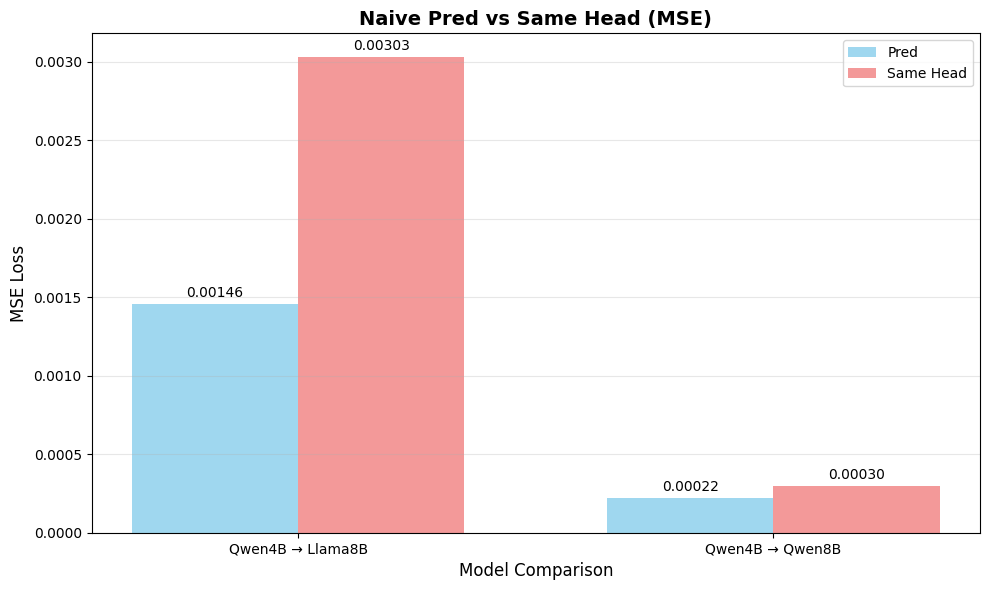

In [29]:
# Organize data for plotting
categories = ['Qwen4B → Llama8B', 'Qwen4B → Qwen8B']
pred_values = [np.mean(mse_loss_pred_list_qwen4b2llama8b), np.mean(mse_loss_pred_list_qwen4b2qwen8b)]
same_head_values = [np.mean(mse_loss_same_head_list_qwen4b2llama8b), np.mean(mse_loss_same_head_list_qwen4b2qwen8b)]

# Set up the bar plot
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bars1 = ax.bar(x - width/2, pred_values, width, label='Pred', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, same_head_values, width, label='Same Head', alpha=0.8, color='lightcoral')

# Customize the plot
ax.set_xlabel('Model Comparison', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Naive Pred vs Same Head (MSE)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.5f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.5f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

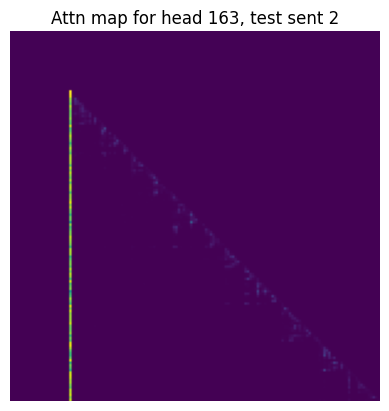

In [11]:
input_model = 'qwen4b'
output_model = 'qwen8b'
sent_id = 2
B_head_id = 163
gt_map = B_test[sent_id][B_head_id].reshape((150, 150))
plt.imshow(gt_map)
plt.axis('off')
plt.title(f"Attn map for head {B_head_id}, test sent {sent_id}")
plt.show()

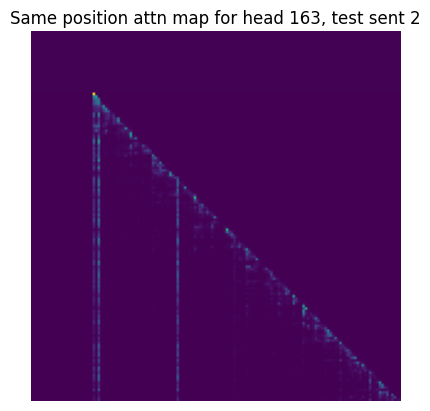

In [12]:
same_head_map = A_test[sent_id][B_head_id].reshape((150, 150))
plt.imshow(same_head_map)
plt.axis('off')
plt.title(f"Same position attn map for head {B_head_id}, test sent {sent_id}")
plt.show()

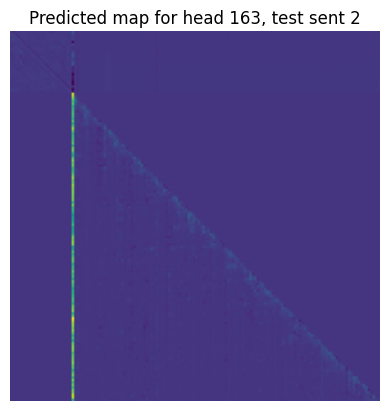

In [13]:
predicted_map = (weights[B_head_id] @ A_test[sent_id]).reshape((150, 150)) + intercepts[B_head_id]
plt.imshow(predicted_map)
plt.axis('off')
plt.title(f"Predicted map for head {B_head_id}, test sent {sent_id}")
plt.show()

In [15]:
((predicted_map - gt_map)**2).mean()

np.float64(0.00022220475995217098)

In [16]:
((same_head_map - gt_map)**2).mean()

np.float64(0.00029525343190066545)

In [41]:
np.argmax(weights[B_head_id]), np.max(weights[B_head_id])

(np.int64(247), np.float64(0.3374245666666876))

In [ ]:
# Train with PyTorch approach
start_time = time.time()
weights, bias, train_errors, test_errors = pytorch_approach(
    A_train, A_test, B_train, B_test, epochs=1500
)
end_time = time.time()

print(f"\nTraining completed in {end_time - start_time:.2f} seconds")
print(f"Average train MSE across all heads: {np.mean(train_errors):.6f}")
print(f"Average test MSE across all heads: {np.mean(test_errors):.6f}")
print(f"Best performing head (test MSE): {np.min(test_errors):.6f}")
print(f"Worst performing head (test MSE): {np.max(test_errors):.6f}")